 ## UK Road Safety: Traffic Accidents and Vehicles
 
 The goal of this project is the investigate what causes Serious and Fatal accidents in hopes of preventing and decreasing the number of them. The dataset consists of accident records from the UK over the course of 15+ years. I hope to show the causes of these accidents through visualizations and create an algorithm that can predict the severity of accidents. 
 
The UK government collects and publishes (usually on an annual basis) detailed information about traffic accidents across the country. This information includes, but is not limited to, geographical locations, weather conditions, type of vehicles, number of casualties and vehicle manoeuvres, making this a very interesting and comprehensive dataset for analysis and research.

The data that I'm using is compiled and available through [Kaggle](https://www.kaggle.com/tsiaras/uk-road-safety-accidents-and-vehicles) and in a less compliled form, [here](https://beta.ukdataservice.ac.uk/datacatalogue/series/series?id=2000045). 

Problem: Severe and fatal accidents.
Solution: Use data to figure out how to lower the number of accidents and the severity of them.

Questions:
1. What effects the severity of accidents?
2. What measures should be looked into in order to lessen the severity of accidents?
3. Can we create an algorithm that correctly predicts the severity of accidents?
4. What are the limitations of the current data?
5. What things would help this research to be more accurate?
6. Who does this project benefit?


### Table of Contents
[Importing and Data Merging](#Importing-and-Data-Merging)<br>
[Data Cleaning](#Data-Cleaning)<br>
[Nulls and Outliers](#Nulls-and-Outliers)<br>
[Feature Manipulation, Creation and Engineering](#Feature-Manipulation-Creation-and-Engineering)<br>
[General Visualizations](#General-Visualizations)<br>
[Correlations](#Correlations)<br>
[Visualizations In Relation to Accident Seriousness](#Visualizations-In-Relation-to-Accident-Seriousness)<br>
[Other Visualizations](#Other-Visualizations)<br>
[Other Visualizations Summary](#Other-Visualizations-Summary)<br>
[Solution](#Solution)<br>
[Machine Learning](#Machine-Learning)<br>
[Selected Machine Learning Algorithm and Explanation](#Selected-Machine-Learning-Algorithm-and-Explanation)<br>

### Importing and Data Merging

In [1]:
#Import modules
import numpy as np
import holidays
import pandas as pd
import seaborn as sns
import pickle
import time
import timeit

import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

import datetime
import math

#scipy
import scipy
from scipy import stats
from scipy.stats import ttest_ind

#sklearn
import sklearn
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

#other learners
from xgboost import XGBClassifier
import lightgbm as lgb

#time series stuff
import statsmodels.api as sm
from pylab import rcParams
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA


#warning ignorer
import warnings
warnings.filterwarnings("ignore")

In [2]:
#DATAFRAME PICKLE CREATED IN CELLS BELOW INSTEAD OF RUNNING THROUGH ENTIRE PROCESS AFTER RESTARTING
#import pickled file
df = pd.read_pickle("df.pkl")

In [2]:
#import files

ac = pd.read_csv(r'Accident_Information.csv', low_memory=False, chunksize=30000)
vc = pd.read_csv(r'Vehicle_Information.csv', low_memory=False, chunksize=30000)

Previously, I did not remove "Data missing or out of range" from the datasets however through cleaning and checking the value counts I decided to do so for sanity purposes only. Most of the percentages that had this as a value were not a high percentage either. 

In [3]:
#chunk cleaning and dataframing for accident column
acchunk = []
for chunk in ac:
    acchunk_filter = chunk[
        (chunk.Year.astype(int) >= 2010) &
        (chunk.Year.astype(int) <= 2017) &
        (chunk['Road_Type'] != "Unknown") &
        (chunk['Junction_Control'] != "Data missing or out of range") &
        (chunk['Carriageway_Hazards'] != "Data missing or out of range") &
        (chunk['Junction_Detail'] != "Data missing or out of range") &
        (chunk['Road_Surface_Conditions'] != "Data missing or out of range") &
        (chunk['Special_Conditions_at_Site'] != "Data missing or out of range") &
        (chunk['Weather_Conditions'] != "Data missing or out of range") &
        (chunk['Latitude'].notnull()) &
        (chunk['Longitude'].notnull())
    ]
    acchunk.append(acchunk_filter)
df1 = pd.concat(acchunk)


In [4]:
#chunk cleaning for vehicles column
vcchunk = []
for chunk2 in vc:
    vcchunk_filter = chunk2[
        (chunk2.Year.astype(int) >= 2010)&
        (chunk2.Year.astype(int) <= 2017) &
        (chunk2['Driver_Home_Area_Type'] != "Data missing or out of range") &
        (chunk2['Journey_Purpose_of_Driver'] != "Data missing or out of range") &
        (chunk2['Junction_Location'] != "Data missing or out of range") &
        (chunk2['Was_Vehicle_Left_Hand_Drive'] != "Data missing or out of range") &
        (chunk2['Hit_Object_in_Carriageway'] != "Data missing or out of range") &
        (chunk2['Skidding_and_Overturning'] != "Data missing or out of range") &
        (chunk2['Towing_and_Articulation'] != "Data missing or out of range") &
        (chunk2['Vehicle_Leaving_Carriageway'] != "Data missing or out of range") &
        (chunk2['Vehicle_Manoeuvre'] != "Data missing or out of range") &
        (chunk2['Vehicle_Type'] != "Data missing or out of range") &
        (chunk2['X1st_Point_of_Impact'] != "Data missing or out of range") &
        (chunk2['Sex_of_Driver'] != "Data missing or out of range") &
        (chunk2['Age_Band_of_Driver'] != "Data missing or out of range")
        
    ]
    vcchunk.append(vcchunk_filter)
df2 = pd.concat(vcchunk)

In [5]:
#check columns
print("Accident's Columns:\n",df1.columns, "\n")

print("Vehicle's Columns:\n",df2.columns)

Accident's Columns:
 Index(['Accident_Index', '1st_Road_Class', '1st_Road_Number', '2nd_Road_Class',
       '2nd_Road_Number', 'Accident_Severity', 'Carriageway_Hazards', 'Date',
       'Day_of_Week', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions',
       'Local_Authority_(District)', 'Local_Authority_(Highway)',
       'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude',
       'LSOA_of_Accident_Location', 'Number_of_Casualties',
       'Number_of_Vehicles', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Police_Force',
       'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site',
       'Speed_limit', 'Time', 'Urban_or_Rural_Area', 'Weather_Conditions',
       'Year', 'InScotland'],
      dtype='object') 

Vehicle's Columns:
 Index(['Accident_Index', 'Age_Band_of_Driver', 'Age_of_Vehicle',
       'Driver_Home_Area_Type', 'Driver_IMD_Decile', '

In [6]:
print('Accident Shape', df1.shape)
print('Vehicle Shape',df2.shape)

Accident Shape (691195, 34)
Vehicle Shape (1167198, 24)


In [7]:
#merge dataframes
df = pd.merge(df1,df2)

In [8]:
#check columns
print("Names of Combined Columns:\n",df.columns, "\n")
print("\nShape:\n",df.shape)

Names of Combined Columns:
 Index(['Accident_Index', '1st_Road_Class', '1st_Road_Number', '2nd_Road_Class',
       '2nd_Road_Number', 'Accident_Severity', 'Carriageway_Hazards', 'Date',
       'Day_of_Week', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions',
       'Local_Authority_(District)', 'Local_Authority_(Highway)',
       'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude',
       'LSOA_of_Accident_Location', 'Number_of_Casualties',
       'Number_of_Vehicles', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Police_Force',
       'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site',
       'Speed_limit', 'Time', 'Urban_or_Rural_Area', 'Weather_Conditions',
       'Year', 'InScotland', 'Age_Band_of_Driver', 'Age_of_Vehicle',
       'Driver_Home_Area_Type', 'Driver_IMD_Decile', 'Engine_Capacity_.CC.',
       'Hit_Object_in_Carriageway', 'Hit

In [9]:
df.describe(include ='all')

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,...,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact
count,720280,720280,720280.000000,699431,710979.000000,720280,720280,720280,720280,720279.000000,...,720280,720280,720280,720280,720269.000000,720280,720280.000000,720280,720280,720280
unique,488010,6,NaN,6,NaN,3,6,2557,7,NaN,...,3,6,6,9,NaN,18,NaN,20,2,5
top,2016140142191,A,NaN,Unclassified,NaN,Slight,None,2015-05-13,Friday,NaN,...,Male,None,No tow/articulation,Did not leave carriageway,NaN,Going ahead other,NaN,Car,No,Front
freq,15,365390,NaN,473098,NaN,626656,714068,515,119324,NaN,...,484205,659742,713570,663463,NaN,314008,NaN,534189,719140,354438
mean,NaN,NaN,1051.470728,NaN,607.761499,NaN,NaN,NaN,NaN,1.147353,...,NaN,NaN,NaN,NaN,0.086026,NaN,1.506420,NaN,NaN,NaN
std,NaN,NaN,1825.784600,NaN,1593.978070,NaN,NaN,NaN,NaN,0.357791,...,NaN,NaN,NaN,NaN,0.784117,NaN,0.644346,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN
25%,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN
50%,NaN,NaN,191.000000,NaN,0.000000,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN
75%,NaN,NaN,900.000000,NaN,173.000000,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,NaN,NaN,NaN


### Data Cleaning

In [10]:
#check corr b/t Location_Easting_OSGR & Location_Northing_OSGR AND Longitude and Latitude

print(df['Location_Easting_OSGR'].corr(df['Longitude']))


print(df['Location_Northing_OSGR'].corr(df['Latitude']))

0.999425701544617
0.9999733124707393


In [11]:
#drop Location_Easting_OSGR & Location_Northing_OSGR
#because they are the similar to Latitude and Longitude 

df = df.drop(['Location_Easting_OSGR', 'Location_Northing_OSGR'], axis=1)

In [12]:
df.shape

(720280, 54)

In [13]:
#standardize all column names to lowercase, and remove some characters 
#for ease of use in querying
df.columns = map(str.lower, df.columns)
df.columns = df.columns.str.replace('.','')
df.columns = df.columns.str.replace('(','')
df.columns = df.columns.str.replace(')','')

In [14]:
#convert date/time to datetime datatype

df['date'] = pd.to_datetime((df['date']), format= "%Y-%m-%d")



In [15]:
#df.dtypes

In [16]:
#mistyped datatypes

df[['did_police_officer_attend_scene_of_accident',
    'driver_imd_decile','vehicle_reference',
    'vehicle_locationrestricted_lane','1st_road_number',
    '2nd_road_number','driver_imd_decile',
    'pedestrian_crossing-physical_facilities',
   'pedestrian_crossing-human_control']]= df[['did_police_officer_attend_scene_of_accident',
    'driver_imd_decile','vehicle_reference',
    'vehicle_locationrestricted_lane','1st_road_number',
    '2nd_road_number','driver_imd_decile',
    'pedestrian_crossing-physical_facilities',
   'pedestrian_crossing-human_control']].astype('object')



In [17]:
df.columns.to_series().groupby(df.dtypes).groups

{dtype('<M8[ns]'): Index(['date'], dtype='object'),
 dtype('int64'): Index(['number_of_casualties', 'number_of_vehicles', 'year'], dtype='object'),
 dtype('float64'): Index(['latitude', 'longitude', 'speed_limit', 'age_of_vehicle',
        'engine_capacity_cc'],
       dtype='object'),
 dtype('O'): Index(['accident_index', '1st_road_class', '1st_road_number', '2nd_road_class',
        '2nd_road_number', 'accident_severity', 'carriageway_hazards',
        'day_of_week', 'did_police_officer_attend_scene_of_accident',
        'junction_control', 'junction_detail', 'light_conditions',
        'local_authority_district', 'local_authority_highway',
        'lsoa_of_accident_location', 'pedestrian_crossing-human_control',
        'pedestrian_crossing-physical_facilities', 'police_force',
        'road_surface_conditions', 'road_type', 'special_conditions_at_site',
        'time', 'urban_or_rural_area', 'weather_conditions', 'inscotland',
        'age_band_of_driver', 'driver_home_area_type', 

#### Nulls and Outliers

In [18]:
df.isnull().sum().sort_values(ascending=False)/df.shape[0]*100

driver_imd_decile                              25.118565
age_of_vehicle                                 15.287805
model                                          11.636447
engine_capacity_cc                             11.283251
propulsion_code                                10.899928
make                                            5.846476
lsoa_of_accident_location                       5.674738
2nd_road_class                                  2.894569
2nd_road_number                                 1.291303
pedestrian_crossing-physical_facilities         0.006109
pedestrian_crossing-human_control               0.005276
time                                            0.004582
speed_limit                                     0.001805
vehicle_locationrestricted_lane                 0.001527
did_police_officer_attend_scene_of_accident     0.000139
day_of_week                                     0.000000
1st_road_class                                  0.000000
number_of_vehicles             

##### 2nd_road_class

In [19]:
# #2nd_road_class
df['2nd_road_class'].value_counts()/df.shape[0]*100

Unclassified    65.682512
A               15.892292
C                7.591909
B                6.494558
Motorway         1.301716
A(M)             0.142445
Name: 2nd_road_class, dtype: float64

With 40% of non null being unclassified and 39% of the overall 2nd_road_class column being null, I have decided to drop it in it's entirely. 

In [20]:
df = df.drop(['2nd_road_class'], axis=1)

##### driver_imd_decile

In [21]:
#driver_imd_decile
df['driver_imd_decile'].value_counts()/df.shape[0]*100

2.0     8.366469
3.0     8.281640
4.0     7.986339
1.0     7.888321
5.0     7.717554
6.0     7.530683
7.0     7.195674
8.0     6.948270
9.0     6.803049
10.0    6.163436
Name: driver_imd_decile, dtype: float64

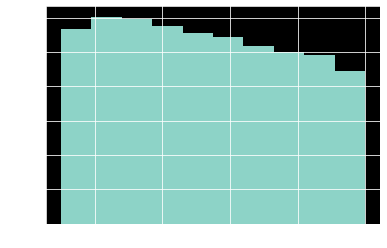

In [22]:
df['driver_imd_decile'].hist()
plt.style.use('dark_background')

Since the distribution of categories for 'driver_imd_decile seem very similar, I've decided not to use the mode but "method='ffill'"

In [23]:
df['driver_imd_decile'].fillna(method='ffill', inplace=True)

##### age_of_vehicle

In [24]:
df['age_of_vehicle'].describe()

count    610165.000000
mean          7.567473
std           4.751567
min           1.000000
25%           4.000000
50%           7.000000
75%          11.000000
max         105.000000
Name: age_of_vehicle, dtype: float64

In [25]:
df['age_of_vehicle'].median()

7.0

Changing the nulls of "age of vehicle" to median, then creating it as a category

In [26]:
#fillna by 7 
df['age_of_vehicle'].fillna(7, inplace=True)

#group age_of_vehicle
#1=0-3, 2=3-5, 3=5-8, 4=8-11, 5=
def fixedvehicleage(age):
    if age>=0 and age<=120:
        return age
    else:
        return np.nan

df['age_of_vehicle'] = df['age_of_vehicle'].apply(fixedvehicleage)


df['age_of_vehicle'] = pd.cut(df['age_of_vehicle'], 
                             [0,2,5,8,11,14,17,120], labels=['1', '2', '3','4','5','6','7'])


##### Model

In [27]:
#model
df['model'].value_counts()/df.shape[0]*100

MISSING                          0.743183
KA                               0.336675
CLIO DYNAMIQUE 16V               0.279058
FIESTA ZETEC                     0.247681
SPRINTER 313 CDI                 0.236158
206 LX                           0.220331
PUNTO ACTIVE                     0.212279
CLIO EXPRESSION 16V              0.199783
YBR 125                          0.194785
FIESTA FINESSE                   0.177570
MINI COOPER                      0.175904
KA COLLECTION                    0.174793
CORSA CLUB 12V                   0.160910
MICRA S                          0.160493
FIESTA ZETEC CLIMATE             0.158827
CORSA CLUB 16V                   0.158272
PUNTO ACTIVE 8V                  0.141889
MINI ONE                         0.141334
KA STYLE                         0.140640
FIESTA STYLE                     0.140223
FIESTA LX                        0.140084
FOCUS ZETEC TDCI                 0.139113
107 URBAN                        0.137308
CORSA SXI                        0

In [28]:
df['model'].describe()

count      636465
unique      28664
top       MISSING
freq         5353
Name: model, dtype: object

Knowing that there are 28824 unique models for the model column I have decided to use the ffill method on it as well. 

In [29]:
df['model'].fillna(method='ffill', inplace=True)

Note: A lot of the values of "model' are labeled as "missing". I do not want to change these because the model could have actually been missing from the car from the accident or it could not be recognizable at the time of the accident.

#### engine_capacity_cc

In [30]:
#engine_capacity_cc
df['engine_capacity_cc'].describe()

count    639009.000000
mean       1848.094816
std        1573.057956
min           2.000000
25%        1248.000000
50%        1598.000000
75%        1995.000000
max       91000.000000
Name: engine_capacity_cc, dtype: float64

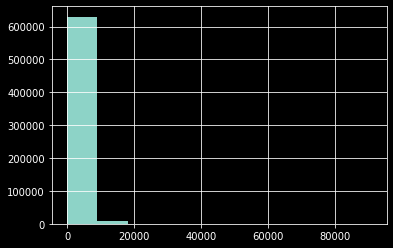

In [31]:
df['engine_capacity_cc'].hist()
plt.style.use('dark_background')

I am going to handle both outliers and the null values of engine_capacity_cc using the ideals of quantiles and the interquartile range (IQR).

In [32]:
#first I'm going to handle both ends of outliers.
#(determine the min and max cuttoffs for detecting the outlier)
q75, q25 = np.percentile(df['engine_capacity_cc'].dropna(), [75 ,25])
iqr = q75 - q25
 
ecmin = q25 - (iqr*1.5)
ecmax = q75 + (iqr*1.5)

print(ecmax)
print(ecmin)

3115.5
127.5


To explain, what I am going to do is use the ecmax number for the maximum engine_capacity_cc and ecmin for my engine_capacity_cc. Then I'm going to take the mean of those and use it as my fillna.

In [33]:
df = df[df['engine_capacity_cc']<=ecmax]

In [34]:
df = df[df['engine_capacity_cc']>=ecmin]

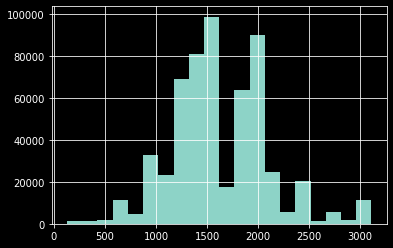

In [35]:
df['engine_capacity_cc'].hist(bins=20)
plt.style.use('dark_background')

I can accept this distribution and will now check and handle their nulls

In [36]:
#check values of 'engine_capacity_cc'
df['engine_capacity_cc'].describe()

count    569057.000000
mean       1633.351432
std         473.765085
min         128.000000
25%        1299.000000
50%        1598.000000
75%        1968.000000
max        3110.000000
Name: engine_capacity_cc, dtype: float64

In [37]:
df['engine_capacity_cc'].mean()

1633.3514322818276

Going to round this mean value

In [38]:
df['engine_capacity_cc'].fillna(1652, inplace=True)

Note: After doing the above null fixes, propulsion_code dropped from having 10% null values to 0. (see below). I will continue on and fix lsoa_of_accident_location then drop the rest of the null values with are all <5%.

In [39]:
df.isnull().sum().sort_values(ascending=False)/df.shape[0]*100

lsoa_of_accident_location                      5.902045
2nd_road_number                                1.317618
make                                           0.063087
pedestrian_crossing-human_control              0.005448
pedestrian_crossing-physical_facilities        0.005096
time                                           0.003866
vehicle_locationrestricted_lane                0.001406
speed_limit                                    0.001230
did_police_officer_attend_scene_of_accident    0.000176
date                                           0.000000
accident_severity                              0.000000
road_type                                      0.000000
road_surface_conditions                        0.000000
police_force                                   0.000000
1st_road_class                                 0.000000
1st_road_number                                0.000000
number_of_vehicles                             0.000000
number_of_casualties                           0

#### lsoa_of_accident_location

In [40]:
# #lsoa_of_accident_location
df['lsoa_of_accident_location'].value_counts()

E01032739    440
E01004736    412
E01000004    410
E01018648    303
E01004689    261
E01002444    231
E01030458    229
E01011365    213
E01016012    203
E01012851    192
E01024335    188
E01010521    185
E01011107    184
E01007913    178
E01023732    176
E01008440    176
E01013607    176
E01009200    175
E01016952    173
E01022677    173
E01031587    171
E01031583    171
E01032740    170
E01023584    168
E01008397    167
E01007611    166
E01003482    165
E01018337    164
E01005131    163
E01024721    162
            ... 
E01020417      1
E01001776      1
E01001842      1
E01005410      1
E01010078      1
E01032493      1
E01024642      1
E01013208      1
E01029822      1
E01030386      1
E01014887      1
E01028665      1
E01012928      1
E01030956      1
E01028815      1
E01033056      1
E01026820      1
E01014938      1
E01001967      1
E01018642      1
E01018682      1
E01024749      1
E01031616      1
W01000170      1
W01000305      1
E01003999      1
E01012436      1
E01021050     

In [41]:
df['lsoa_of_accident_location'].describe()

count        535471
unique        33936
top       E01032739
freq            440
Name: lsoa_of_accident_location, dtype: object

With 35061 unique variable and a high count amount the top variables I am deciding to do ffill again. 

In [42]:
df['lsoa_of_accident_location'].fillna(method='ffill', inplace=True)

In [43]:
#### Check nulls for again
df.isnull().sum().sort_values(ascending=False)/df.shape[0]*100

2nd_road_number                                1.317618
make                                           0.063087
pedestrian_crossing-human_control              0.005448
pedestrian_crossing-physical_facilities        0.005096
time                                           0.003866
vehicle_locationrestricted_lane                0.001406
speed_limit                                    0.001230
did_police_officer_attend_scene_of_accident    0.000176
carriageway_hazards                            0.000000
longitude                                      0.000000
road_type                                      0.000000
road_surface_conditions                        0.000000
police_force                                   0.000000
1st_road_class                                 0.000000
1st_road_number                                0.000000
number_of_vehicles                             0.000000
number_of_casualties                           0.000000
lsoa_of_accident_location                      0

Dropping the remaining nulls that are <1%.

In [44]:
#drop the remaining nulls that are <1%
df.dropna(inplace=True)

#last check
df.isnull().sum().sort_values(ascending=False)/df.shape[0]*100

x1st_point_of_impact                           0.0
speed_limit                                    0.0
road_type                                      0.0
road_surface_conditions                        0.0
police_force                                   0.0
pedestrian_crossing-physical_facilities        0.0
pedestrian_crossing-human_control              0.0
number_of_vehicles                             0.0
number_of_casualties                           0.0
lsoa_of_accident_location                      0.0
longitude                                      0.0
local_authority_highway                        0.0
local_authority_district                       0.0
light_conditions                               0.0
latitude                                       0.0
junction_detail                                0.0
junction_control                               0.0
did_police_officer_attend_scene_of_accident    0.0
day_of_week                                    0.0
date                           

In [45]:
df.shape

(561135, 53)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561135 entries, 0 to 720279
Data columns (total 53 columns):
accident_index                                 561135 non-null object
1st_road_class                                 561135 non-null object
1st_road_number                                561135 non-null object
2nd_road_number                                561135 non-null object
accident_severity                              561135 non-null object
carriageway_hazards                            561135 non-null object
date                                           561135 non-null datetime64[ns]
day_of_week                                    561135 non-null object
did_police_officer_attend_scene_of_accident    561135 non-null object
junction_control                               561135 non-null object
junction_detail                                561135 non-null object
latitude                                       561135 non-null float64
light_conditions                        

#### More outliers, categorizing, and other cleanup

In [47]:
#detecting outliers of numerical columns (all floats/ints excluding lat/long and year)

df_num = df[['engine_capacity_cc','number_of_casualties','number_of_vehicles','speed_limit']]


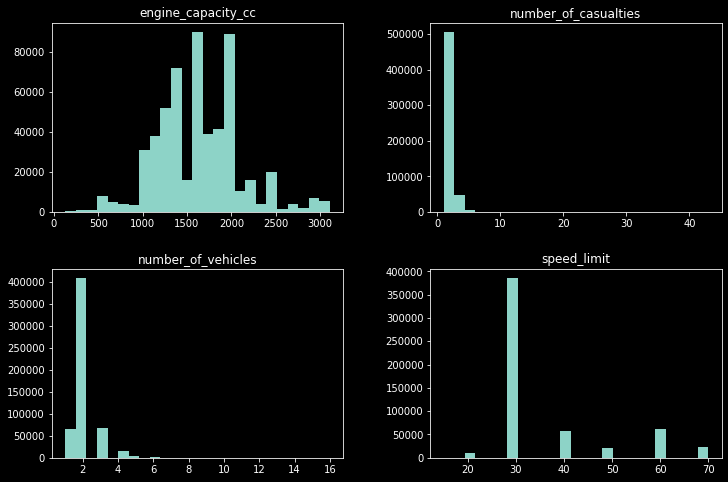

In [48]:
df_num.hist( bins=25, grid=False, figsize=(12,8))
plt.style.use('dark_background')

Column 'speed_limit' seems ok and was previously altered 'engine_capacity_cc'. However, 'number_of_casualties', and 'number_of_vehicles',will be evaluated. 

In [49]:
# #number_of_casualties
df['number_of_casualties'].value_counts()

1     391938
2     113736
3      35451
4      12511
5       4621
6       1739
7        599
8        243
9        146
10        52
11        29
12        28
13        15
16        10
14         4
15         3
17         3
24         2
21         2
19         1
22         1
43         1
Name: number_of_casualties, dtype: int64

In [50]:
#create casualities grouping

def casualities(num_cas):
    if num_cas >=1 and num_cas <2:
        return "1"
    elif num_cas >=2 and num_cas <3:
        return "2"
    elif num_cas >=3 and num_cas <4:
        return "3"
    elif num_cas >= 4 and num_cas <5:
        return "4"
    elif num_cas >= 5:
        return "5+"
  
    

In [51]:
#apply function   
df['number_of_casualties']= df['number_of_casualties'].apply(casualities)

In [52]:
#number_of_casualties
df['number_of_casualties'].value_counts()

1     391938
2     113736
3      35451
4      12511
5+      7499
Name: number_of_casualties, dtype: int64

In [53]:
df['propulsion_code'].value_counts()/df.shape[0]*100

Petrol                 60.540155
Heavy oil              38.544913
Hybrid electric         0.782699
Gas/Bi-fuel             0.094808
Petrol/Gas (LPG)        0.021207
Electric diesel         0.013188
Gas                     0.002317
New fuel technology     0.000356
Gas Diesel              0.000178
Fuel cells              0.000178
Name: propulsion_code, dtype: float64

In [54]:
#Clean the values for Propulsion Code. 
df['propulsion_code'] = df['propulsion_code'].replace(to_replace="Gas", value="Petrol")
df['propulsion_code'] = df['propulsion_code'].replace(to_replace="Gas/Bi-fuel", value="Bio-fuel")
df['propulsion_code'] = df['propulsion_code'].replace(to_replace="Petrol/Gas (LPG)", value="LPG Petrol")
df['propulsion_code'] = df['propulsion_code'].replace(to_replace="Gas Diesel", value="Diesel")

In [55]:
df['propulsion_code'].value_counts()/df.shape[0]*100

Petrol                 60.542472
Heavy oil              38.544913
Hybrid electric         0.782699
Bio-fuel                0.094808
LPG Petrol              0.021207
Electric diesel         0.013188
New fuel technology     0.000356
Diesel                  0.000178
Fuel cells              0.000178
Name: propulsion_code, dtype: float64

### Feature Manipulation Creation and Engineering

In [56]:
# #unique values
df.nunique().sort_values(ascending=False)

accident_index                                 412838
longitude                                      356283
latitude                                       346962
lsoa_of_accident_location                       33895
model                                           25688
2nd_road_number                                  5781
1st_road_number                                  5088
date                                             2557
time                                             1439
engine_capacity_cc                               1023
local_authority_district                          380
make                                              226
local_authority_highway                           207
police_force                                       51
vehicle_manoeuvre                                  18
vehicle_type                                       16
number_of_vehicles                                 15
vehicle_reference                                  15
hit_object_in_carriageway   

In [57]:
df['date'] = pd.to_datetime(df['date'])

In [58]:
df['month'] = df ['date'].apply(lambda time: time.month)

In [59]:
#creating a weekend feature that includes Friday-Sunday
df['weekend']= np.where(df['day_of_week'].isin(['Friday', 'Saturday', 'Sunday']), 1, 0)

In [225]:
#create time of day feature with Morning Rush, Day, Noon Rush, Afternoon, After Work Rush, Night

#time of day dictionary
timeofdaygroups = {1: "Morning Rush (6-10)",
                   2: "Day (10-12)",
                   3: "Lunch Rush (12-14)",
                   4: "Afternoon (14-16)",
                   5: "After Work Rush (16-18)",
                   6: "Evening (18-22)",
                   7: "Night (22-6)"}

In [61]:
#pull time data and create hour column
df['hour'] = df['time'].str[0:2]
 
#convert to numeric    
df['hour'] =  pd.to_numeric(df['hour'])

#convert to integer
df['hour'] = df['hour'].astype('int')

In [228]:
#create time_of_day grouping

def daygroup(hour):
    if hour >= 6 and hour < 10:
        return "1"
    elif hour >= 10 and hour < 12:
        return "2"
    elif hour >= 12 and hour < 14:
        return "3"
    elif hour >= 14 and hour < 16:
        return "4"
    elif hour >= 16 and hour < 18:
        return "5"
    elif hour >= 18 and hour < 22:
        return "6"
    else:
        return "7"
    

In [229]:
#apply function   
#time of day function
df['time_of_day']= df['hour'].apply(daygroup)   

In [64]:
df[['weekend','day_of_week','time', 'time_of_day']].tail(10)

,weekend,day_of_week,time,time_of_day
720270,0,Wednesday,08:45,1
720271,0,Wednesday,08:45,1
720272,0,Tuesday,18:12,6
720273,1,Sunday,11:00,2
720274,1,Sunday,11:00,2
720275,0,Monday,16:32,5
720276,0,Monday,16:32,5
720277,1,Friday,06:45,1
720278,0,Tuesday,16:45,5
720279,0,Tuesday,16:45,5


In [65]:
#vehicle_type
df['vehicle_type'].value_counts()/df.shape[0]*100

Car                                      86.052020
Van / Goods 3.5 tonnes mgw or under       5.481212
Motorcycle over 500cc                     3.999929
Taxi/Private hire car                     2.932628
Motorcycle over 125cc and up to 500cc     0.881428
Motorcycle 125cc and under                0.178567
Minibus (8 - 16 passenger seats)          0.140251
Other vehicle                             0.131519
Goods over 3.5t. and under 7.5t           0.083937
Motorcycle 50cc and under                 0.043840
Bus or coach (17 or more pass seats)      0.024771
Goods vehicle - unknown weight            0.015326
Goods 7.5 tonnes mgw and over             0.013188
Motorcycle - unknown cc                   0.013009
Agricultural vehicle                      0.007128
Electric motorcycle                       0.001247
Name: vehicle_type, dtype: float64

I want to condense the vehicle type variables. 

In [123]:
#motorcycles
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Motorcycle over 500cc", 
                                                        value="Motorcycle")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace=
                                                        "Motorcycle over 125cc and up to 500cc",
                                                        value="Motorcycle")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Motorcycle 125cc and under", 
                                                value="Motorcycle")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Motorcycle 50cc and under", 
                                                        value="Motorcycle")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Electric motorcycle", 
                                                        value="Motorcycle")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Motorcycle - unknown cc", 
                                                        value="Motorcycle")


#Goods_vehicle
df['vehicle_type'] = df['vehicle_type'].replace(to_replace=
                                                        "Van / Goods 3.5 tonnes mgw or under", 
                                                        value="Goods Vehicle")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Goods over 3.5t. and under 7.5t", 
                                                        value="Goods Vehicle")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Goods vehicle - unknown weight", 
                                                        value="Goods Vehicle")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Goods 7.5 tonnes mgw and over", 
                                                        value="Goods Vehicle")

#car
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Taxi/Private hire car", 
                                                        value="Car")


#bus
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Minibus (8 - 16 passenger seats)", 
                                                        value="Bus")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace=
                                                        "Bus or coach (17 or more pass seats)", 
                                                        value="Bus")

#other vehicle
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Agricultural vehicle", 
                                                        value="Other Vehicle")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Other vehicle", 
                                                        value="Other Vehicle")


In [124]:
#vehicle_type
df['vehicle_type'].value_counts()/df.shape[0]*100

Car              88.984647
Goods Vehicle     5.593663
Motorcycle        5.118020
Bus               0.165023
Other Vehicle     0.138648
Name: vehicle_type, dtype: float64

Create more condense groups for age band of driver in order to deal with some potential outliers.

In [68]:
#age_band_of_driver 
df['age_band_of_driver'].value_counts()/df.shape[0]*100

26 - 35    22.598662
36 - 45    20.728345
46 - 55    17.551213
21 - 25    12.208827
56 - 65    10.373796
16 - 20     7.145696
66 - 75     5.624850
Over 75     3.757028
11 - 15     0.011049
6 - 10      0.000356
0 - 5       0.000178
Name: age_band_of_driver, dtype: float64

In [69]:
#I did this before hand because as "Over 75", it wouldnt convert in the codes below
df['age_band_of_driver']=df['age_band_of_driver'].replace("Over 75","75-100")

In [70]:
age1 = ["0 - 5", "6 - 10", "11 - 15"]
age2 = ["16 - 20","21 - 25"]
age3 = ["26 - 35","36 - 45"]
age4 = ["46 - 55", "56 - 65"]
age5 = ["66 - 75", "75-100"]

In [71]:
#over 75 wouldnt work in the string so I did it separately
for (row, col) in df.iterrows():

    if str.lower(col.age_band_of_driver) in age1:
        df['age_band_of_driver'].replace(to_replace=col.age_band_of_driver, 
                                         value='Under 16', inplace=True)

    if str.lower(col.age_band_of_driver) in age2:
        df['age_band_of_driver'].replace(to_replace=col.age_band_of_driver, 
                                         value='16-25', inplace=True)
    
    if str.lower(col.age_band_of_driver) in age3:
        df['age_band_of_driver'].replace(to_replace=col.age_band_of_driver, 
                                         value='26-45', inplace=True)
    if str.lower(col.age_band_of_driver) in age4:
        df['age_band_of_driver'].replace(to_replace=col.age_band_of_driver, 
                                         value='46-65', inplace=True)
    if str.lower(col.age_band_of_driver) in age5:
        df['age_band_of_driver'].replace(to_replace=col.age_band_of_driver, 
                                         value='Over 65', inplace=True)

In [72]:
#age_band_of_driver
print("Distinct responses for age_band_of_driver:\n", set(df['age_band_of_driver']))

Distinct responses for age_band_of_driver:
 {'Over 65', 'Under 16', '46-65', '26-45', '16-25'}


In [73]:
# number_of_vehicles
df['number_of_vehicles'].value_counts()/df.shape[0]*100

2     72.944835
3     11.924403
1     11.570121
4      2.706122
5      0.582747
6      0.167874
7      0.059166
8      0.021385
11     0.005881
9      0.005881
10     0.004277
14     0.002317
13     0.002139
16     0.001782
12     0.001069
Name: number_of_vehicles, dtype: float64

In [74]:
#group number_of_vehicles

def vehicles(num_veh):
    if num_veh >=1 and num_veh <2:
        return "1"
    elif num_veh >=2 and num_veh <3:
        return "2"
    elif num_veh >=3 and num_veh <4:
        return "3"
    elif num_veh >= 4: 
        return "4+"
  
#apply function   
df['number_of_vehicles']= df['number_of_vehicles'].apply(vehicles)

In [75]:
# number_of_vehicles
df['number_of_vehicles'].value_counts()/df.shape[0]*100

2     72.944835
3     11.924403
1     11.570121
4+     3.560640
Name: number_of_vehicles, dtype: float64

In [76]:
df['number_of_vehicles'].dtypes

dtype('O')

In [77]:
df['number_of_vehicles']=df['number_of_vehicles'].astype('object')

In [78]:
#creating seasons column for ML

#creating season column

def getSeason(month):
    if (month == 12 or month == 1 or month == 2):
       return "winter"
    elif(month == 3 or month == 4 or month == 5):
       return "spring"
    elif(month == 6 or month== 7 or month == 8):
       return "summer"
    else:
       return "fall"

df['season'] = df['month'].apply(getSeason)

In [79]:
# number_of_vehicles
df['season'].value_counts()/df.shape[0]*100

fall      27.065858
summer    25.502241
spring    24.624912
winter    22.806989
Name: season, dtype: float64

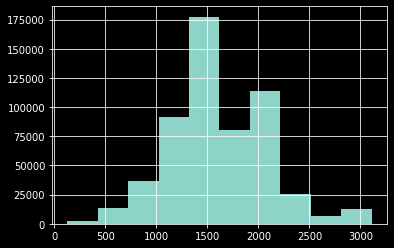

In [80]:
#go back to engine capacity CC and crete groups
df.engine_capacity_cc.hist()

In [81]:
def enginecap(eng_cc):
    if eng_cc <=1500:
        return "small engine cc"
    if eng_cc >1500 and eng_cc <=2000:
        return "medium engine cc"
    if eng_cc >2000:
        return "large engine cc"


df['engine_capacity_cc_size'] = df['engine_capacity_cc'].apply(enginecap)

In [82]:
df.engine_capacity_cc_size.value_counts()

medium engine cc    259881
small engine cc     231031
large engine cc      70223
Name: engine_capacity_cc_size, dtype: int64

In [83]:
#Put above pickle in next full run
#create new column for Machine Learning and Visualization with Not Serious and Serious
df['accident_seriousness'] = df['accident_severity']
df['accident_seriousness'] = df['accident_seriousness'].replace(to_replace="Slight", 
                                                                value="Not Serious")
df['accident_seriousness'] = df['accident_seriousness'].replace(to_replace="Serious",
                                                                value="Serious")
df['accident_seriousness'] = df['accident_seriousness'].replace(to_replace="Fatal", 
                                                                value="Serious")
df.shape

(561135, 60)

In [84]:
df.accident_seriousness.value_counts()

Not Serious    492804
Serious         68331
Name: accident_seriousness, dtype: int64

In [85]:
#pickling everything to speed up restarting
df.to_pickle("df.pkl")

In [16]:
#import pickled file
df = pd.read_pickle("df.pkl")
df.head()

,accident_index,1st_road_class,1st_road_number,2nd_road_number,accident_severity,carriageway_hazards,date,day_of_week,did_police_officer_attend_scene_of_accident,junction_control,...,vehicle_type,was_vehicle_left_hand_drive,x1st_point_of_impact,month,weekend,hour,time_of_day,season,engine_capacity_cc_size,accident_seriousness
0,201001BS70003,B,302,0,Slight,None,2010-01-11,Monday,1,Give way or uncontrolled,...,Goods Vehicle,No,Front,1,0,7,1,winter,small engine cc,Not Serious
1,201001BS70004,A,402,4204,Slight,None,2010-01-11,Monday,1,Auto traffic signal,...,Car,No,Front,1,0,18,6,winter,medium engine cc,Not Serious
3,201001BS70007,Unclassified,0,0,Slight,None,2010-01-02,Saturday,1,Give way or uncontrolled,...,Car,No,Nearside,1,1,21,6,winter,medium engine cc,Not Serious
4,201001BS70007,Unclassified,0,0,Slight,None,2010-01-02,Saturday,1,Give way or uncontrolled,...,Car,No,Front,1,1,21,6,winter,small engine cc,Not Serious
5,201001BS70008,A,3217,3220,Slight,None,2010-01-04,Monday,1,Auto traffic signal,...,Car,No,Nearside,1,0,20,6,winter,medium engine cc,Not Serious


### General Visualizations

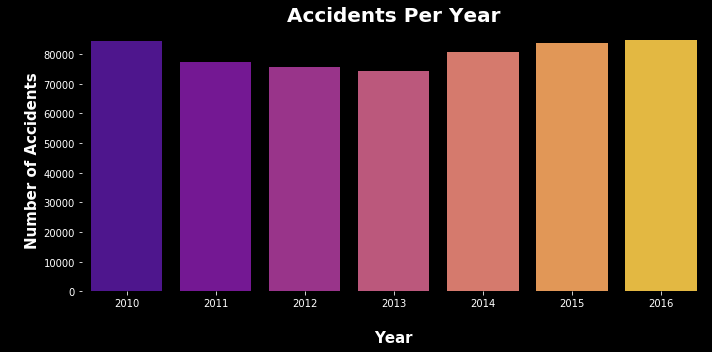

In [278]:
accidentsperyear = df.groupby(['year'])['accident_index'].count()

# prepare plot
plt.style.use('dark_background')
plt.figure(figsize=(10,5))
colors = sns.color_palette("plasma", n_colors=7)
sns.barplot(accidentsperyear.index,accidentsperyear.values, palette=colors)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.title("Accidents Per Year",fontsize=20,fontweight="bold")
plt.xlabel("\nYear", fontsize=15, fontweight="bold")
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.savefig('accidentsperyear.png')
plt.tight_layout()


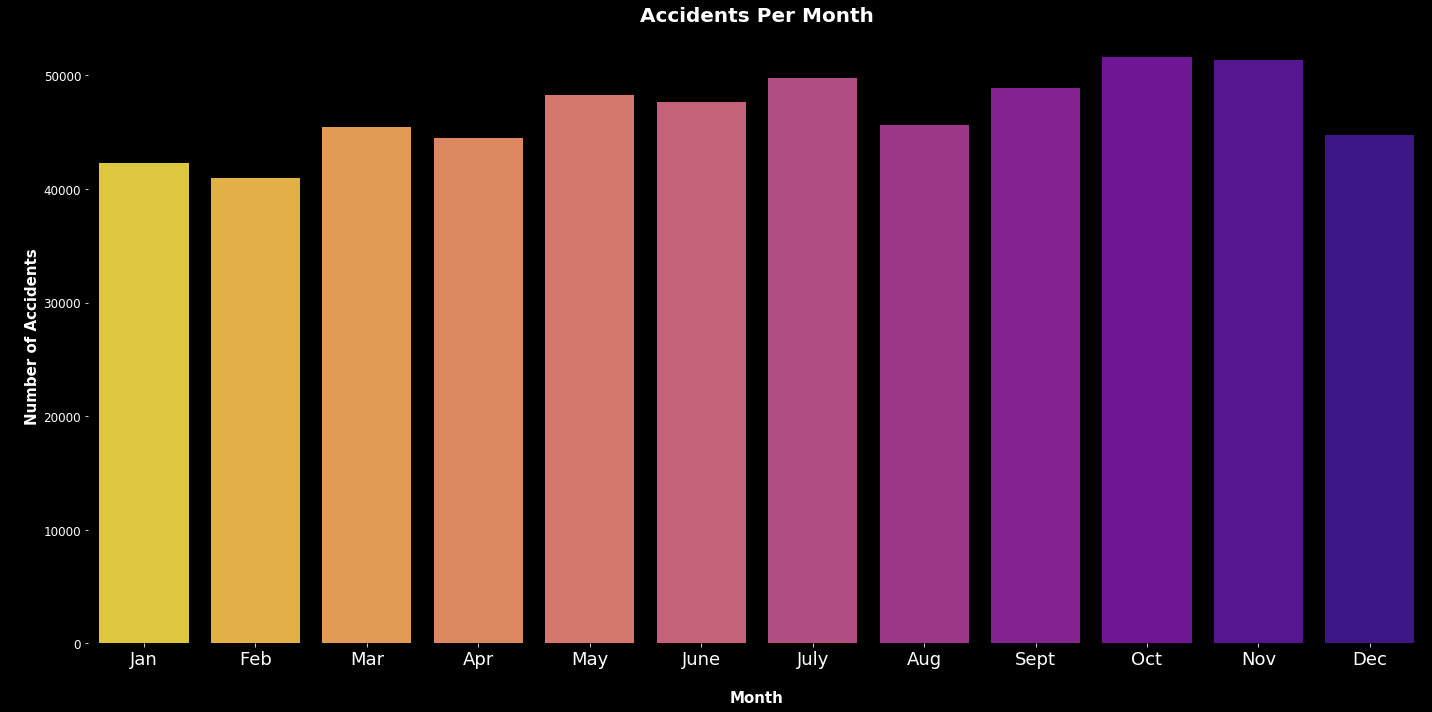

In [277]:
accidentspermonth = df.groupby(['month'])['accident_index'].count()

# prepare plot
plt.style.use('dark_background')
plt.figure(figsize=(20,10))
colors = sns.color_palette("plasma_r", n_colors=12)
mt=sns.barplot(accidentspermonth.index,accidentspermonth.values, palette=colors)
sns.despine(top=True, right=True, left=True, bottom=True)
#ax is the axes instance
group_labels = ['Jan', 'Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec' ]

mt.set_xticklabels(group_labels)
plt.title("Accidents Per Month",fontsize=20,fontweight="bold")
plt.xticks(fontsize=18)
plt.yticks(fontsize=12)
plt.xlabel("\nMonth", fontsize=15, fontweight="bold")
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.savefig('accidentspermonth.png')
plt.tight_layout()


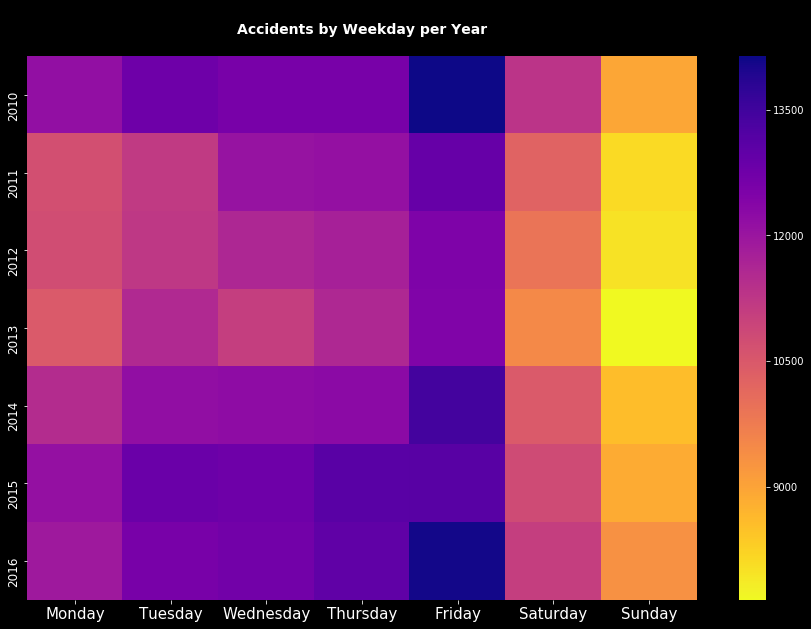

In [276]:
weekdays = ['Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
accweekday = df.groupby(['year', 'day_of_week']).size()
accweekday = accweekday.rename_axis(['year', 'day_of_week'])\
                               .unstack('day_of_week')\
                               .reindex(columns=weekdays)
plt.figure(figsize=(15,10))
plt.style.use('dark_background')
sns.heatmap(accweekday, cmap='plasma_r')
plt.title('\nAccidents by Weekday per Year\n', fontsize=14, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.savefig('accidentsbyweekdayperyear.png')
plt.show()

Fridays are the day of the week where the most accidents occur.

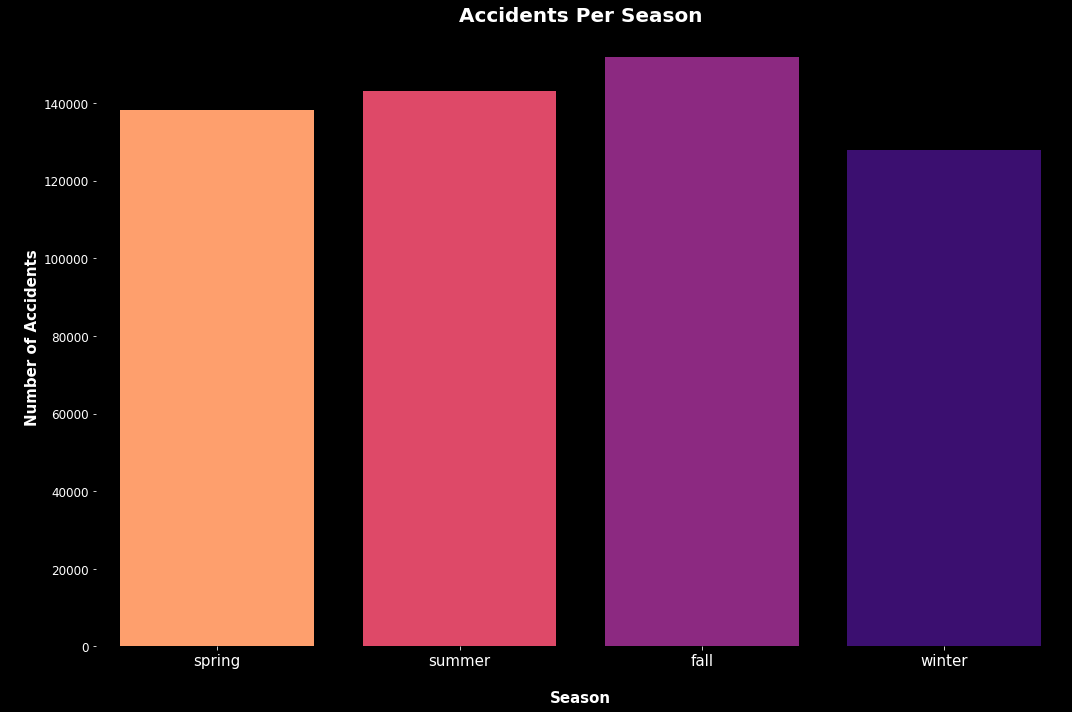

In [273]:
accidentsperseason = df.groupby(['season'])['accident_index'].count()
seaord=['spring', 'summer', 'fall','winter']
# prepare plot
plt.style.use('dark_background')
plt.figure(figsize=(15,10))

sns.barplot(accidentsperseason.index,accidentsperseason.values, order=seaord, 
            saturation=1, palette='magma_r')
sns.despine(top=True, right=True, left=True, bottom=True)
plt.title("Accidents Per Season",fontsize=20,fontweight="bold")
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.xlabel("\nSeason", fontsize=15, fontweight="bold")
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tight_layout()
plt.savefig('accidentsperseason.png')


In [17]:
#"Morning Rush (6-10)", "Day (10-12)", "Lunch Rush (12-14)","Afternoon (14-16)",
#"After Work Rush (16-18)", "Evening (18-22)", "Night (22-6)"

timeofdaygroups = {'1': "Morning Rush",
                   '2': "Day",
                   '3': "Lunch Rush",
                   '4': "Afternoon",
                   '5': "After Work Rush",
                   '6': "Evening",
                   '7': "Night"}
df['time_of_day']=df['time_of_day'].map(timeofdaygroups)

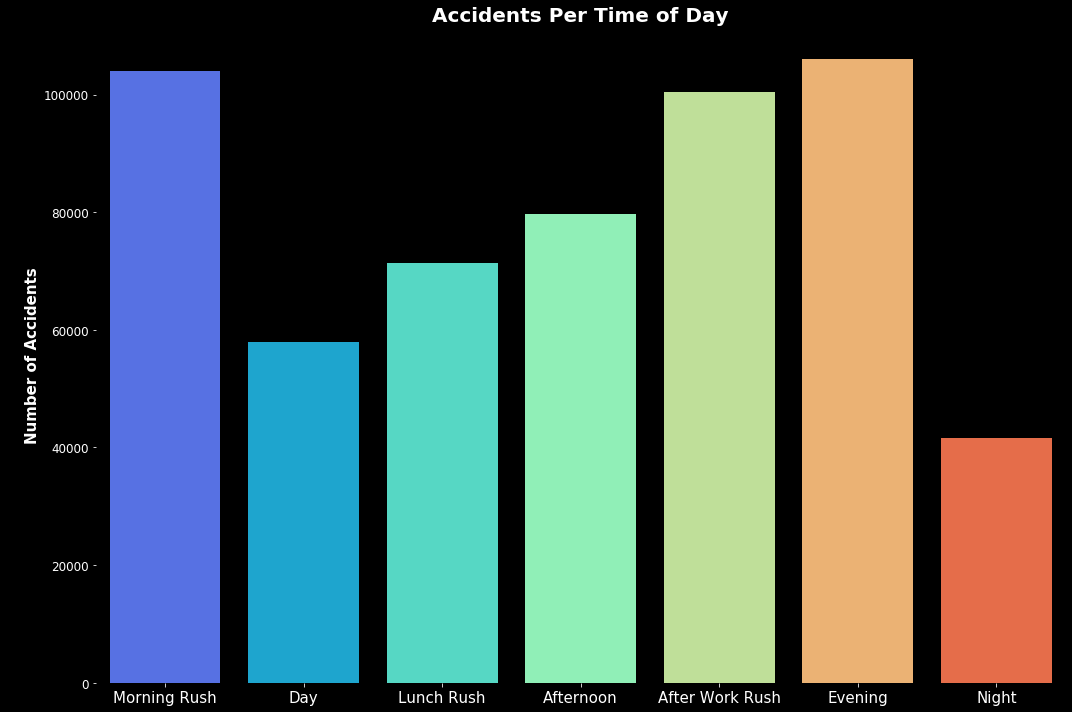

In [267]:
accidentspertod = df.groupby(['time_of_day'])['accident_index'].count()

# prepare plot
plt.style.use('dark_background')
plt.figure(figsize=(15,10))
tod=["Morning Rush", "Day", "Lunch Rush", "Afternoon",
     "After Work Rush", "Evening", "Night"]
sns.barplot(accidentspertod.index,accidentspertod.values, order=tod, palette='rainbow')
sns.despine(top=True, right=True, left=True, bottom=True)
plt.title("Accidents Per Time of Day",fontsize=20,fontweight="bold")
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)

plt.xlabel("", fontsize=15, fontweight="bold")
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tight_layout()
plt.savefig('accidentspertod.png')


In [91]:
print(df.columns)

Index(['accident_index', '1st_road_class', '1st_road_number',
       '2nd_road_number', 'accident_severity', 'carriageway_hazards', 'date',
       'day_of_week', 'did_police_officer_attend_scene_of_accident',
       'junction_control', 'junction_detail', 'latitude', 'light_conditions',
       'local_authority_district', 'local_authority_highway', 'longitude',
       'lsoa_of_accident_location', 'number_of_casualties',
       'number_of_vehicles', 'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities', 'police_force',
       'road_surface_conditions', 'road_type', 'special_conditions_at_site',
       'speed_limit', 'time', 'urban_or_rural_area', 'weather_conditions',
       'year', 'inscotland', 'age_band_of_driver', 'age_of_vehicle',
       'driver_home_area_type', 'driver_imd_decile', 'engine_capacity_cc',
       'hit_object_in_carriageway', 'hit_object_off_carriageway',
       'journey_purpose_of_driver', 'junction_location', 'make', 'model',
       'pr

In [9]:
# #change objects to category
# df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))


### Correlations

In [92]:
#correlation by accident severity

corrdf=df.apply(LabelEncoder().fit_transform)
corr=corrdf.corr()['accident_seriousness']
corr[np.argsort(corr,axis=0)[::-1]]

accident_seriousness                           1.000000
vehicle_type                                   0.132070
x1st_point_of_impact                           0.076099
speed_limit                                    0.065554
skidding_and_overturning                       0.059322
vehicle_leaving_carriageway                    0.058977
sex_of_driver                                  0.054505
lsoa_of_accident_location                      0.048548
number_of_casualties                           0.043294
age_band_of_driver                             0.039851
junction_control                               0.037966
hit_object_off_carriageway                     0.036040
time_of_day                                    0.026101
model                                          0.022808
accident_index                                 0.022391
junction_location                              0.019548
road_type                                      0.019443
engine_capacity_cc_size                        0

In [18]:
#dataframe where accidents are Slight
not_serious = df[(df['accident_seriousness']=="Not Serious")]
print("Not Serious Group Shape:", not_serious.shape)

not_serious.accident_seriousness.value_counts()

Not Serious Group Shape: (492804, 60)


Not Serious    492804
Name: accident_seriousness, dtype: int64

In [19]:
#dataframe where accidents are serious
serious= df[(df['accident_seriousness']=="Serious")]

print("Serious Group Shape:", serious.shape)
serious.accident_seriousness.value_counts()

Serious Group Shape: (68331, 60)


Serious    68331
Name: accident_seriousness, dtype: int64

Looking at this I wanted to visualize some of the higher pos/negative correlations against accident severity.

## Visualizations In Relation to Accident Seriousness

#### Method:
For my visualizations I have decided to use some of the features with the highest correlations to accident_seriousness:
* did_police_officer_attend_scene_of_accident 
* x1st_point_of_impact 
* number_of_vehicles  
* speed_limit
* urban_or_rural_area  
* skidding_and_overturning 
* vehicle_leaving_carriageway 
* sex_of_driver     
* vehicle_type  
* vehicle_manoeuvre 
* engine_capacity_cc 
* number_of_casualties                           
* driver_home_area_type  
* age_band_of_driver  
* junction_control  
* hit_object_off_carriageway
* hit_object_in_carriageway 
* driver_imd_decile *
* junction_detail *
* junction_location *
* propulsion_code *
* year *
***
Note: This columns used were selected because of the absolute value of their correlation in relation to accident_seriousness

*columns added after correlation was done after undersampling

In [20]:
#map 1, 2, 3 in did_police_officer_attend_scene_of_accident with Yes, No,Self-reported
policeattend = {1: "Yes", 2:"No", 3:"Self-Reported"}
not_serious['did_police_officer_attend_scene_of_accident']=not_serious['did_police_officer_attend_scene_of_accident'].map(policeattend)
df['did_police_officer_attend_scene_of_accident']=df['did_police_officer_attend_scene_of_accident'].map(policeattend)
serious['did_police_officer_attend_scene_of_accident']=serious['did_police_officer_attend_scene_of_accident'].map(policeattend)


In [21]:
imddecile = {1:"Most deprived 10%", 2:"More deprived 10-20%", 3:"More deprived 20-30%", 
             4:"More deprived 30-40%", 5:"More deprived 40-50%", 6:"Less deprived 40-50%", 
             7:"Less deprived 30-40%", 8:"Less deprived 20-30%", 9:"Less deprived 10-20%", 
             10:"Least deprived 10%"}

not_serious['driver_imd_decile']=not_serious['driver_imd_decile'].map(imddecile)
df['driver_imd_decile']=df['driver_imd_decile'].map(imddecile)
serious['driver_imd_decile']=serious['driver_imd_decile'].map(imddecile)


In [22]:
#setups for adding frequencies to visualizations
dftotal= float(len(df))
nstotal= float(len(not_serious))
setotal= float(len(serious))


#### Did Police Officer Attend Scene Of Accident

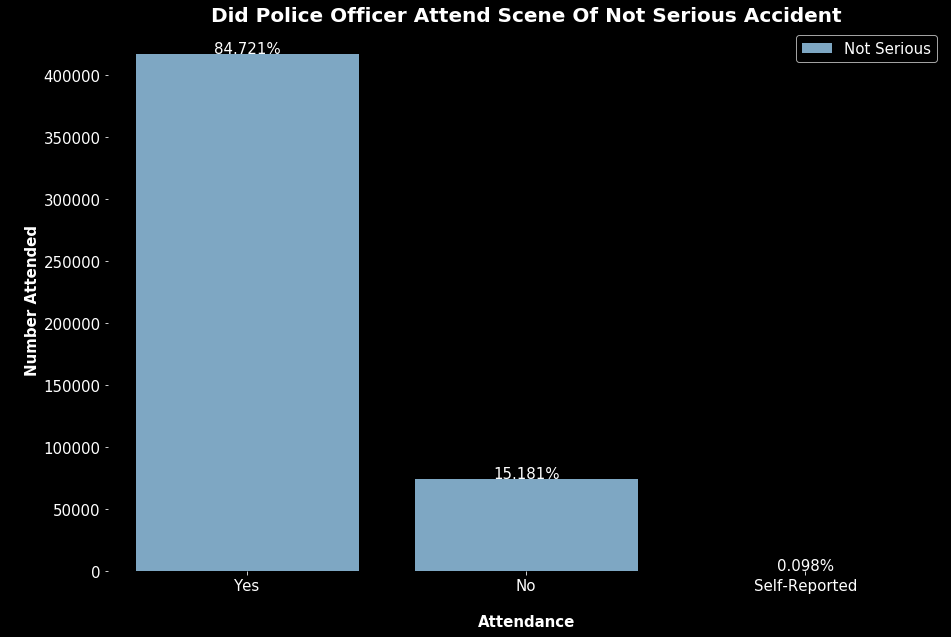

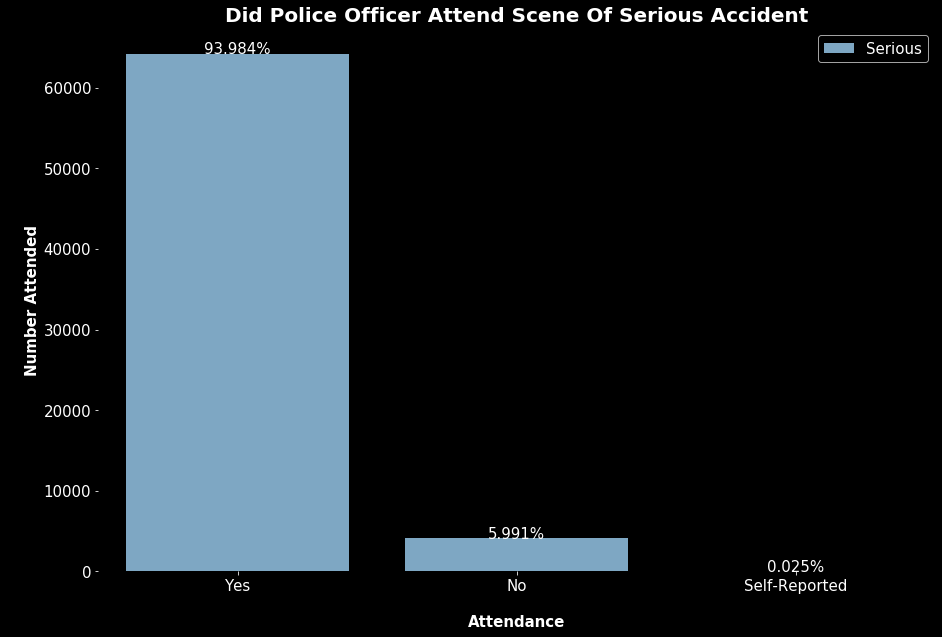

In [101]:
#Did Police Officer Attend Scene Of Accident
plt.figure(figsize=(15,10))
ax = sns.countplot("did_police_officer_attend_scene_of_accident", hue="accident_seriousness",  
              palette="PuBu", data=not_serious)
plt.title("Did Police Officer Attend Scene Of Not Serious Accident",
          fontsize=20, fontweight="bold")
plt.style.use('dark_background')
plt.xlabel("\nAttendance", fontsize=15, fontweight="bold")
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber Attended", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('did_police_officer_attend_scene_of_accident_not_serious.png')
plt.show()


#Did Police Officer Attend Scene Of Accident
plt.figure(figsize=(15,10))
ax = sns.countplot("did_police_officer_attend_scene_of_accident", hue="accident_seriousness",  
              palette="PuBu", data=serious)
plt.title("Did Police Officer Attend Scene Of Serious Accident",
          fontsize=20, fontweight="bold")
plt.style.use('dark_background')
plt.xlabel("\nAttendance", fontsize=15, fontweight="bold")
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber Attended", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('did_police_officer_attend_scene_of_accident_serious.png')
plt.show()


#### First Point of Impact Vs Accident Seriousness

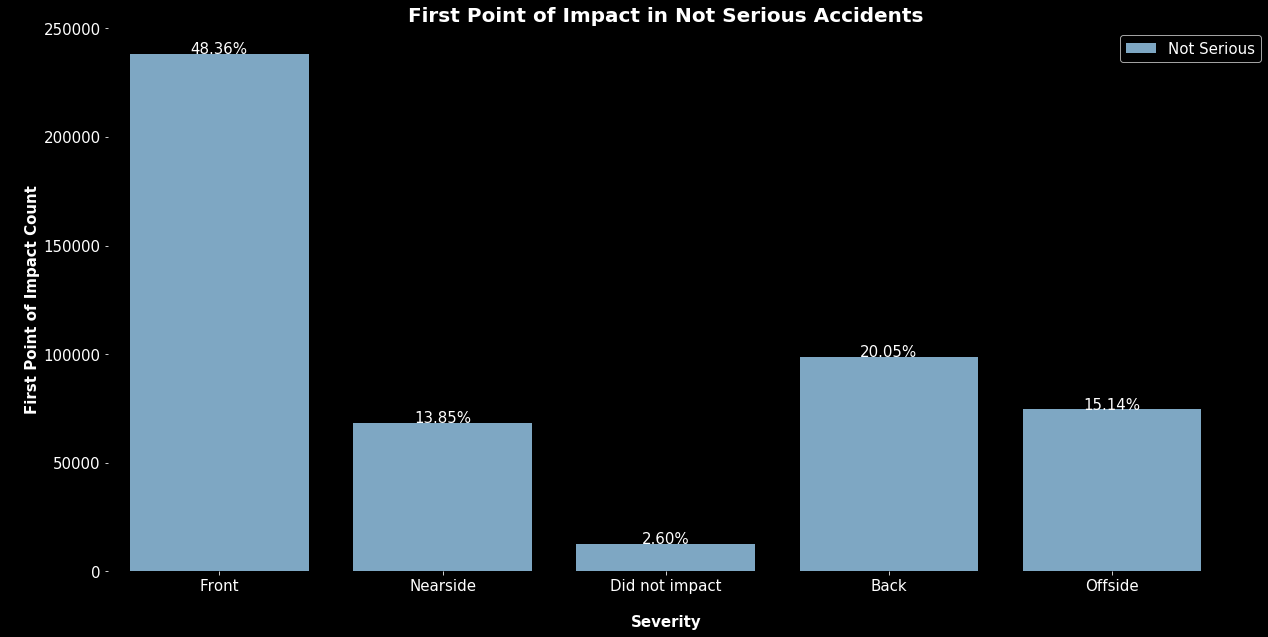

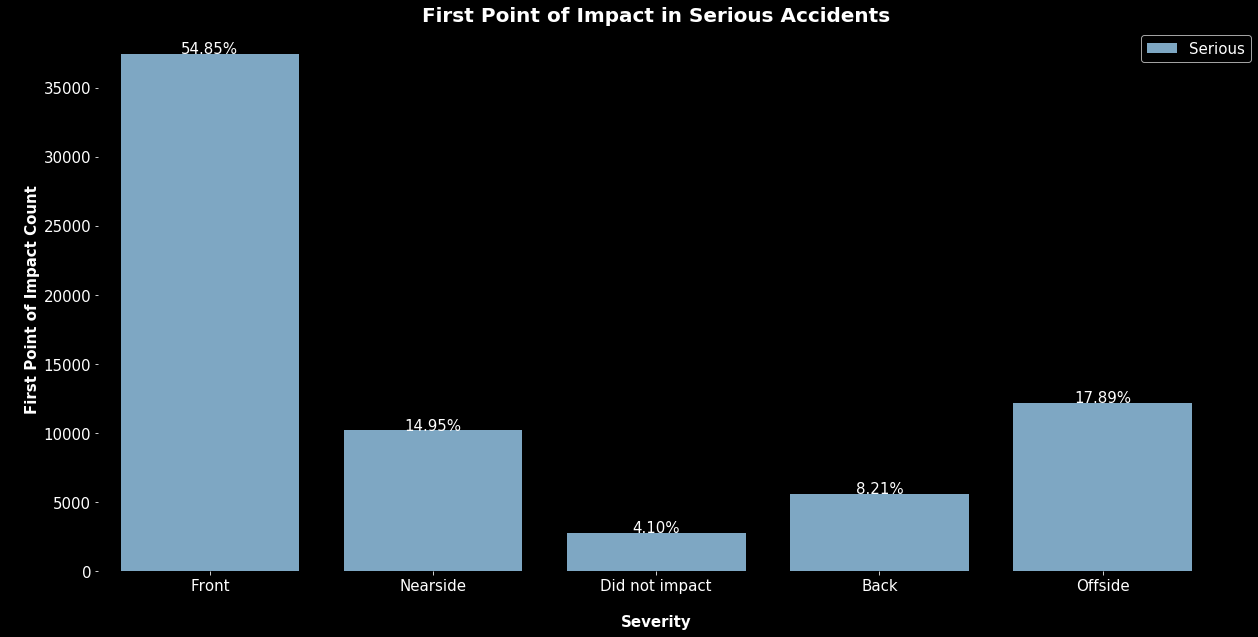

In [102]:
# First Point of Impact Vs Accident Seriousness (Not Serious)
fpoa_order =["Front", "Nearside", "Did not impact", "Back", "Offside"]
plt.figure(figsize=(20,10))
ax = sns.countplot("x1st_point_of_impact", hue="accident_seriousness", order=fpoa_order,  
              palette="PuBu", data=not_serious)
plt.title("First Point of Impact in Not Serious Accidents",fontsize=20,fontweight="bold")
plt.style.use('dark_background')
plt.xlabel("\nPoint of Impact", fontsize=15, fontweight="bold")
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nFirst Point of Impact Count", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('x1st_point_of_impact_not_serious.png')
plt.show()


# First Point of Impact Vs Accident Seriousness
plt.figure(figsize=(20,10))
ax = sns.countplot("x1st_point_of_impact", hue="accident_seriousness",  order=fpoa_order,
              palette="PuBu", data=serious)
plt.title("First Point of Impact in Serious Accidents",fontsize=20,fontweight="bold")
plt.style.use('dark_background')
plt.xlabel("\nPoint of Impact", fontsize=15, fontweight="bold")
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nFirst Point of Impact Count", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('x1st_point_of_impact_serious.png')
plt.show()

#### Number of Vehicles

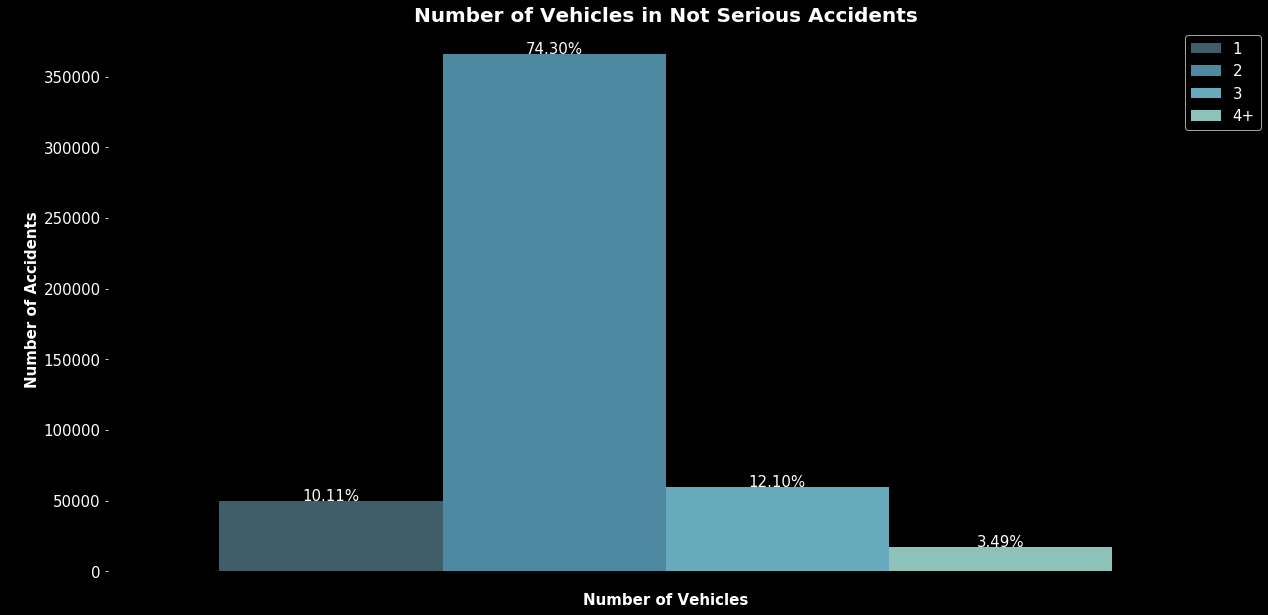

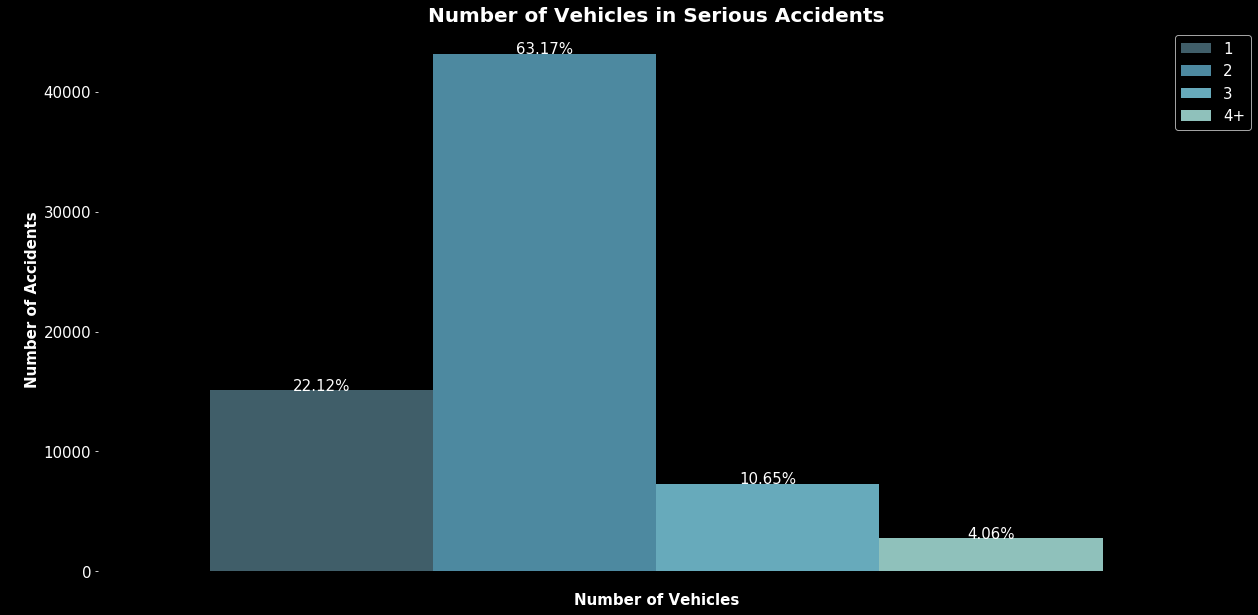

In [103]:
#number of vehicles vs accidentseriousness
nov_order=["1","2", "3", "4+"]
#notserious
plt.figure(figsize=(20,10))
ax = sns.countplot("accident_seriousness", hue="number_of_vehicles", hue_order=nov_order,
              palette="GnBu_d", data=not_serious)

plt.style.use('dark_background')
plt.title("Number of Vehicles in Not Serious Accidents",
          fontsize=20, fontweight="bold")

plt.xlabel("\nNumber of Vehicles", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('number_of_vehicles_not_serious.png')
plt.show()



#serious
plt.figure(figsize=(20,10))
ax = sns.countplot("accident_seriousness", hue="number_of_vehicles", hue_order=nov_order,
              palette="GnBu_d", data=serious)
plt.style.use('dark_background')
plt.title("Number of Vehicles in Serious Accidents",
          fontsize=20, fontweight="bold")

plt.xlabel("\nNumber of Vehicles", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('number_of_vehicles_serious.png')
plt.show()



##### Speed Limit vs Accident Seriousness

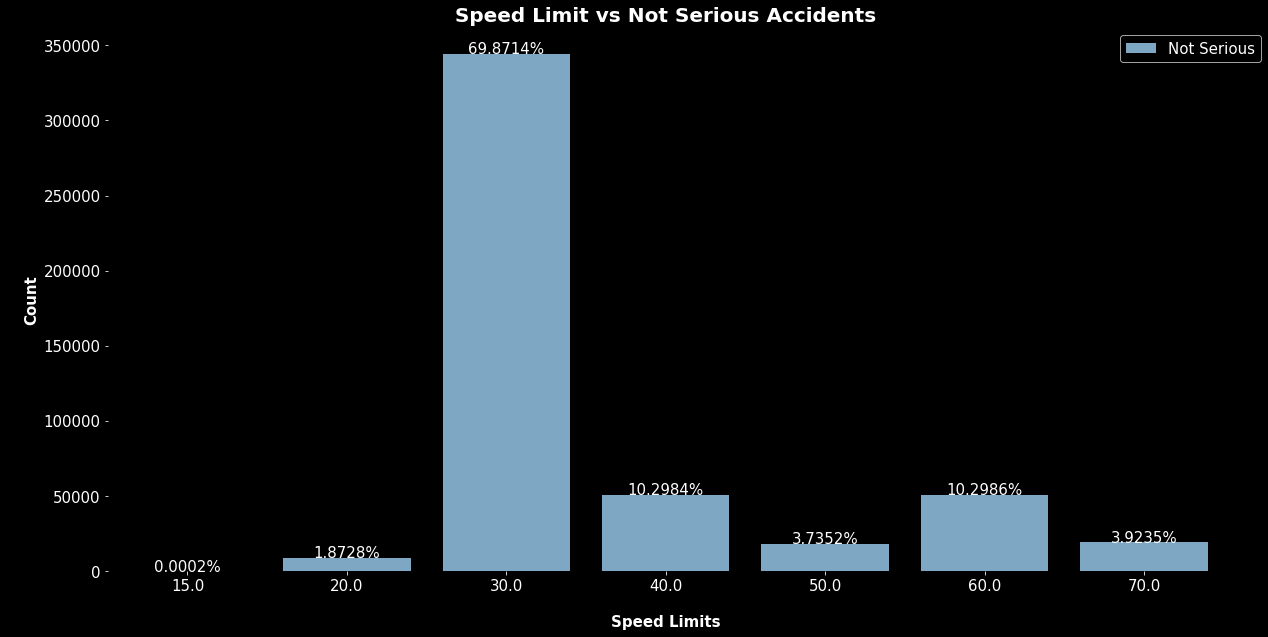

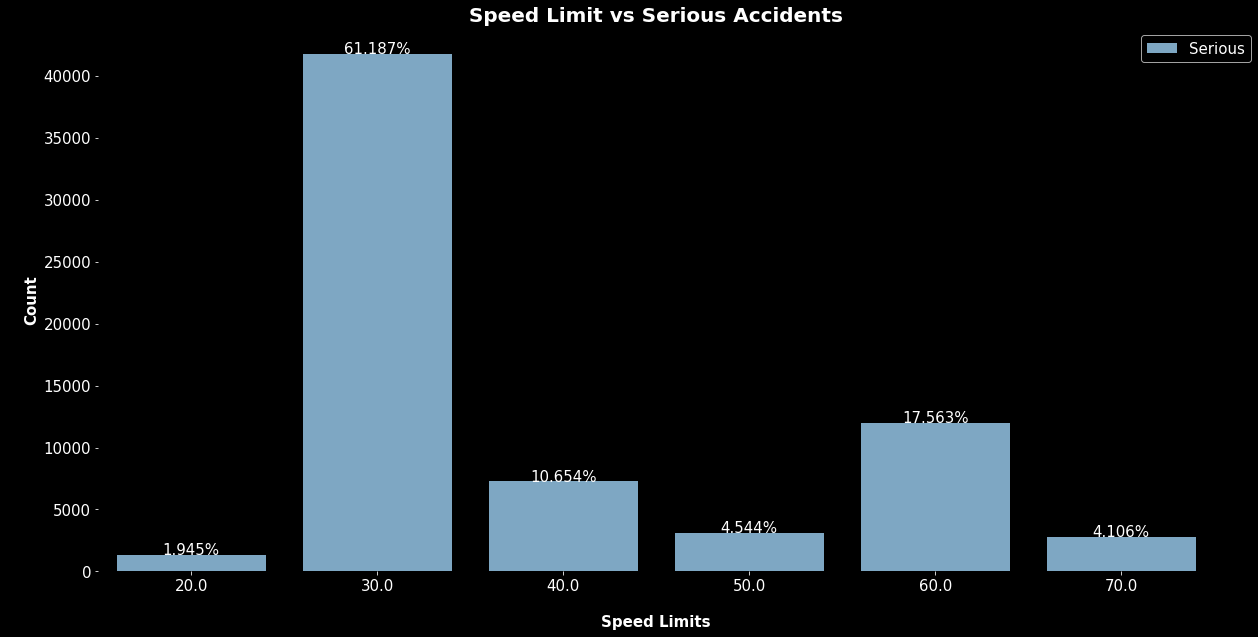

In [111]:
#notserious
splt_order=[15.0, 20.0,30.0,40.0 ,50.0,60.0, 70.0]
#splt1_order=[20.0,30.0,40.0 ,50.0,60.0, 70.0]
plt.figure(figsize=(20,10))
ax = sns.countplot("speed_limit", hue="accident_seriousness", order=splt_order,
              palette="PuBu", data=not_serious)
plt.title("Speed Limit vs Not Serious Accidents",fontsize=20,fontweight="bold")
plt.style.use('dark_background')
plt.xlabel("\nSpeed Limits", fontsize=15, fontweight="bold")
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nCount", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.4f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('speed_limit_not_serious.png')
plt.show()

#erious
plt.figure(figsize=(20,10))
ax = sns.countplot("speed_limit", hue="accident_seriousness", 
              palette="PuBu", data=serious)
plt.title("Speed Limit vs Serious Accidents",fontsize=20,fontweight="bold")
plt.style.use('dark_background')
plt.xlabel("\nSpeed Limits", fontsize=15, fontweight="bold")
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nCount", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('speed_limit_serious.png')
plt.show()

#### Urban  or Rural  Area vs Accident Seriousness

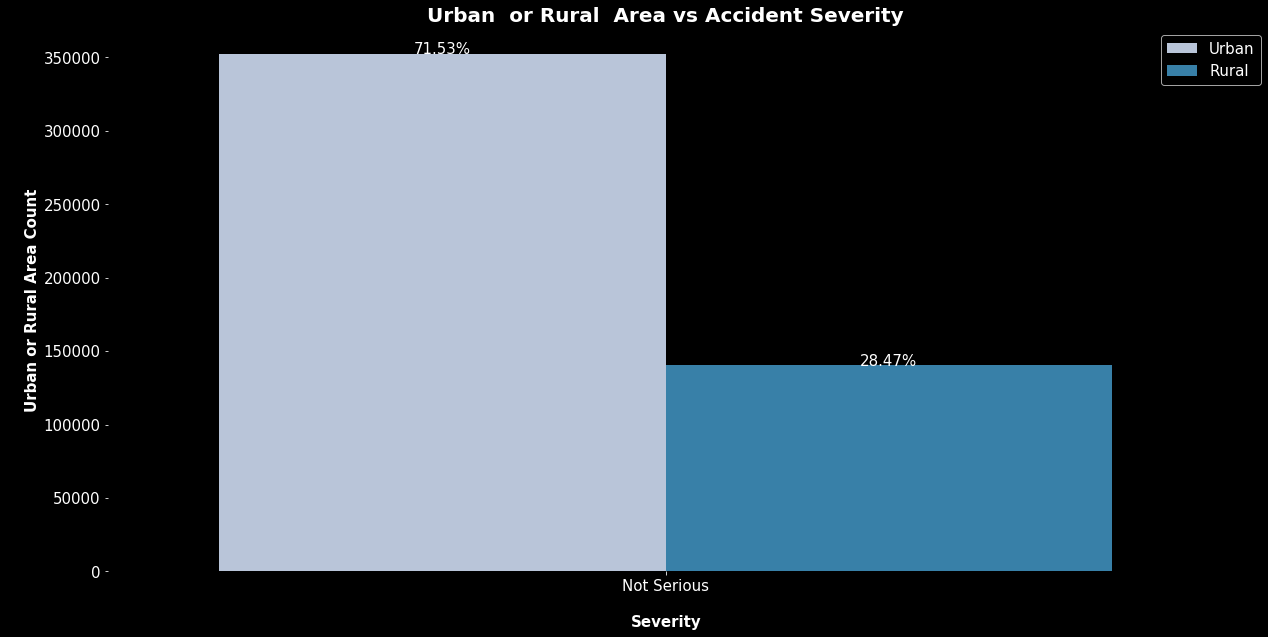

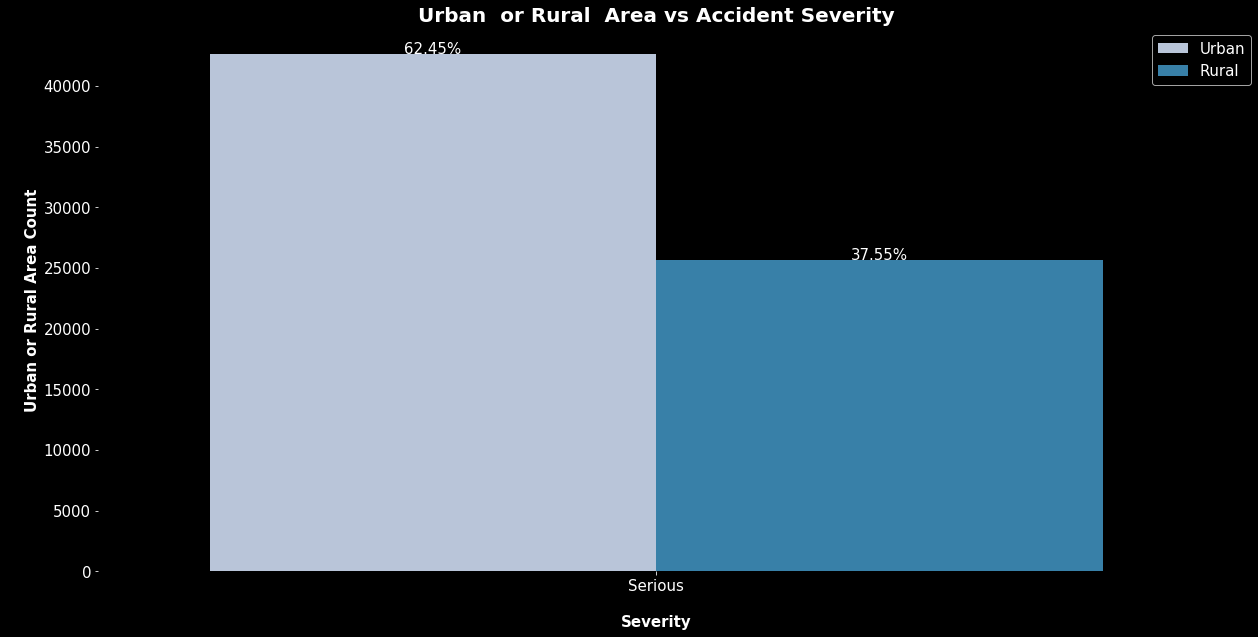

In [112]:
#urban_or_rural_area vs accident seriousness
plt.figure(figsize=(20,10))
ax = sns.countplot("accident_seriousness",  hue="urban_or_rural_area",
              palette="PuBu", data=not_serious)
plt.title("Urban  or Rural  Area vs Accident Severity",fontsize=20,fontweight="bold")
plt.style.use('dark_background')
plt.xlabel("\nSeverity", fontsize=15, fontweight="bold")
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nUrban or Rural Area Count", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('urban_or_rural_area_not_serious.png')
plt.show()

#urban_or_rural_area vs accident seriousness
plt.figure(figsize=(20,10))
ax = sns.countplot("accident_seriousness",  hue="urban_or_rural_area",
              palette="PuBu", data=serious)
plt.title("Urban  or Rural  Area vs Accident Severity",fontsize=20,fontweight="bold")
plt.style.use('dark_background')
plt.xlabel("\nSeverity", fontsize=15, fontweight="bold")
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nUrban or Rural Area Count", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('urban_or_rural_area_serious.png')
plt.show()

#### Skidding and Overturning vs Seriousness

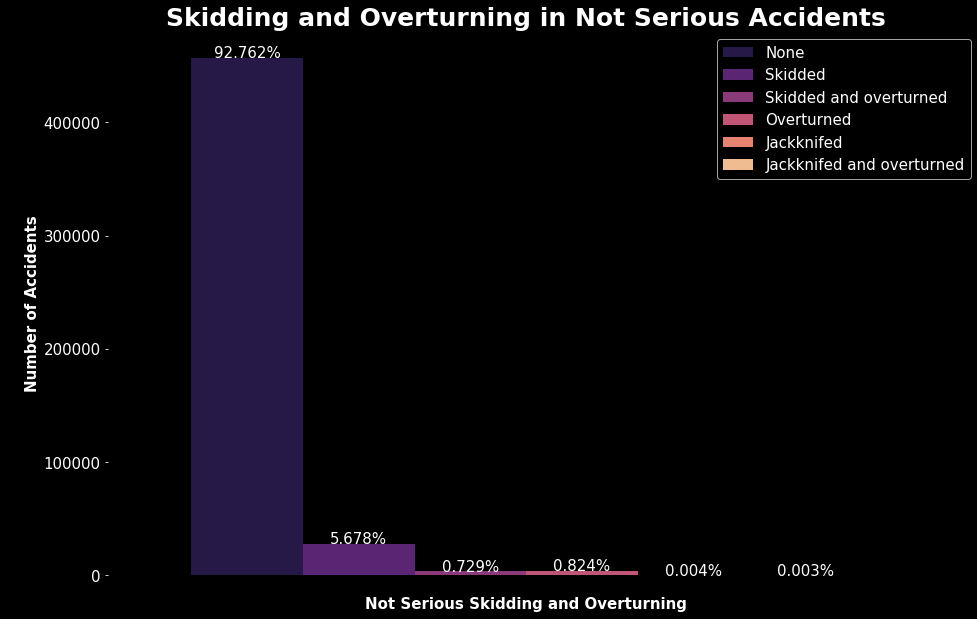

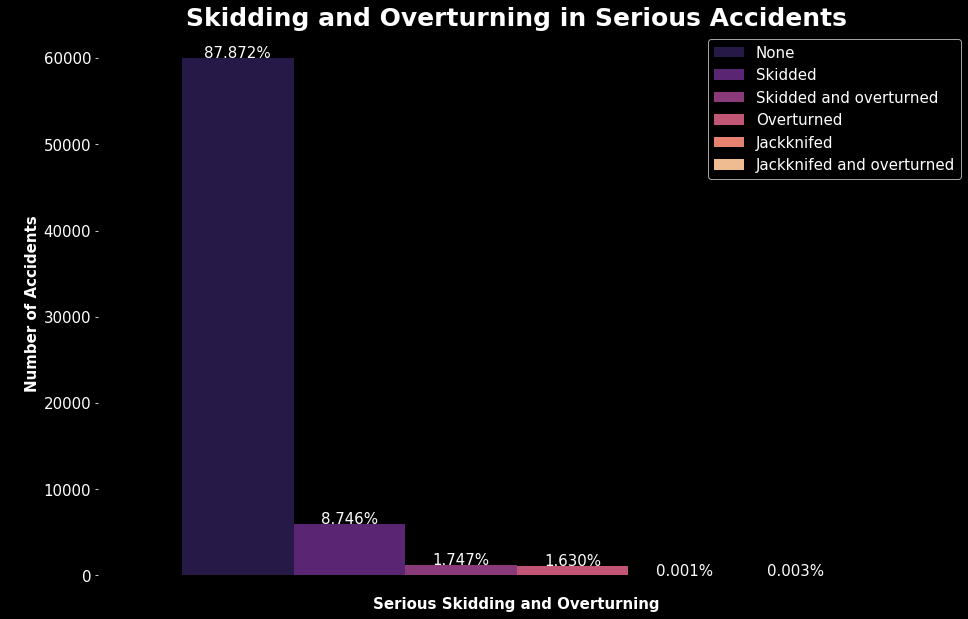

In [116]:
#Not Serious Accident
sao_order=["None", "Skidded", "Skidded and overturned", "Overturned", "Jackknifed", 
           "Jackknifed and overturned"]

plt.figure(figsize=(15,10))
ax = sns.countplot("accident_seriousness", hue="skidding_and_overturning", hue_order=sao_order,
              palette="magma", data=not_serious)
plt.style.use('dark_background')
plt.title("Skidding and Overturning in Not Serious Accidents",fontsize=25,fontweight="bold")
plt.xlabel("\nNot Serious Skidding and Overturning", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold") 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('skidding_and_overturning_not_serious.png')
plt.show()


#Serious Accident Manuevers
plt.figure(figsize=(15,10))
ax= sns.countplot("accident_seriousness", hue="skidding_and_overturning", hue_order=sao_order,
              palette="magma", data=serious)
plt.style.use('dark_background')
plt.title("Skidding and Overturning in Serious Accidents",fontsize=25,fontweight="bold")
plt.xlabel("\nSerious Skidding and Overturning", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold") 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('skidding_and_overturning_serious.png')
plt.show()

#### Vehicle Leaving Carriageway vs Seriousness

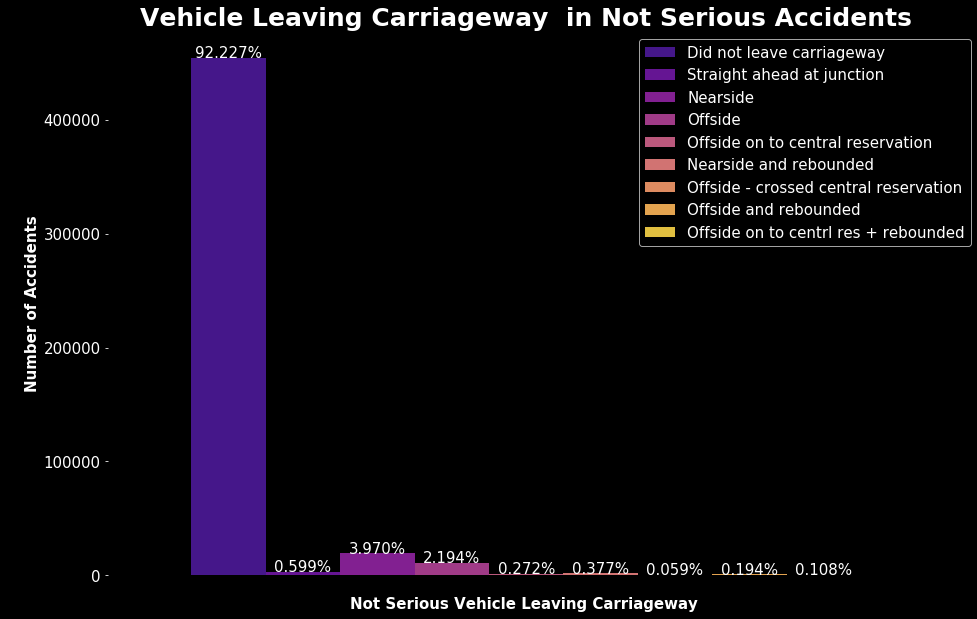

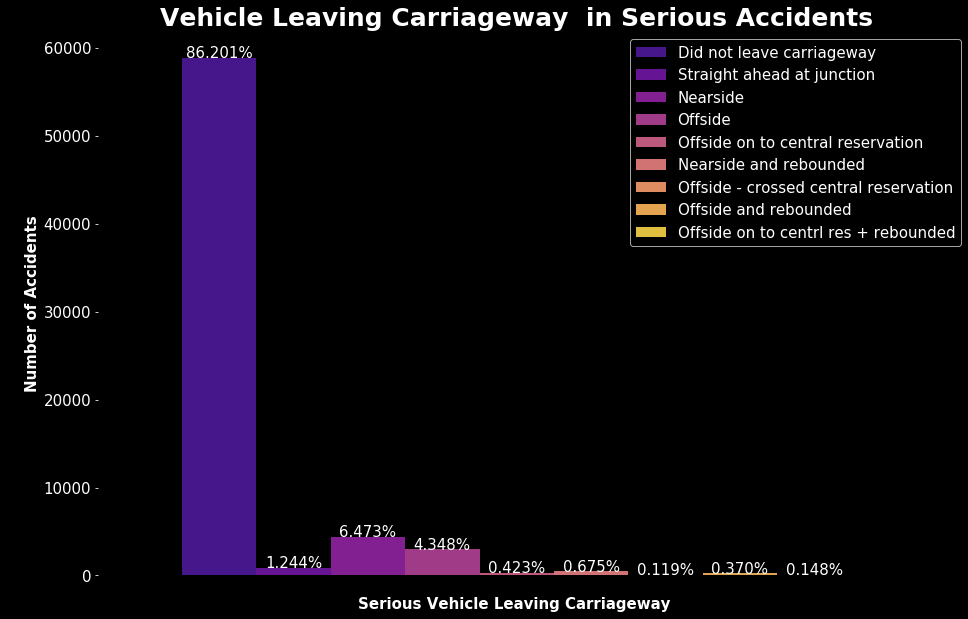

In [118]:
#Not Serious Accident Manuevers
vlc_order=["Did not leave carriageway", "Straight ahead at junction", "Nearside", 
           "Offside", "Offside on to central reservation", "Nearside and rebounded", 
           "Offside - crossed central reservation", "Offside and rebounded", 
           "Offside on to centrl res + rebounded"]

plt.figure(figsize=(15,10))
ax=sns.countplot("accident_seriousness", hue="vehicle_leaving_carriageway", hue_order=vlc_order,
              palette="plasma", data=not_serious)
plt.style.use('dark_background')
plt.title("Vehicle Leaving Carriageway  in Not Serious Accidents",fontsize=25,fontweight="bold")
plt.xlabel("\nNot Serious Vehicle Leaving Carriageway ", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents\n", fontsize=15, fontweight="bold") 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('vehicle_leaving_carriageway_not_serious.png')
plt.show()


#Serious Accident Manuevers
plt.figure(figsize=(15,10))
ax=sns.countplot("accident_seriousness", hue="vehicle_leaving_carriageway", hue_order=vlc_order,
              palette="plasma", data=serious)
plt.style.use('dark_background')
plt.title("Vehicle Leaving Carriageway  in Serious Accidents",fontsize=25,fontweight="bold")
plt.xlabel("\nSerious Vehicle Leaving Carriageway ", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents\n", fontsize=15, fontweight="bold") 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('vehicle_leaving_carriageway_serious.png')
plt.show()

#### Sex of Driver vs Seriousness

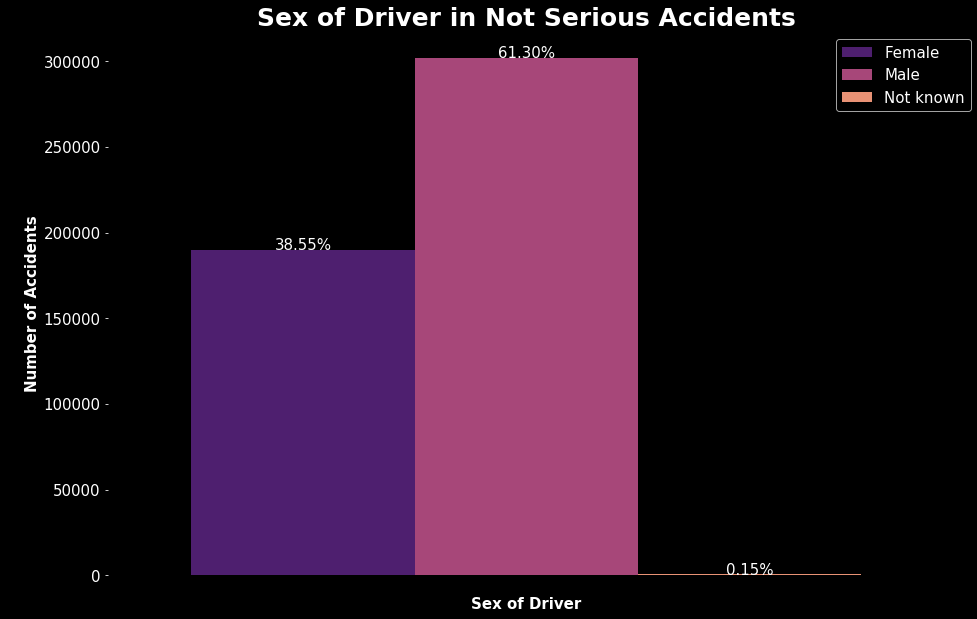

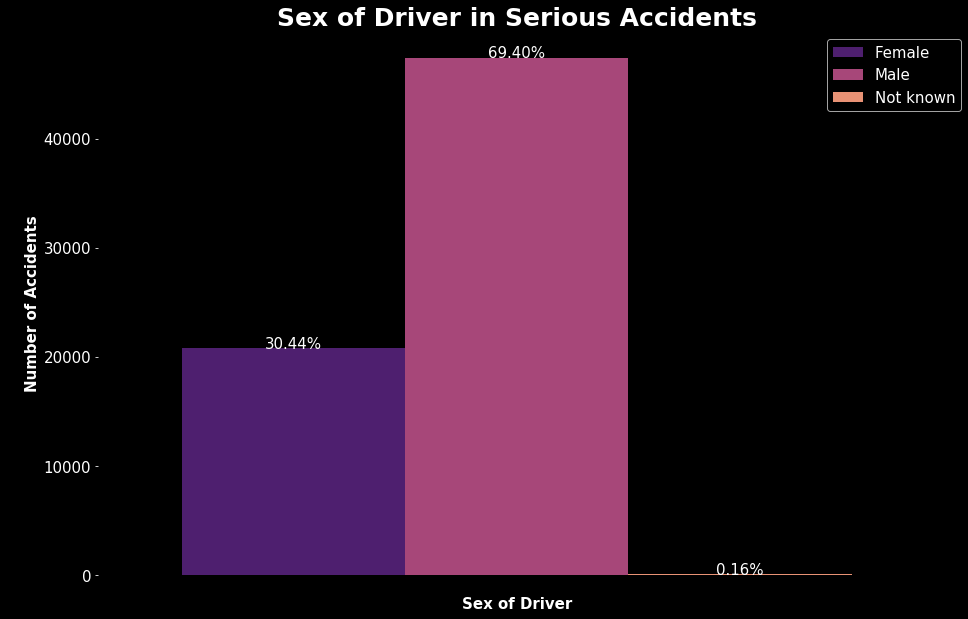

In [121]:
#sex_of_driver
sod_order=["Female", "Male", "Not known"]
plt.figure(figsize=(15,10))
ax=sns.countplot("accident_seriousness", hue="sex_of_driver", hue_order=sod_order,
              palette="magma", data=not_serious)
plt.style.use('dark_background')
plt.title("Sex of Driver in Not Serious Accidents",fontsize=25,fontweight="bold")
plt.xlabel("\nSex of Driver", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold") 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('sex_of_driver_not_serious.png')
plt.show()

#sex_of_driver serious
plt.figure(figsize=(15,10))
ax=sns.countplot("accident_seriousness", hue="sex_of_driver", hue_order=sod_order,
              palette="magma", data=serious)
plt.style.use('dark_background')
plt.title("Sex of Driver in Serious Accidents",fontsize=25,fontweight="bold")
plt.xlabel("\nSex of Driver", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold") 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('sex_of_driver_serious.png')
plt.show()

In [122]:
#sex_of_driver
df['sex_of_driver'].value_counts()/df.shape[0]*100

Male         62.289645
Female       37.562262
Not known     0.148093
Name: sex_of_driver, dtype: float64

#### Vehicle Type vs Seriousness

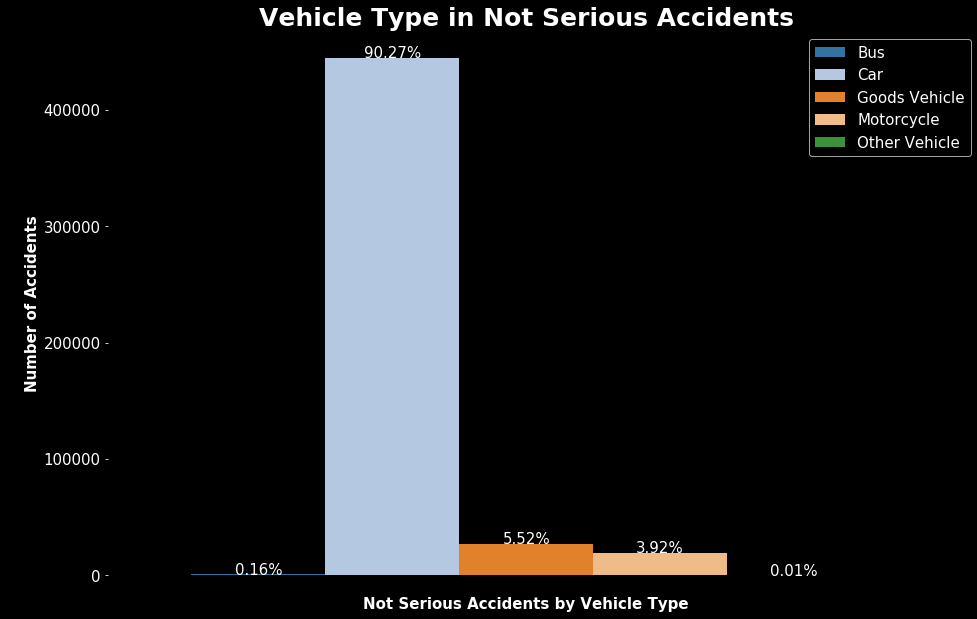

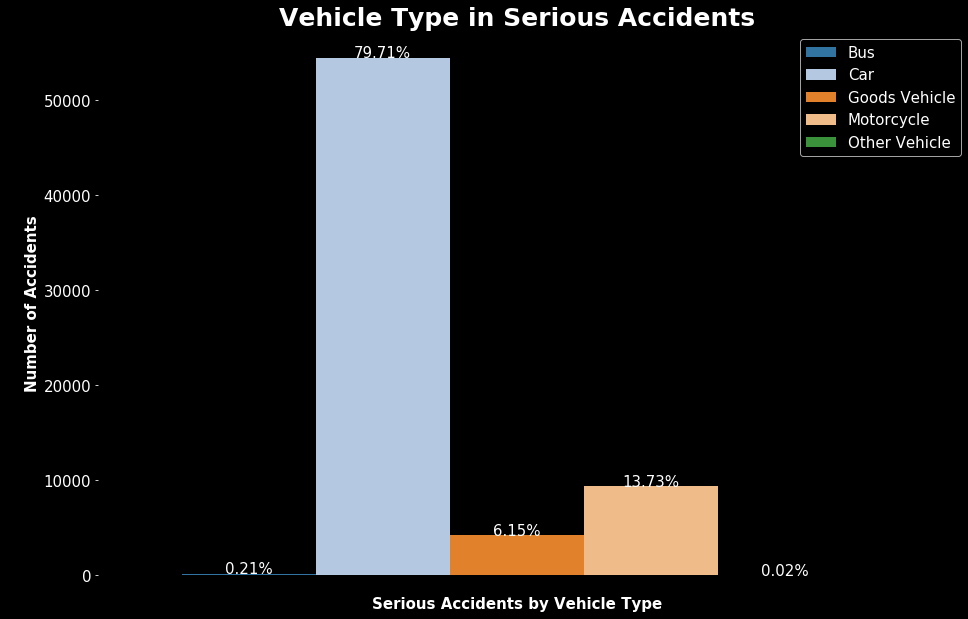

In [126]:
#Not Serious Accident Type
vt_order=['Bus', 'Car', 'Goods Vehicle', 'Motorcycle', 'Other Vehicle']

plt.figure(figsize=(15,10))
ax=sns.countplot("accident_seriousness", hue="vehicle_type", hue_order=vt_order,
                 palette="tab20", data=not_serious)
plt.style.use('dark_background')
plt.title("Vehicle Type in Not Serious Accidents",fontsize=25,fontweight="bold")
plt.xlabel("\nNot Serious Accidents by Vehicle Type", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold") 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('vehicle_type_not_serious.png')
plt.show()


#Serious Accident Type
plt.figure(figsize=(15,10))
ax=sns.countplot("accident_seriousness", hue="vehicle_type", hue_order=vt_order,
              palette="tab20", data=serious)
plt.style.use('dark_background')
plt.title("Vehicle Type in Serious Accidents",fontsize=25,fontweight="bold")
plt.xlabel("\nSerious Accidents by Vehicle Type", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold") 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('vehicle_type_serious.png')
plt.show()

#### Vehicle Manoeuvres

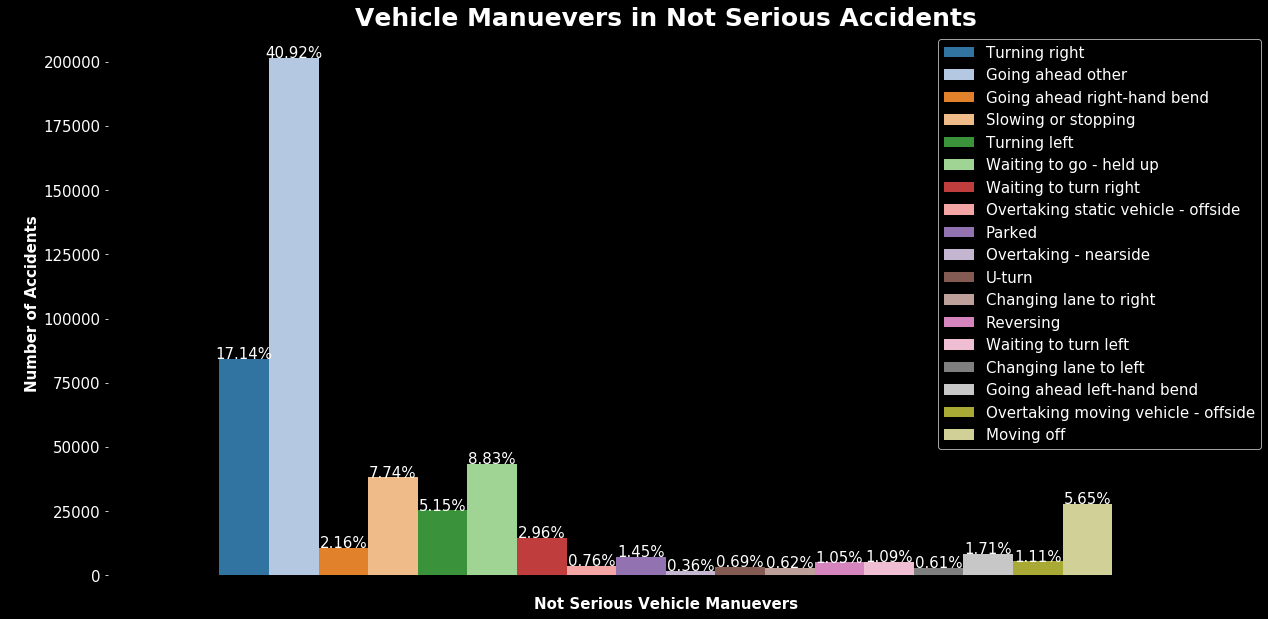

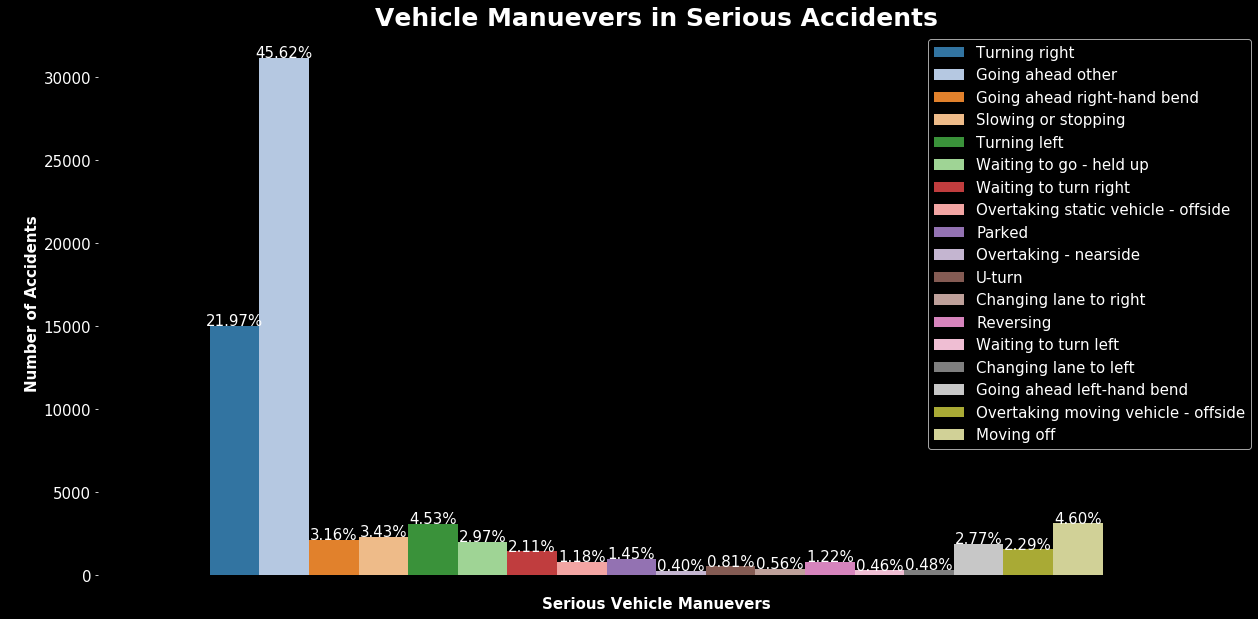

In [128]:
#Not Serious Accident Manuevers

vm_order=['Turning right', 'Going ahead other', 'Going ahead right-hand bend',
          'Slowing or stopping', 'Turning left', 'Waiting to go - held up',
          'Waiting to turn right', 'Overtaking static vehicle - offside' ,
          'Parked', 'Overtaking - nearside', 'U-turn', 'Changing lane to right', 
          'Reversing', 'Waiting to turn left', 'Changing lane to left',
          'Going ahead left-hand bend', 'Overtaking moving vehicle - offside', 'Moving off']

plt.figure(figsize=(20,10))
ax=sns.countplot("accident_seriousness", hue="vehicle_manoeuvre", hue_order=vm_order,
              palette="tab20", data=not_serious)
plt.style.use('dark_background')
plt.title("Vehicle Manuevers in Not Serious Accidents",fontsize=25,fontweight="bold")
plt.xlabel("\nNot Serious Vehicle Manuevers", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold") 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('vehicle_manoeuvre_not_serious.png')
plt.show()


#Serious Accident Manuevers
plt.figure(figsize=(20,10))
ax=sns.countplot("accident_seriousness", hue="vehicle_manoeuvre",hue_order=vm_order,
              palette="tab20", data=serious)
plt.style.use('dark_background')
plt.title("Vehicle Manuevers in Serious Accidents",fontsize=25,fontweight="bold")
plt.xlabel("\nSerious Vehicle Manuevers", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold") 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('vehicle_manoeuvre_serious.png')
plt.show()

#### Driver Home Type Area

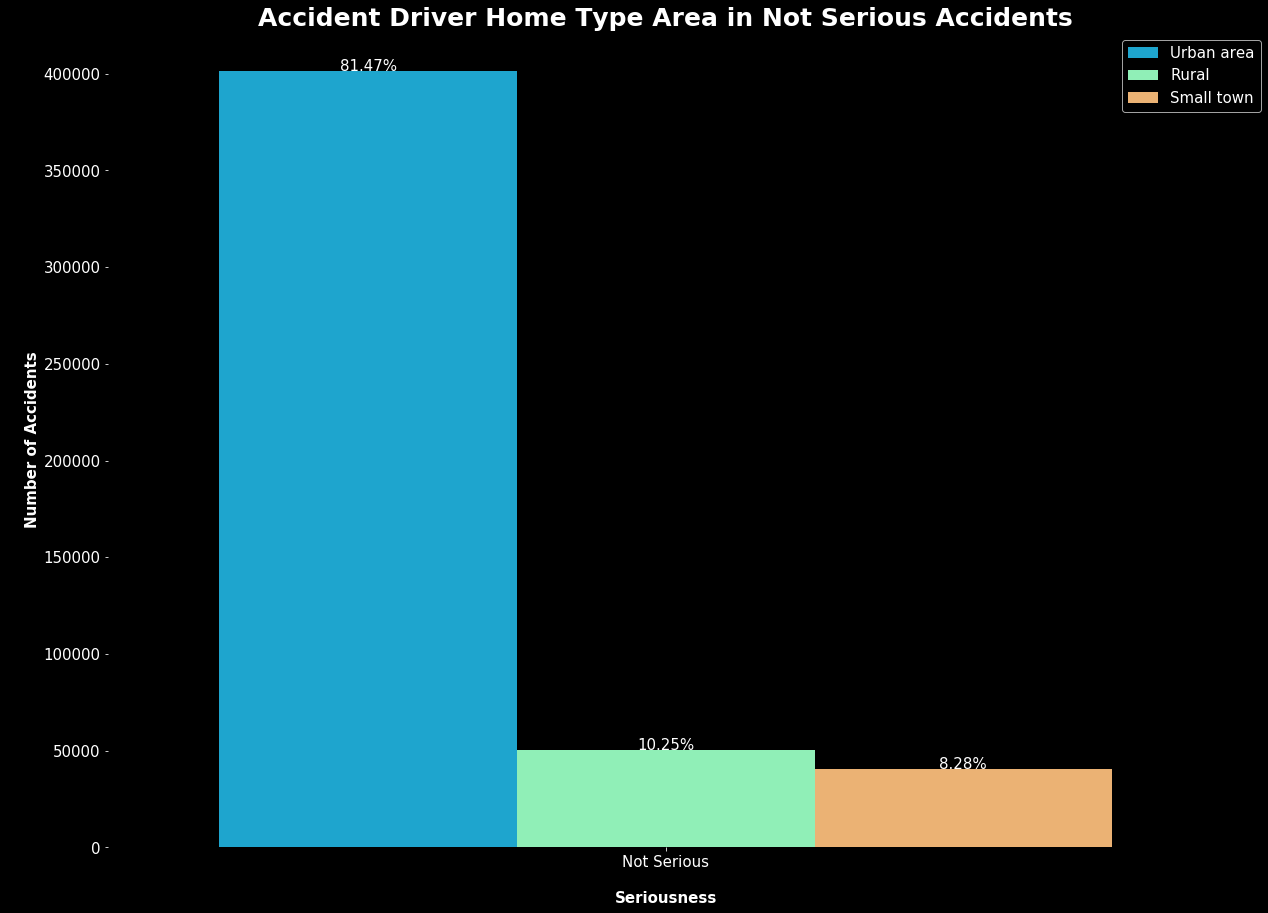

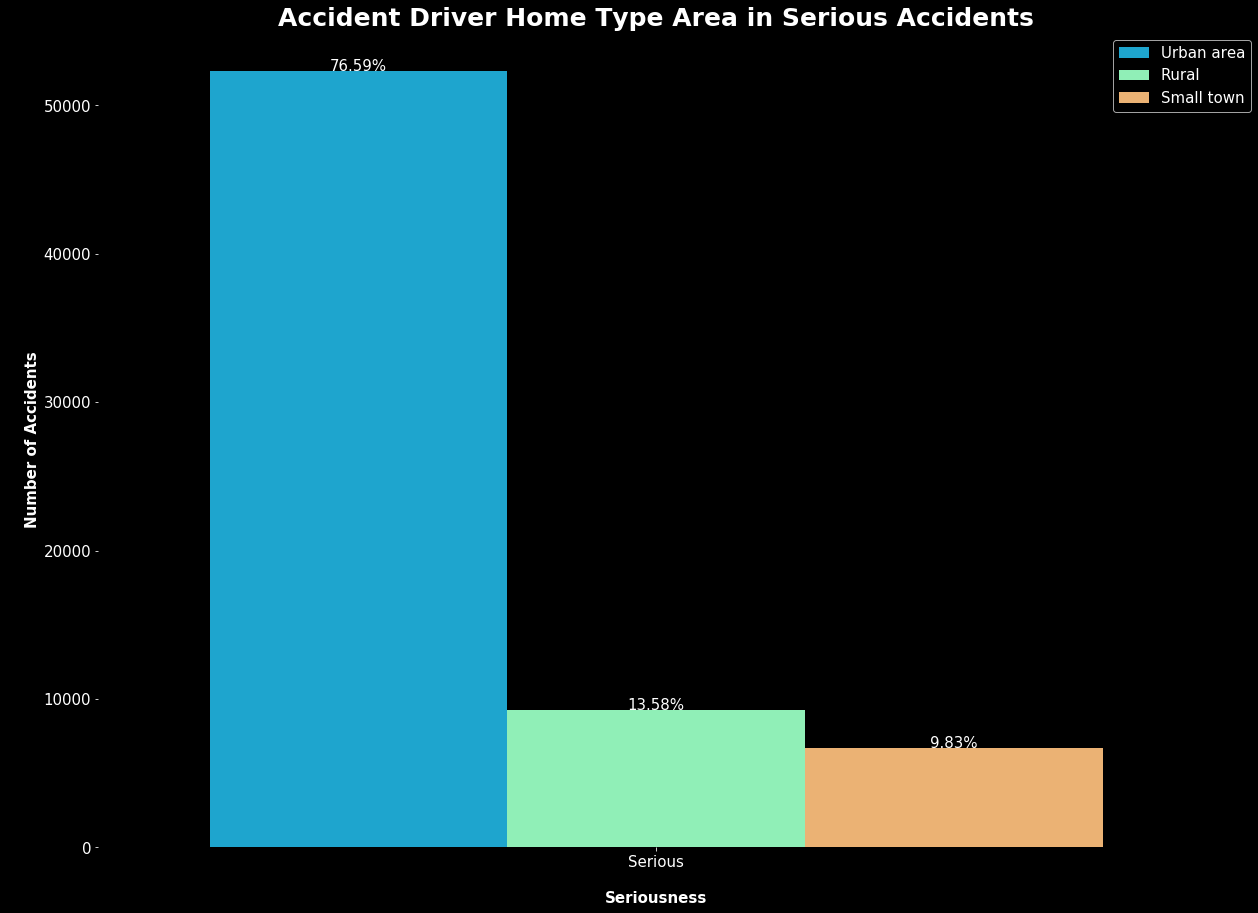

In [130]:
#driver_home_area_type
dhoa_order=['Urban area', 'Rural', 'Small town']
#Serious Accident Driver Home Type Area
plt.figure(figsize=(20,15))
ax= sns.countplot("accident_seriousness", hue="driver_home_area_type", hue_order=dhoa_order,
              palette="rainbow", data=not_serious)

plt.style.use('dark_background')
plt.title("Accident Driver Home Type Area in Not Serious Accidents",fontsize=25,fontweight="bold")
plt.xlabel("\nSeriousness", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('driver_home_area_type_not_serious.png')
plt.show()


#driver_home_area_type

#Serious Accident Driver Home Type Area
plt.figure(figsize=(20,15))
ax= sns.countplot("accident_seriousness", hue="driver_home_area_type", hue_order=dhoa_order,
              palette="rainbow", data=serious)

plt.style.use('dark_background')
plt.title("Accident Driver Home Type Area in Serious Accidents",fontsize=25,fontweight="bold")
plt.xlabel("\nSeriousness", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('driver_home_area_type_serious.png')
plt.show()


#### Age Band of Driver

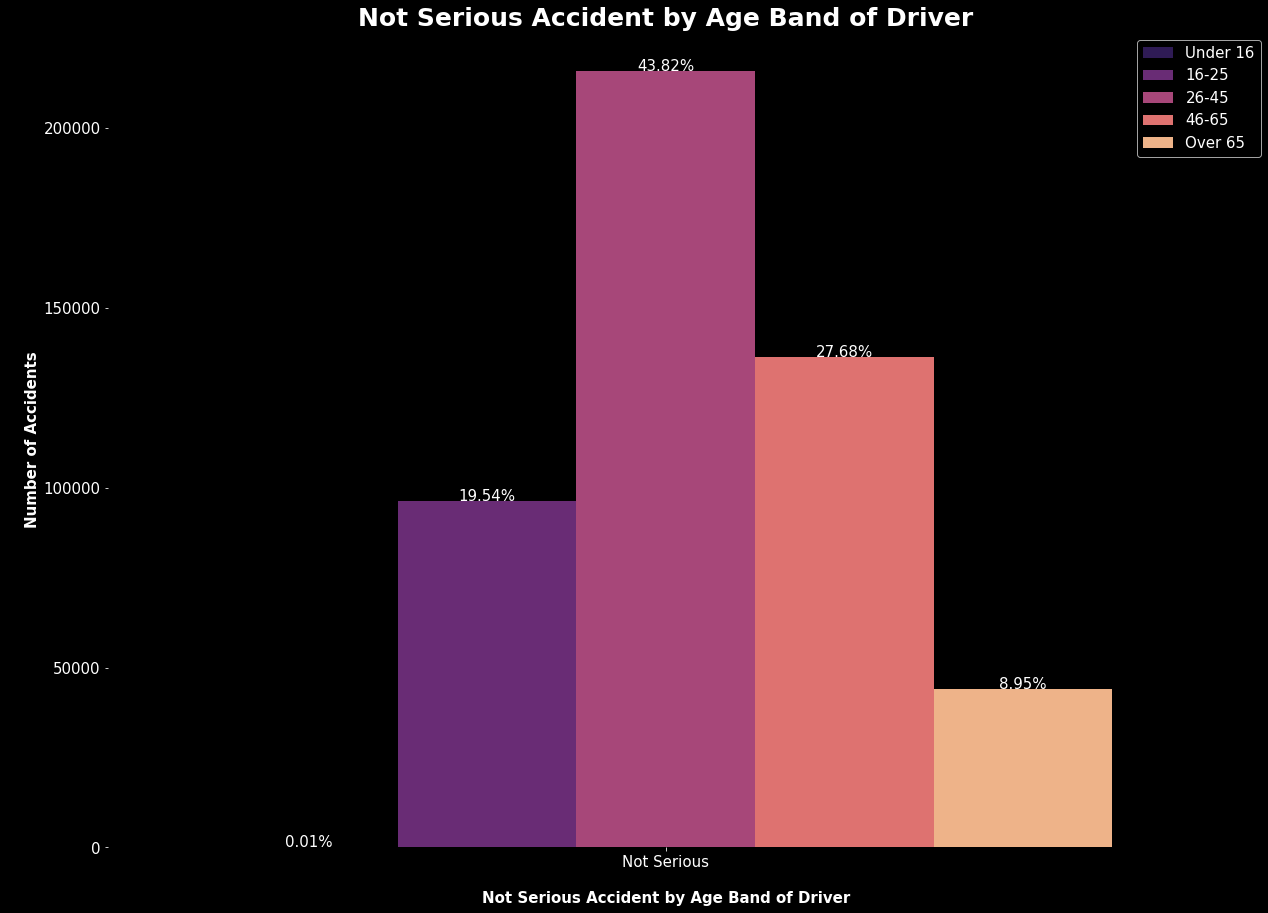

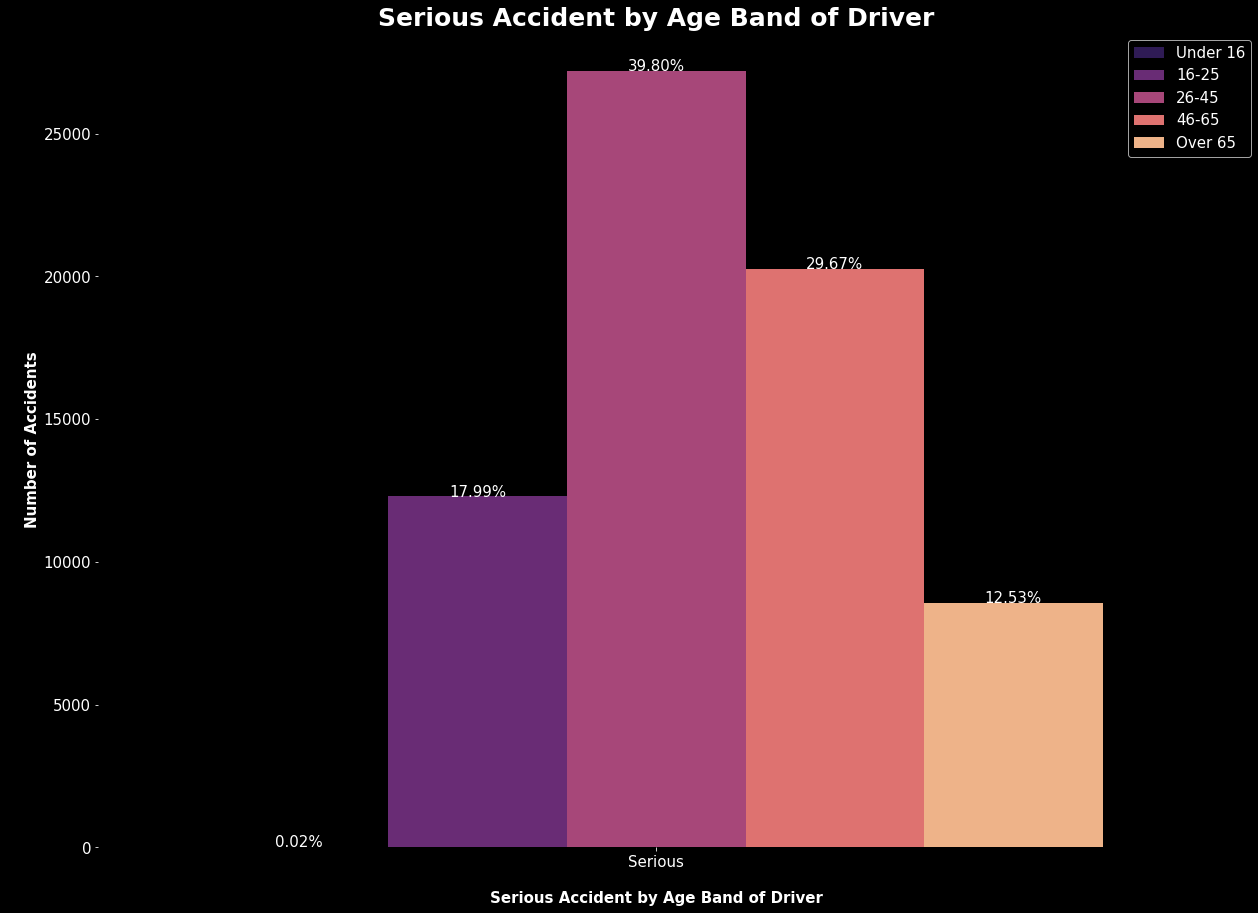

In [131]:
#age_band_of_driver
abod_order=['Under 16', '16-25', '26-45', '46-65','Over 65']
#Not Serious Accident age_band_of_driver
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="age_band_of_driver", hue_order=abod_order,
              palette="magma", data=not_serious)

plt.style.use('dark_background')
plt.title("Not Serious Accident by Age Band of Driver",fontsize=25,fontweight="bold")
plt.xlabel("\nNot Serious Accident by Age Band of Driver", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('age_band_of_driver_not_serious.png')
plt.show()


#Serious Accident age_band_of_driver
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="age_band_of_driver", hue_order=abod_order,
              palette="magma", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accident by Age Band of Driver",fontsize=25,fontweight="bold")
plt.xlabel("\nSerious Accident by Age Band of Driver", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('age_band_of_driver_serious.png')
plt.show()

#### Junction Control

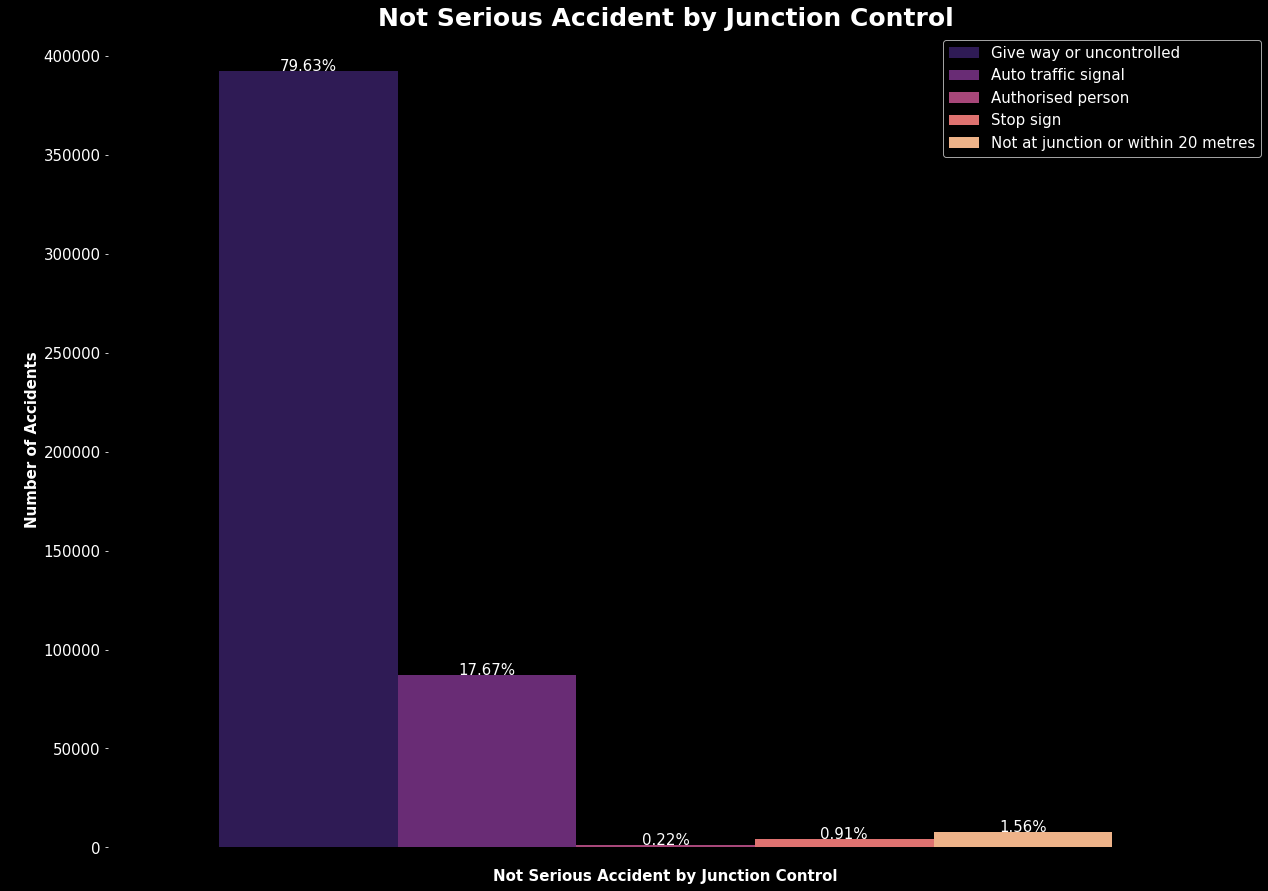

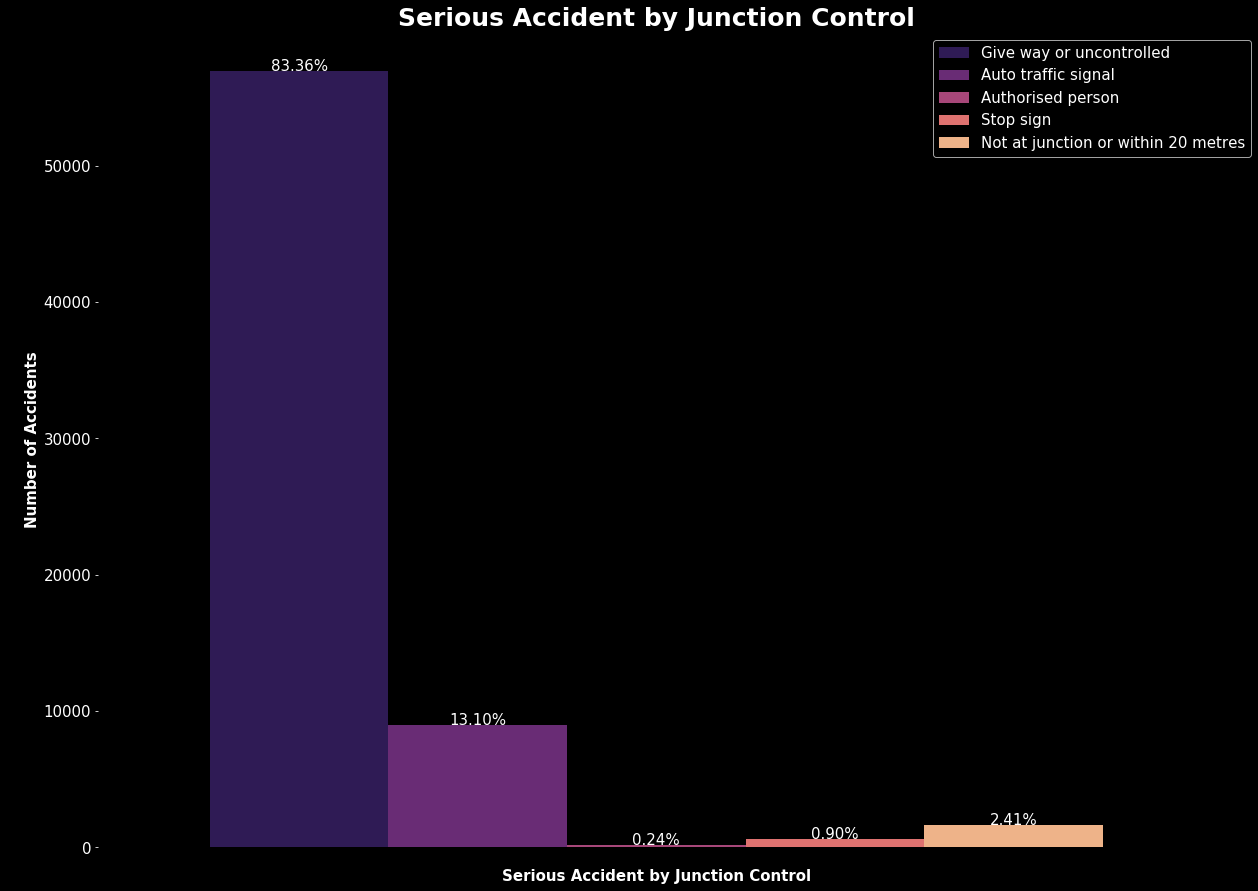

In [133]:
#junction_control
jc_order = ['Give way or uncontrolled', 'Auto traffic signal', 'Authorised person',
            'Stop sign','Not at junction or within 20 metres']
#Not Serious Accident junction_control
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="junction_control", hue_order=jc_order,
              palette="magma", data=not_serious)

plt.style.use('dark_background')
plt.title("Not Serious Accident by Junction Control",fontsize=25,fontweight="bold")
plt.xlabel("\nNot Serious Accident by Junction Control", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('junction_control_not_serious.png')
plt.show()

#Serious Accident junction_control
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="junction_control",hue_order=jc_order,
              palette="magma", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accident by Junction Control",fontsize=25,fontweight="bold")
plt.xlabel("\nSerious Accident by Junction Control", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('junction_control_serious.png')
plt.show()





#### Hit Object Off Carriageway


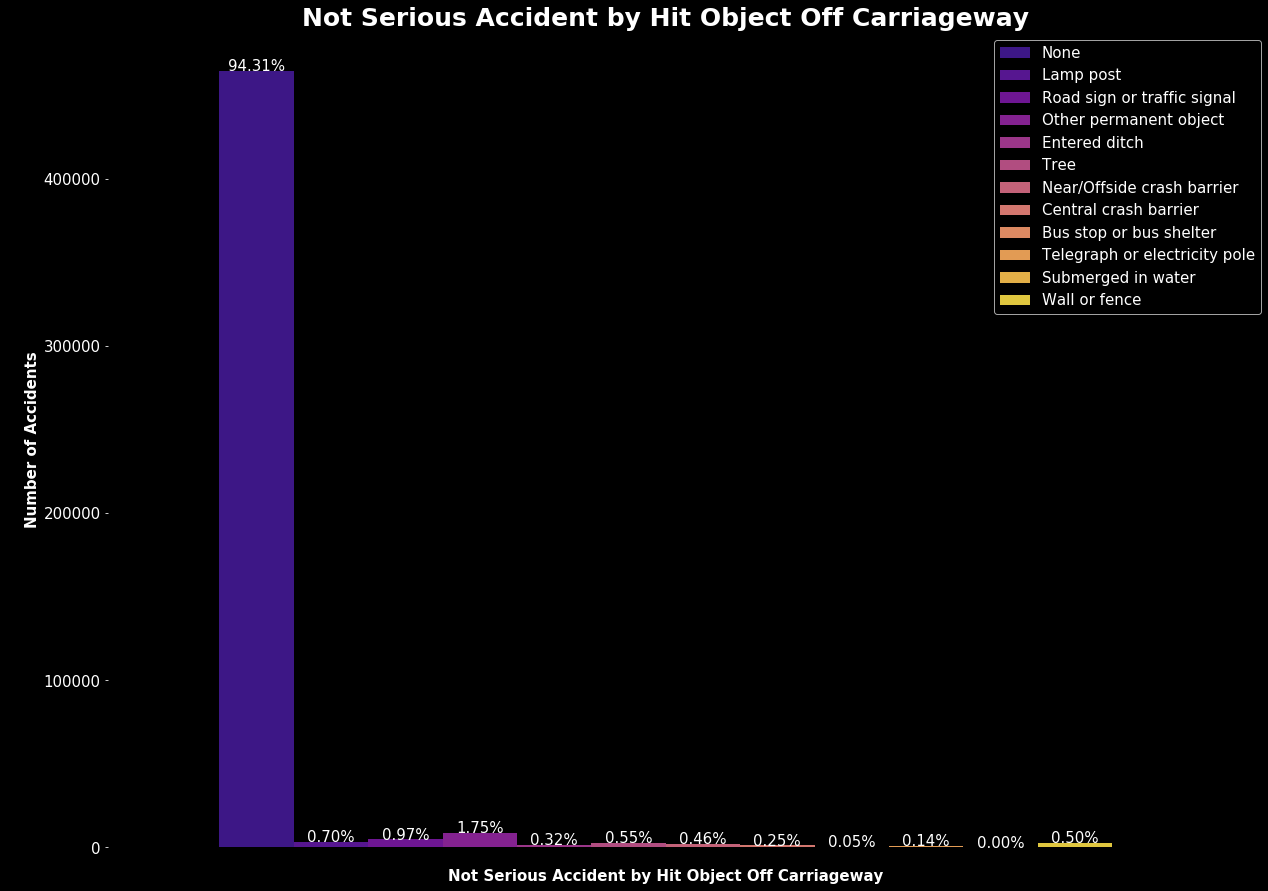

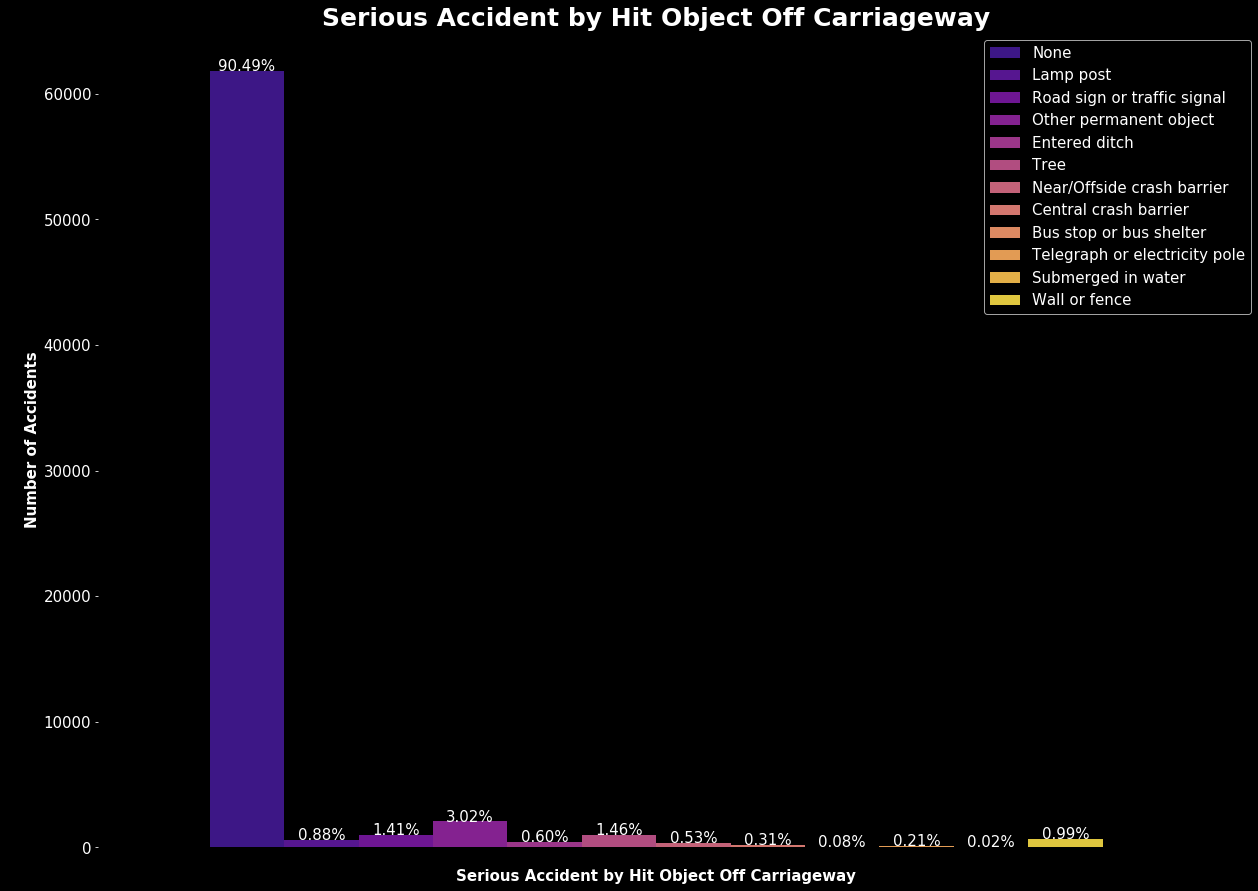

In [135]:
#hit_object_off_carriageway
hooffc_order=['None', 'Lamp post', 'Road sign or traffic signal', 'Other permanent object',
              'Entered ditch', 'Tree', 'Near/Offside crash barrier','Central crash barrier',
              'Bus stop or bus shelter', 'Telegraph or electricity pole', 'Submerged in water',
              'Wall or fence']
#Not Serious Accident hit_object_off_carriageway
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="hit_object_off_carriageway", hue_order=hooffc_order,
              palette="plasma", data=not_serious)

plt.style.use('dark_background')
plt.title("Not Serious Accident by Hit Object Off Carriageway",fontsize=25,fontweight="bold")
plt.xlabel("\nNot Serious Accident by Hit Object Off Carriageway", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('hit_object_off_carriageway_not_serious.png')
plt.show()

#Serious Accident hit_object_off_carriageway
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="hit_object_off_carriageway", hue_order=hooffc_order,
              palette="plasma", data=serious)
plt.style.use('dark_background')
plt.title("Serious Accident by Hit Object Off Carriageway",fontsize=25,fontweight="bold")
plt.xlabel("\nSerious Accident by Hit Object Off Carriageway", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('hit_object_off_carriageway_serious.png')
plt.show()

#### Hit Object In Carriageway

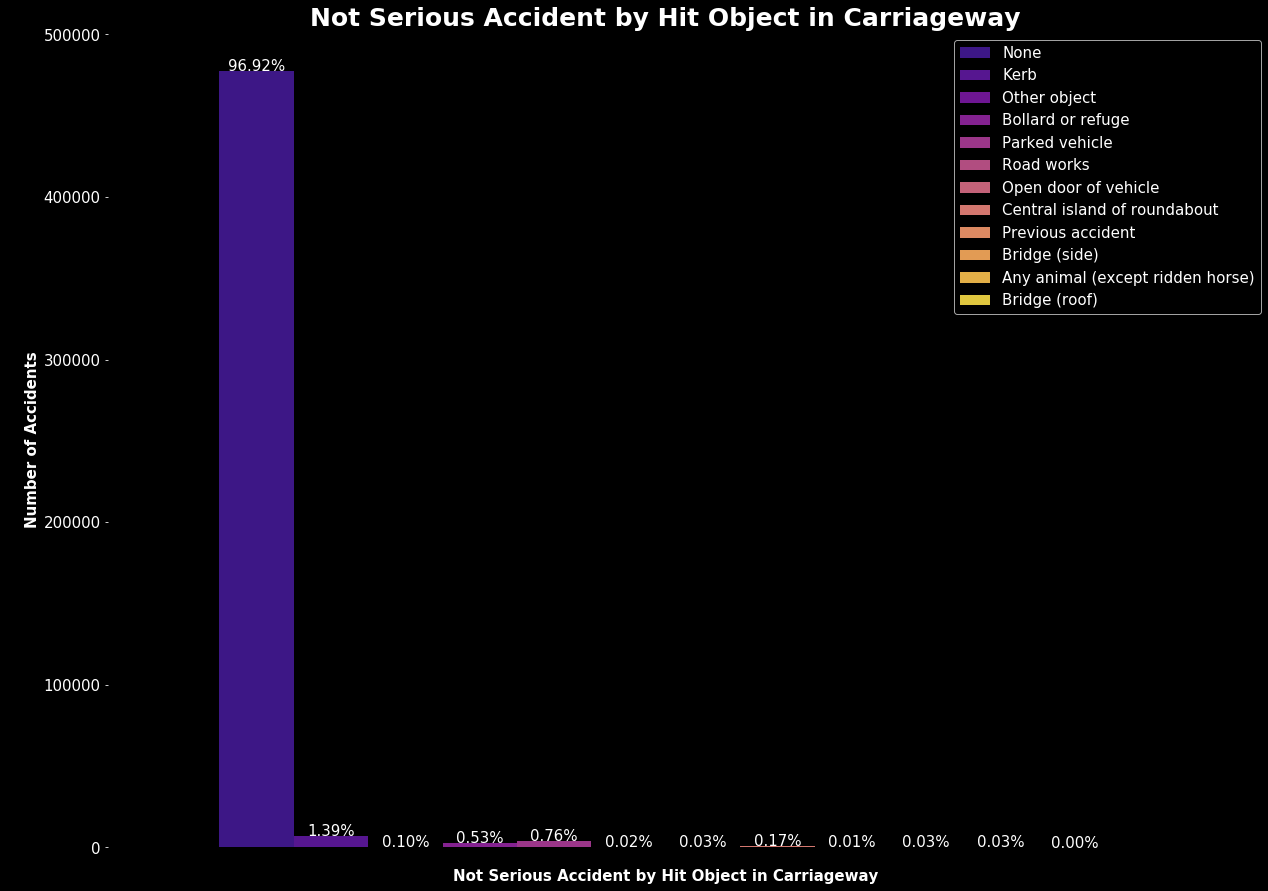

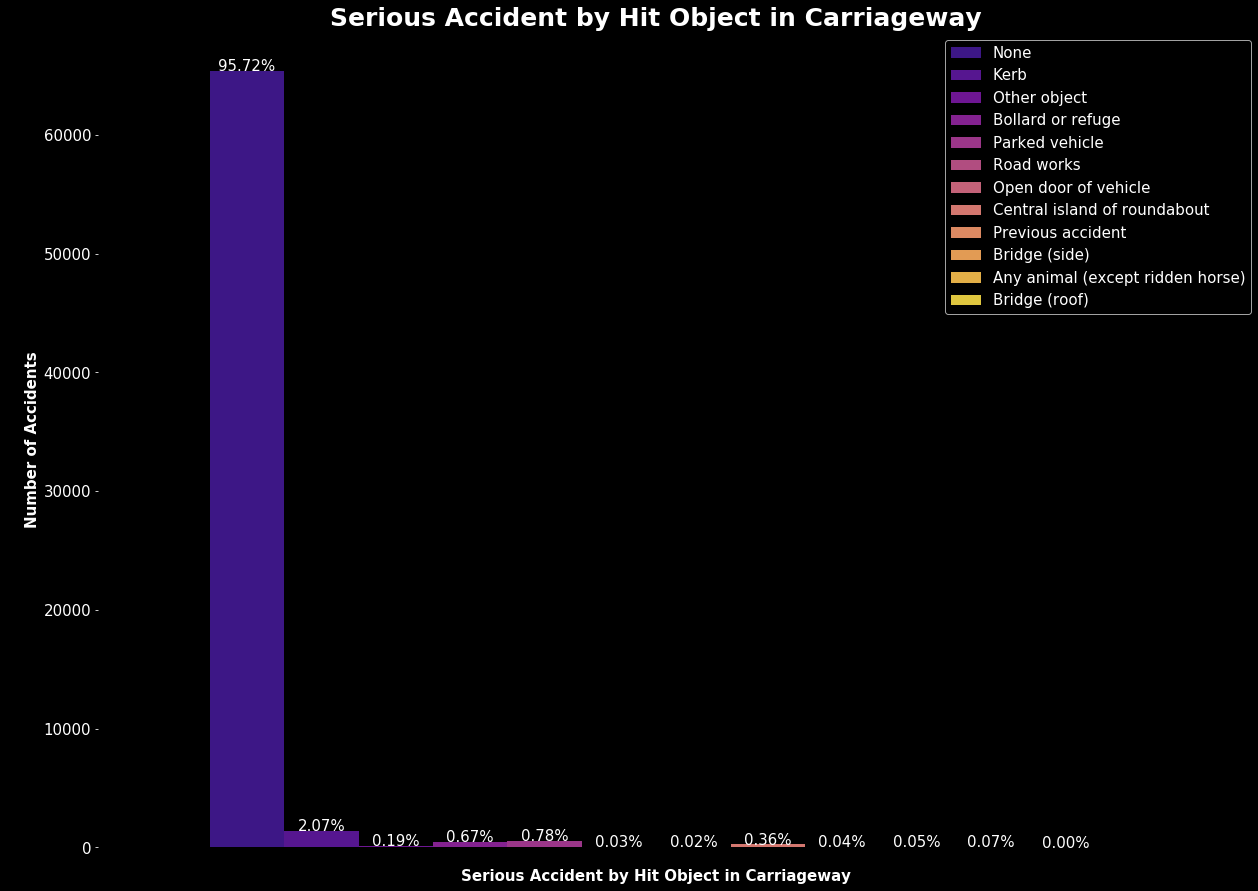

In [222]:
#hit_object_in_carriageway
hoinc_order=['None', 'Kerb', 'Other object', 'Bollard or refuge', 'Parked vehicle',
             'Road works', 'Open door of vehicle', 'Central island of roundabout',
             'Previous accident', 'Bridge (side)', 'Any animal (except ridden horse)',
             'Bridge (roof)']
#Not Serious Accident hit_object_in_carriageway
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="hit_object_in_carriageway", hue_order=hoinc_order,
              palette="plasma", data=not_serious)

plt.style.use('dark_background')
plt.title("Not Serious Accident by Hit Object in Carriageway",fontsize=25,fontweight="bold")
plt.xlabel("\nNot Serious Accident by Hit Object in Carriageway", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('hit_object_in_carriageway_not_serious.png')
plt.show()

#Serious Accident hit_object_in_carriageway
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="hit_object_in_carriageway", hue_order=hoinc_order,
              palette="plasma", data=serious)
plt.style.use('dark_background')
plt.title("Serious Accident by Hit Object in Carriageway",fontsize=25,fontweight="bold")
plt.xlabel("\nSerious Accident by Hit Object in Carriageway", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('hit_object_in_carriageway_serious.png')
plt.show()

#### Driver IMD Decile

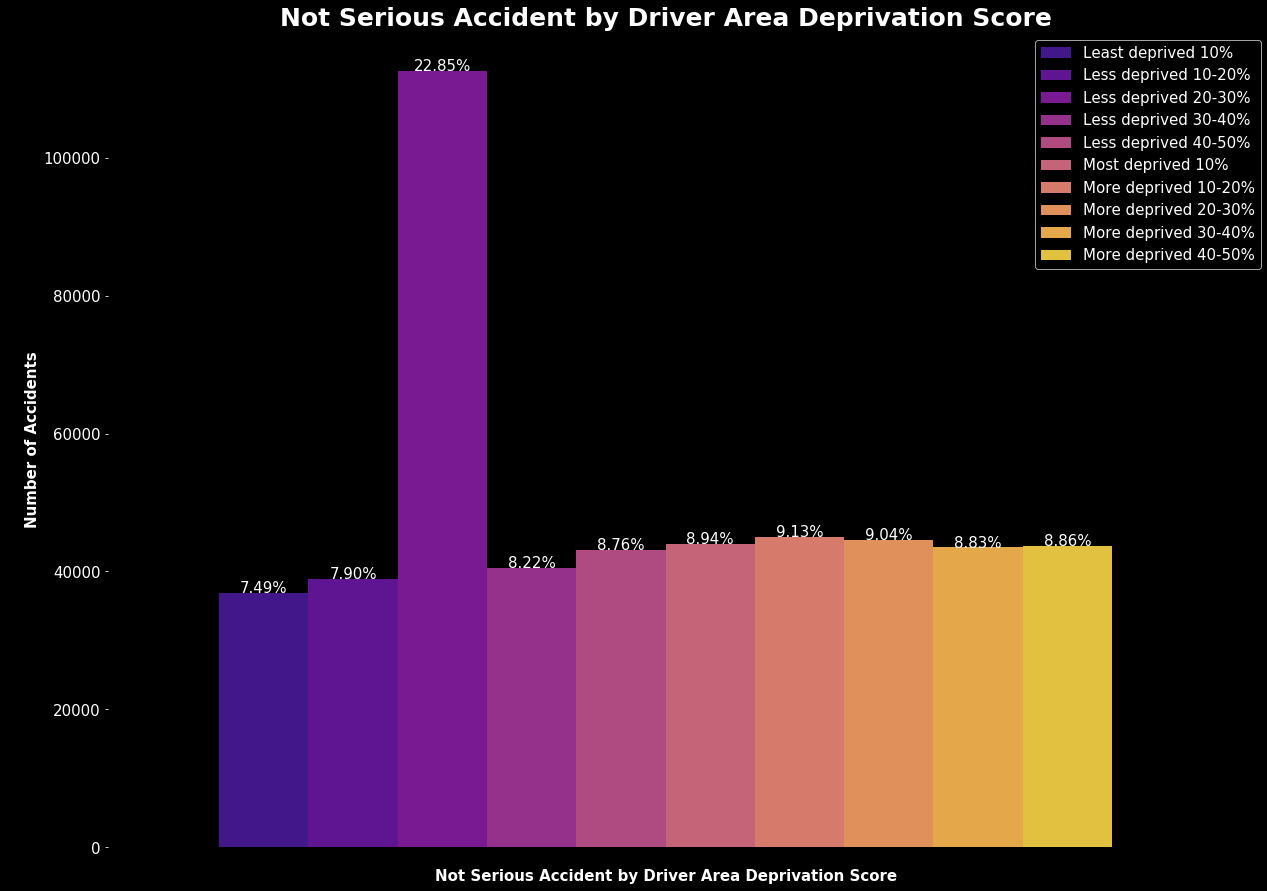

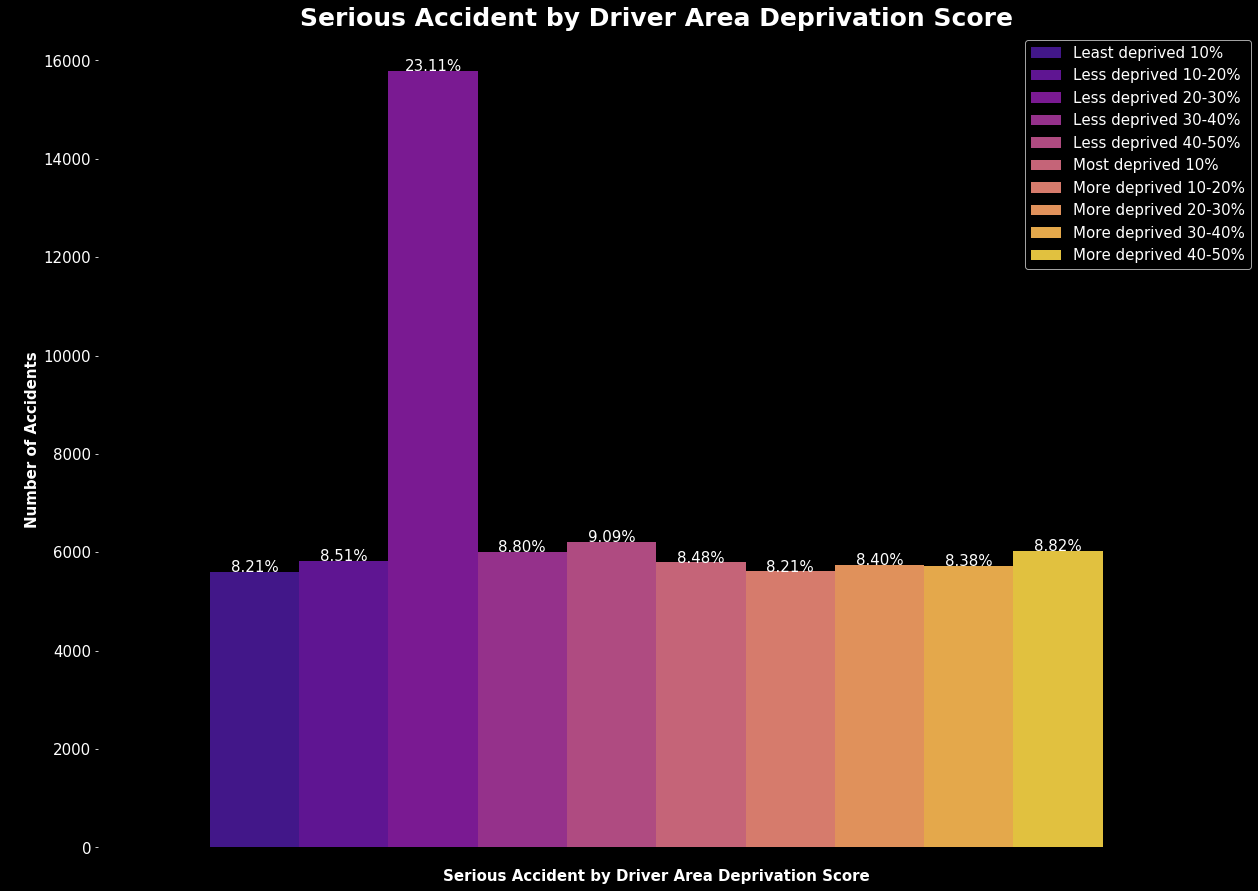

In [221]:
#driver_imd_decile
imd_order=["Least deprived 10%", "Less deprived 10-20%", "Less deprived 20-30%", 
           "Less deprived 30-40%","Less deprived 40-50%","Most deprived 10%",
           "More deprived 10-20%", "More deprived 20-30%", "More deprived 30-40%",
           "More deprived 40-50%"]
#Not Serious Accident driver_imd_decile
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="driver_imd_decile", hue_order=imd_order,
              palette="plasma", data=not_serious)

plt.style.use('dark_background')
plt.title("Not Serious Accident by Driver Area Deprivation Score",fontsize=25,fontweight="bold")
plt.xlabel("\nNot Serious Accident by Driver Area Deprivation Score", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('driver_imd_decile_not_serious.png')
plt.show()


#Serious Accident driver_imd_decile
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="driver_imd_decile", hue_order=imd_order,
              palette="plasma", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accident by Driver Area Deprivation Score",fontsize=25,fontweight="bold")
plt.xlabel("\nSerious Accident by Driver Area Deprivation Score", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('driver_imd_decile_serious.png')
plt.show()

#### Junction Detail

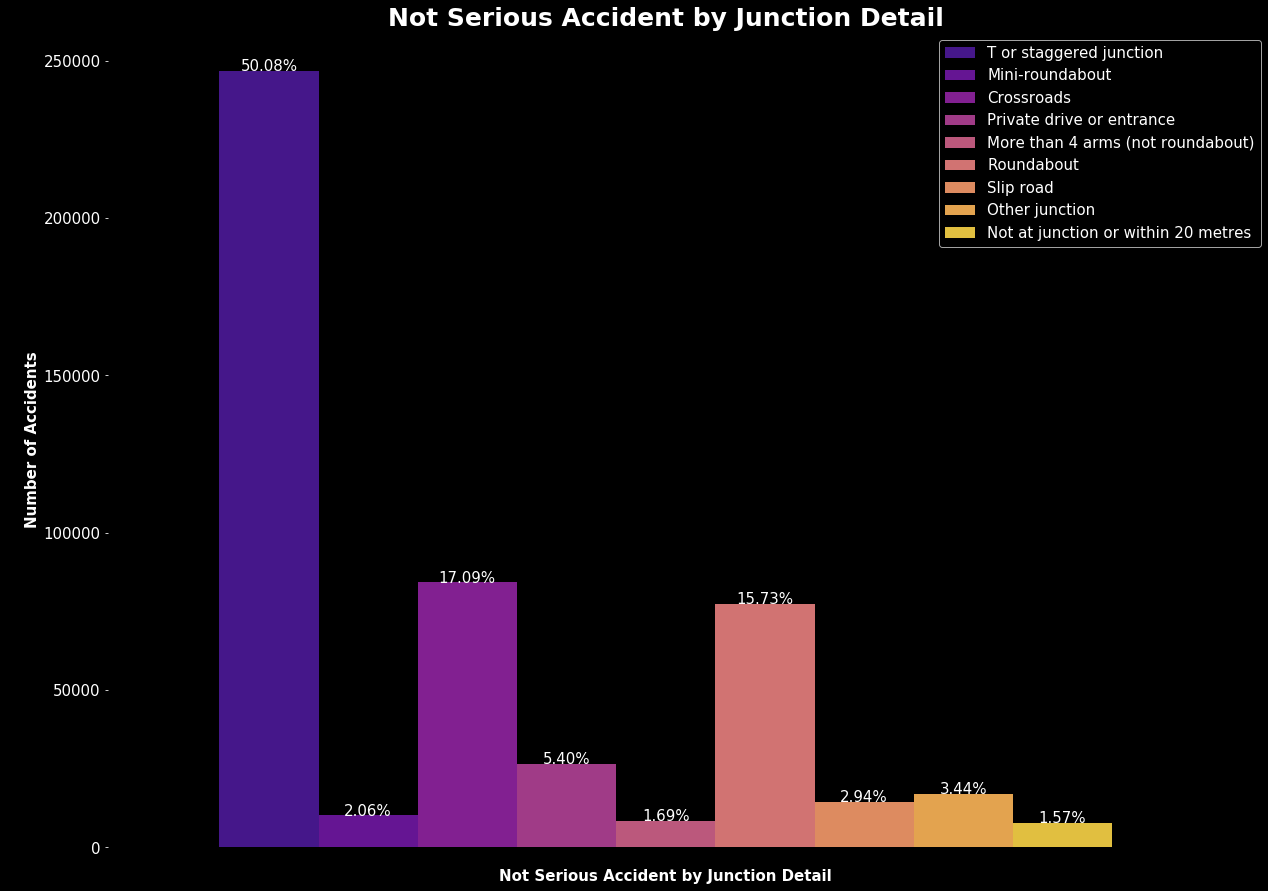

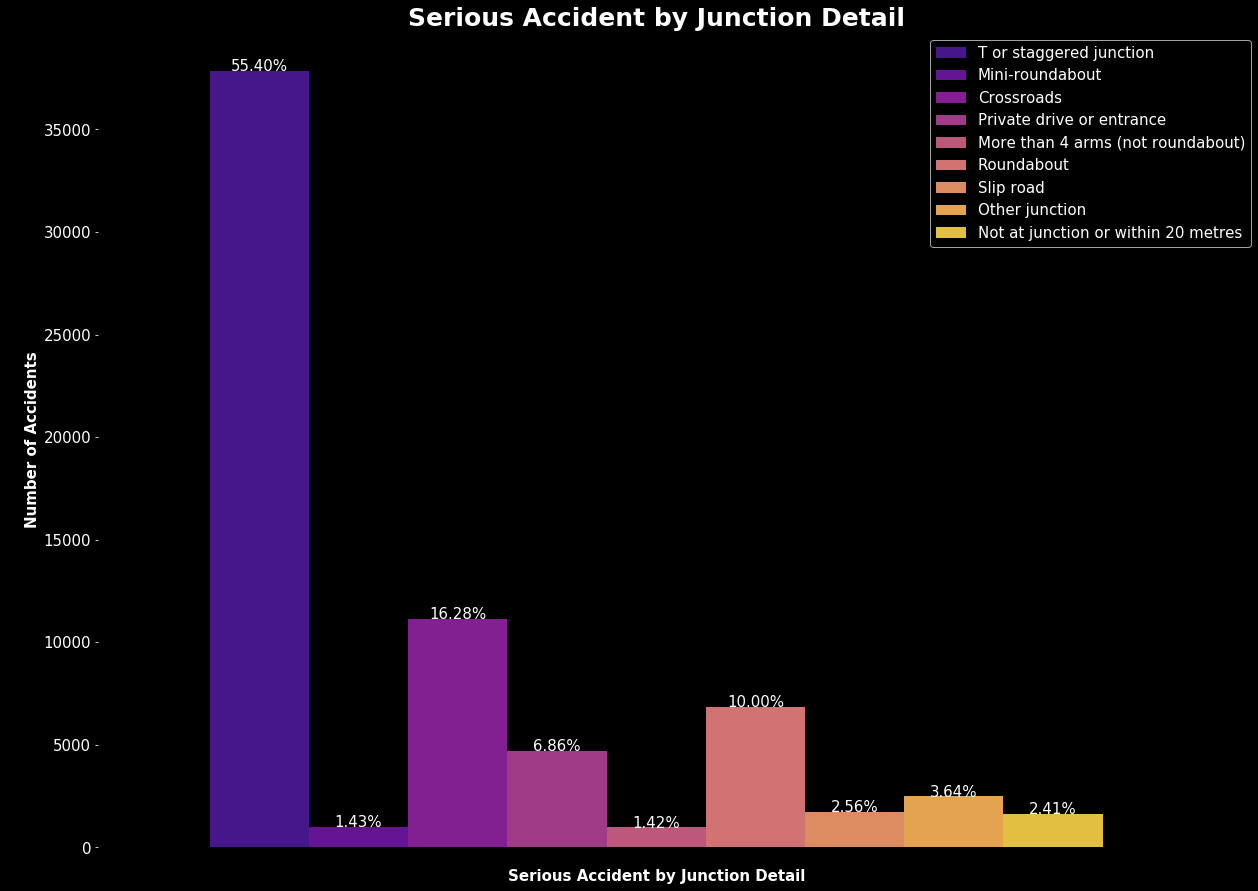

In [210]:
#junction_detail
jud_order=['T or staggered junction', 'Mini-roundabout', 'Crossroads',
           'Private drive or entrance', 'More than 4 arms (not roundabout)',
           'Roundabout', 'Slip road', 'Other junction','Not at junction or within 20 metres']
#Not Serious Accident junction_detail
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="junction_detail", hue_order=jud_order,
              palette="plasma", data=not_serious)

plt.style.use('dark_background')
plt.title("Not Serious Accident by Junction Detail",fontsize=25,fontweight="bold")
plt.xlabel("\nNot Serious Accident by Junction Detail", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('junction_detail_not_serious.png')
plt.show()


#Serious Accident junction_detail
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="junction_detail", hue_order=jud_order,
              palette="plasma", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accident by Junction Detail",fontsize=25,fontweight="bold")
plt.xlabel("\nSerious Accident by Junction Detail", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('junction_detail_serious.png')
plt.show()

#### Junction Location

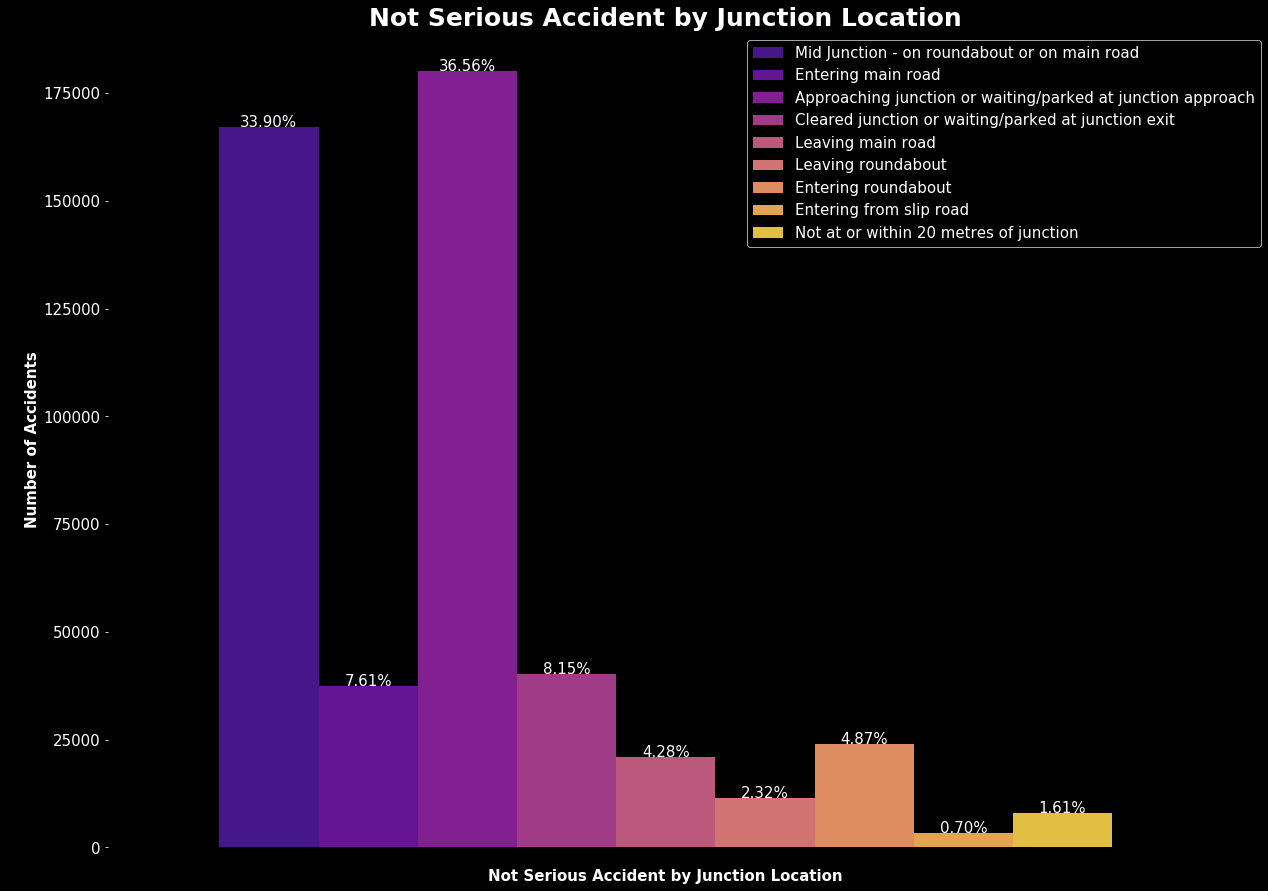

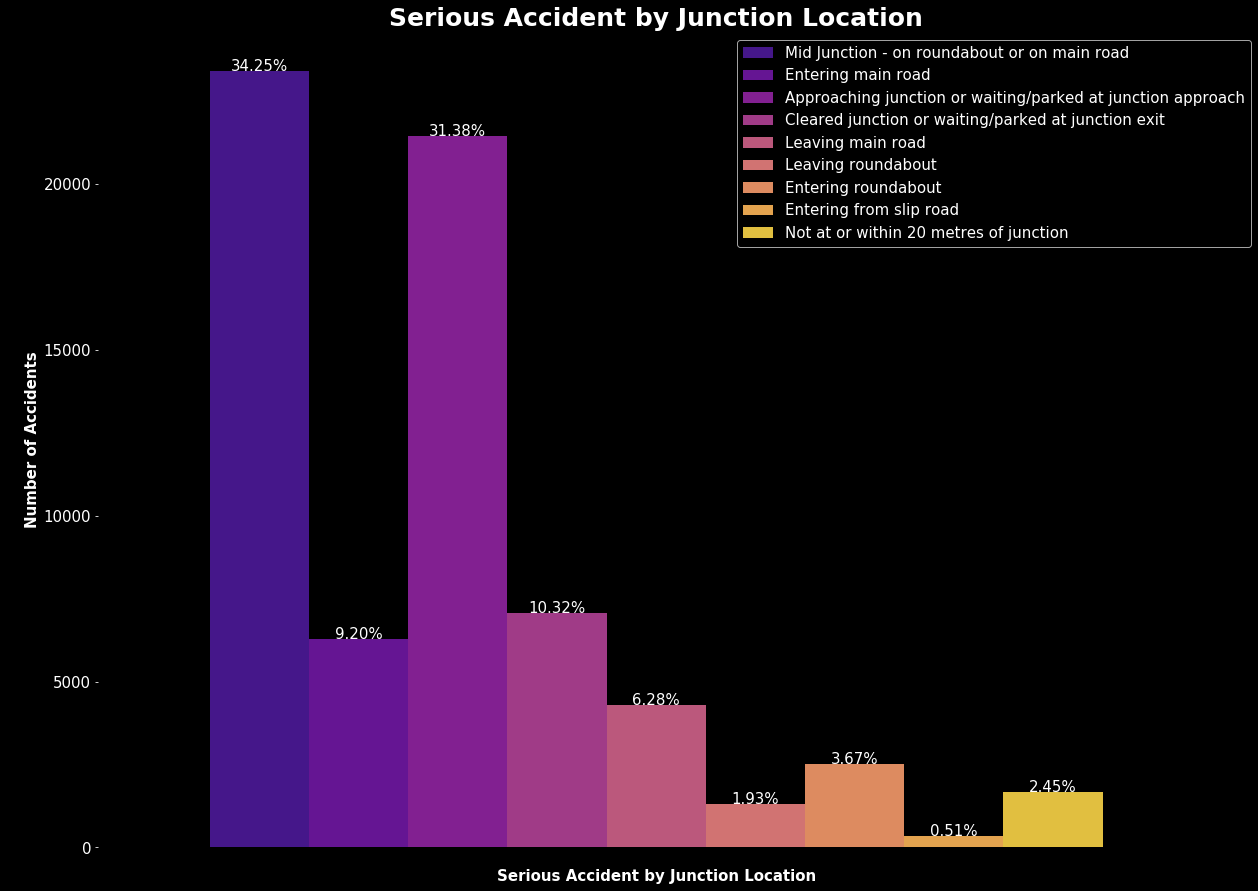

In [211]:
#junction_location
jul_order=['Mid Junction - on roundabout or on main road', 'Entering main road',
           'Approaching junction or waiting/parked at junction approach',
           'Cleared junction or waiting/parked at junction exit', 'Leaving main road',
           'Leaving roundabout', 'Entering roundabout', 'Entering from slip road',
           'Not at or within 20 metres of junction']
#Not Serious Accident junction_location
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="junction_location", hue_order=jul_order,
              palette="plasma", data=not_serious)

plt.style.use('dark_background')
plt.title("Not Serious Accident by Junction Location",fontsize=25,fontweight="bold")
plt.xlabel("\nNot Serious Accident by Junction Location", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('junction_location_not_serious.png')
plt.show()


#Serious Accident junction_location
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="junction_location", hue_order=jul_order,
              palette="plasma", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accident by Junction Location",fontsize=25,fontweight="bold")
plt.xlabel("\nSerious Accident by Junction Location", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('junction_location_serious.png')
plt.show()

#### Propulsion Code

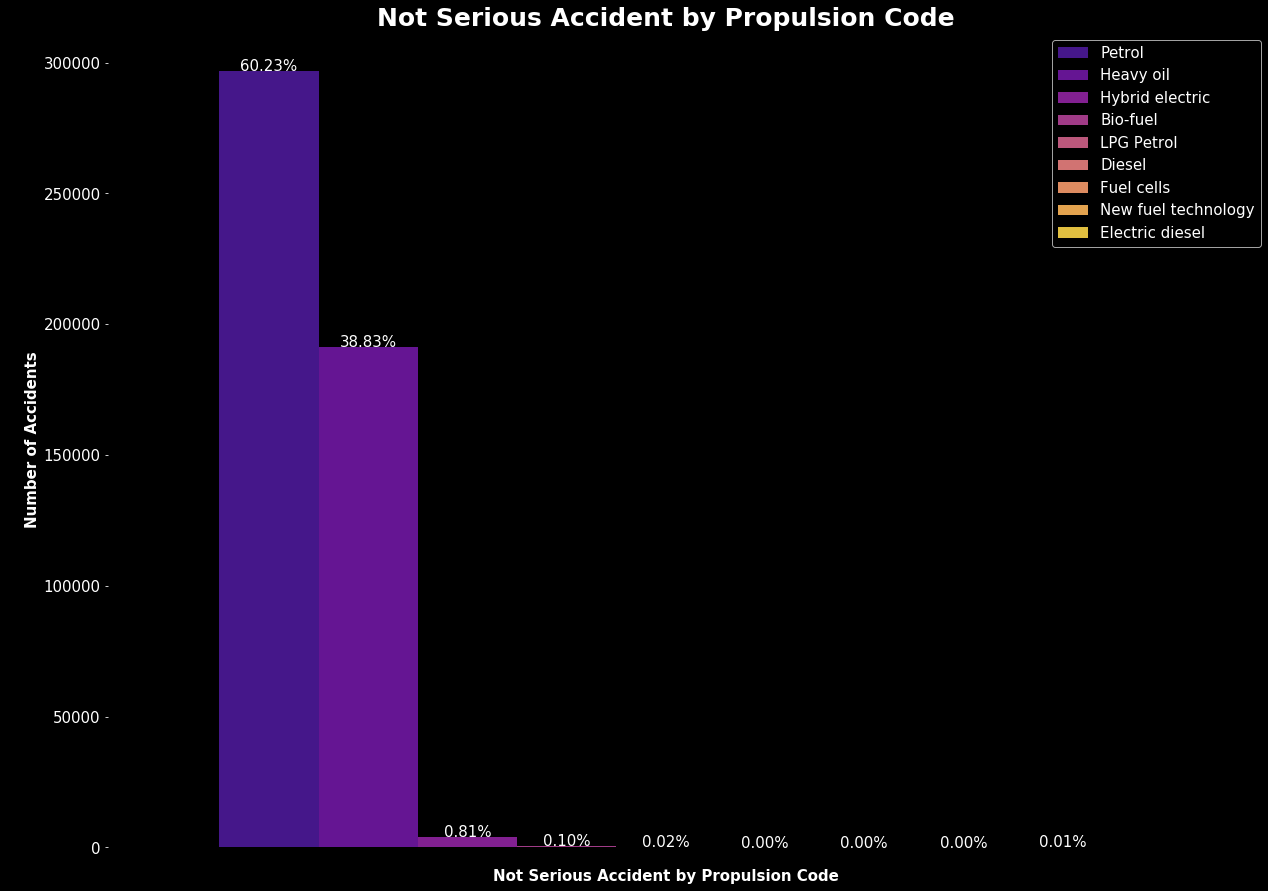

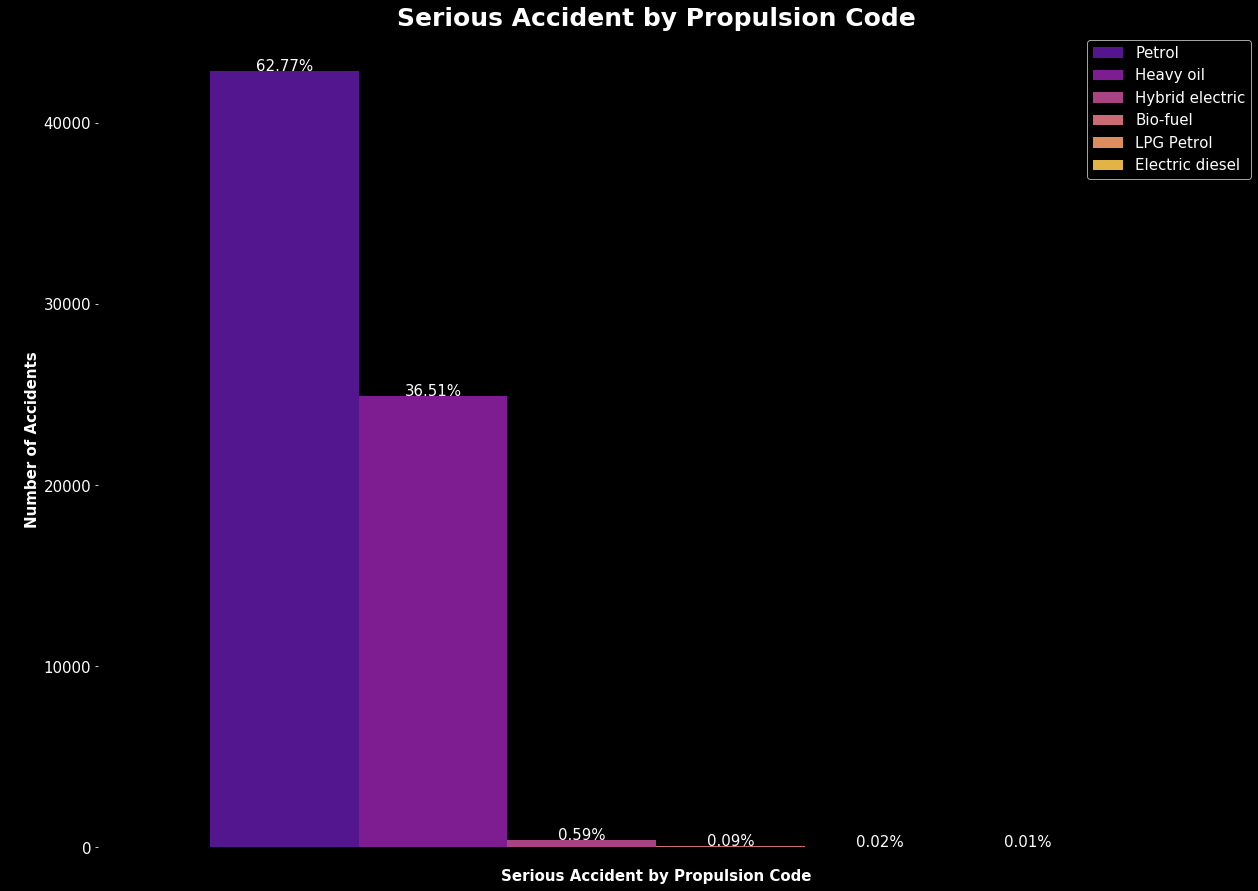

In [218]:
#propulsion_code
pd_order=['Petrol', 'Heavy oil', 'Hybrid electric', 'Bio-fuel', 'LPG Petrol', 'Diesel',
          'Fuel cells', 'New fuel technology', 'Electric diesel']
pd_order2=['Petrol', 'Heavy oil', 'Hybrid electric', 'Bio-fuel', 'LPG Petrol', 'Electric diesel']
#Not Serious Accident propulsion_code
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="propulsion_code", hue_order=pd_order,
              palette="plasma", data=not_serious)

plt.style.use('dark_background')
plt.title("Not Serious Accident by Propulsion Code",fontsize=25,fontweight="bold")
plt.xlabel("\nNot Serious Accident by Propulsion Code", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('propulsion_code_not_serious.png')
plt.show()


#Serious Accident propulsion_code
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="propulsion_code", hue_order=pd_order2,
              palette="plasma", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accident by Propulsion Code",fontsize=25,fontweight="bold")
plt.xlabel("\nSerious Accident by Propulsion Code", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('propulsion_code_serious.png')
plt.show()

#### Year

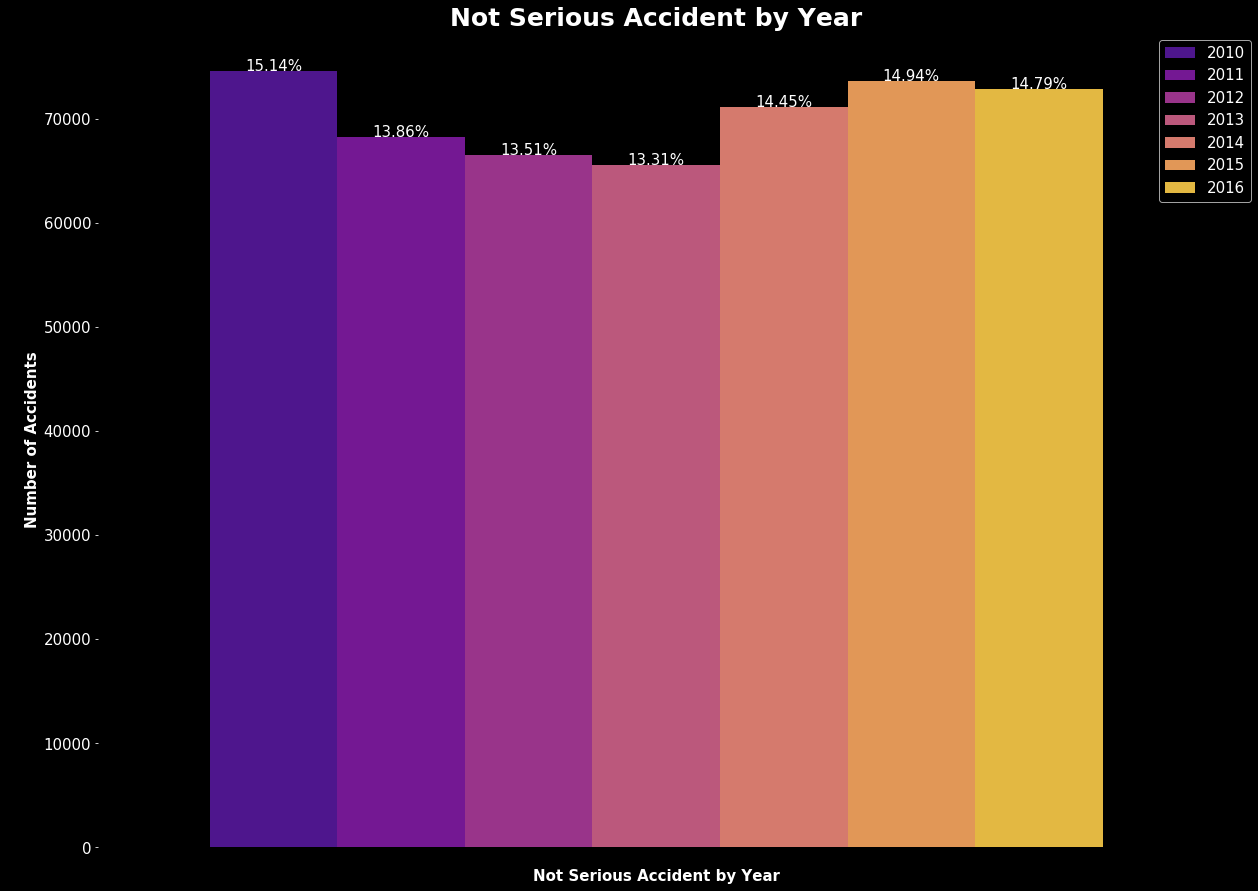

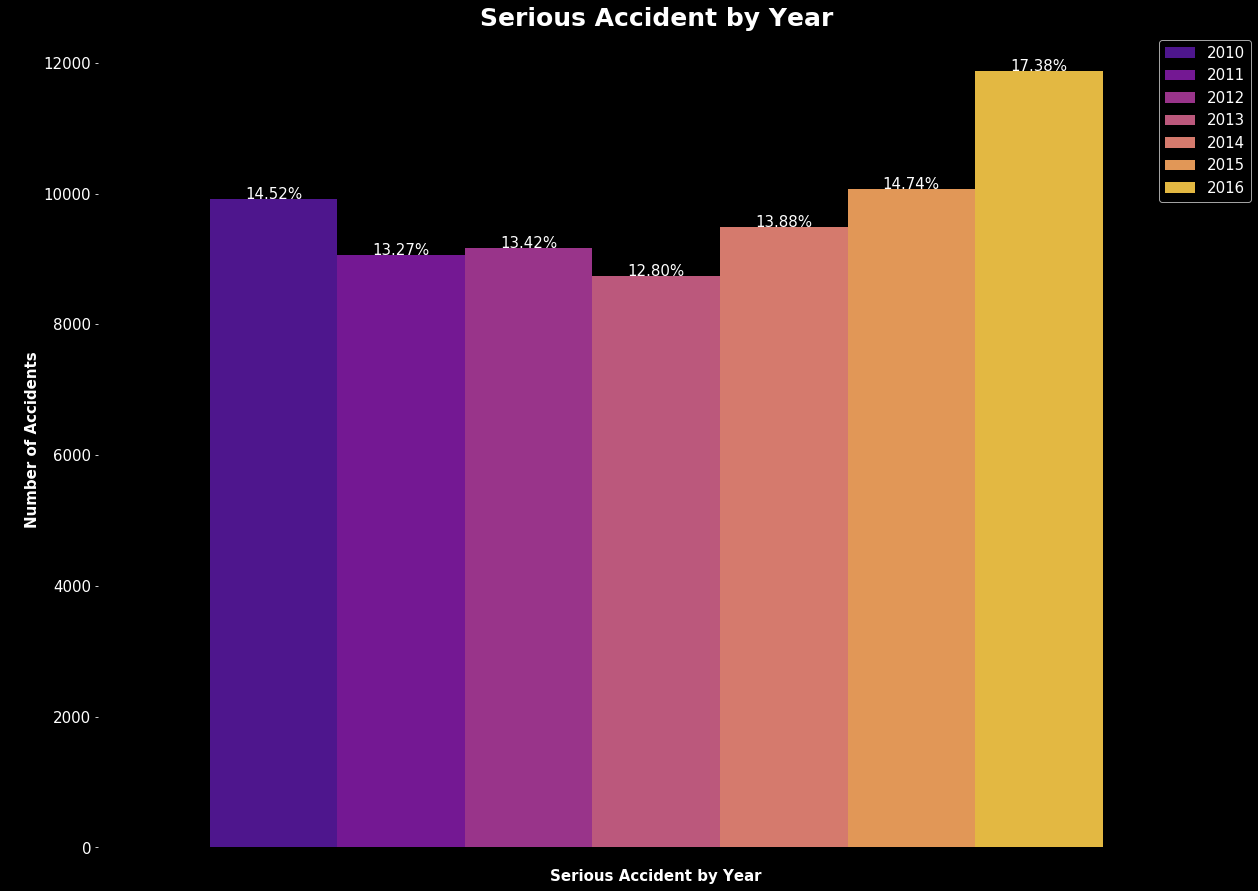

In [230]:
#yeare
year_order=[2010, 2011, 2012, 2013, 2014, 2015, 2016]

#Not Serious Accident yeare
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="year", hue_order=year_order,
              palette="plasma", data=not_serious)

plt.style.use('dark_background')
plt.title("Not Serious Accident by Year",fontsize=25,fontweight="bold")
plt.xlabel("\nNot Serious Accident by Year", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('year_not_serious.png')
plt.show()


#Serious Accident year
plt.figure(figsize=(20,15))
ax=sns.countplot("accident_seriousness", hue="year", hue_order=year_order,
              palette="plasma", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accident by Year",fontsize=25,fontweight="bold")
plt.xlabel("\nSerious Accident by Year", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('year_serious.png')
plt.show()

### Visualization Summary
* <b>did_police_officer_attend_scene_of_accident:</b> Police attended most accidents but were less likely to NOT be called in serious accidents.
* <b>x1st_point_of_impact:</b> Majority of accidents were front impacted as the first point of impact. Not serious accidents had a higher percentage of Back impact accidents than serious accidents. Serious accidents had higher percentages of Offside and Nearside accidents. 
* <b>number_of_vehicles:</b>  Nothing significant.
* <b>speed_limit:</b> Majority of accidents occurred in 30 speed limit zones. It would have been beneficial to have actual data on the speeds of the vehicles involved or at least if they were speeding.
* <b>urban_or_rural_area:</b> Rural areas had a higher percentage of serious accidents. This may relate to hospital locations or emergency vehicle arrival data which was not available.
* <b>skidding_and_overturning:</b> Higher percentages of serious accidents involved skidding, jackknifing or overturning.
* <b>vehicle_leaving_carriageway:</b> Most vehicles did not leave the carriageway in either type of accident, however serious accidents had higher percentages of those that did leave the carriageway.
* <b>sex_of_driver:</b> Men were more involved in both serious and not serious accidents, however according to racfoundation.org, there are only 355 of female privately registered cars on UK roads.
* <b>vehicle_type:</b>  Motorcycles were involved in a significantly higher percentage of serious accidents than not serious accidents
* <b>vehicle_manoeuvre:</b> Nothing significant.                      
* <b>driver_home_area_type:</b> Rural and Small Towns has higher percentages of serious accidents. This may relate to hospital locations or emergency vehicle arrival data which was not available.
* <b>age_band_of_driver:</b> The age bands over the age of 25 had a higher percentage of serious accidents than not serious.
* <b>junction_control:</b>  Most areas with accidents were uncontrolled. 
* <b>hit_object_off_carriageway:</b> The majority of accidents did not involve objects being hit off the carriageway, hoever serious accidents had higher percentages of accidents that did involde hitting an object off the carriageway.
* <b>hit_object_in_carriageway:</b>Most accidents did not involve objects being hit in the carriageway; however serious accidents had higher percentages of accidents that did involve hitting an object off the carriageway.
* <b>driver_imd_decile:</b> Nothing significant. Most accidents occurred in areas that were Less deprived 20-30%
* <b>junction_detail:</b> T or staggered junctions were where most of the accidents occurred.
* <b>junction_location:</b> Nothing that separates the two serious types. However, most accidents seem to have occurred in Mid Junction - on roundabout or on main road or situations where the driver was approaching junction or waiting/parked at junction approach.
* <b>propulsion_code:</b> Diesel, Fuel cells, New fuel technology, vehicles were not recorded as a part of serious accidents.
* <b>year:</b> There has been a spike in percentage of serious accidents over the years. However, the percentage of not serious accidents has remained somewhat consistent

### Other Visualizations

Due to the previous visualization a comparison of certain variables was desired to see more correlations. The comparisons listed above will be displayed in the outputs to follow. 


#### Junction Control by Junction Detail

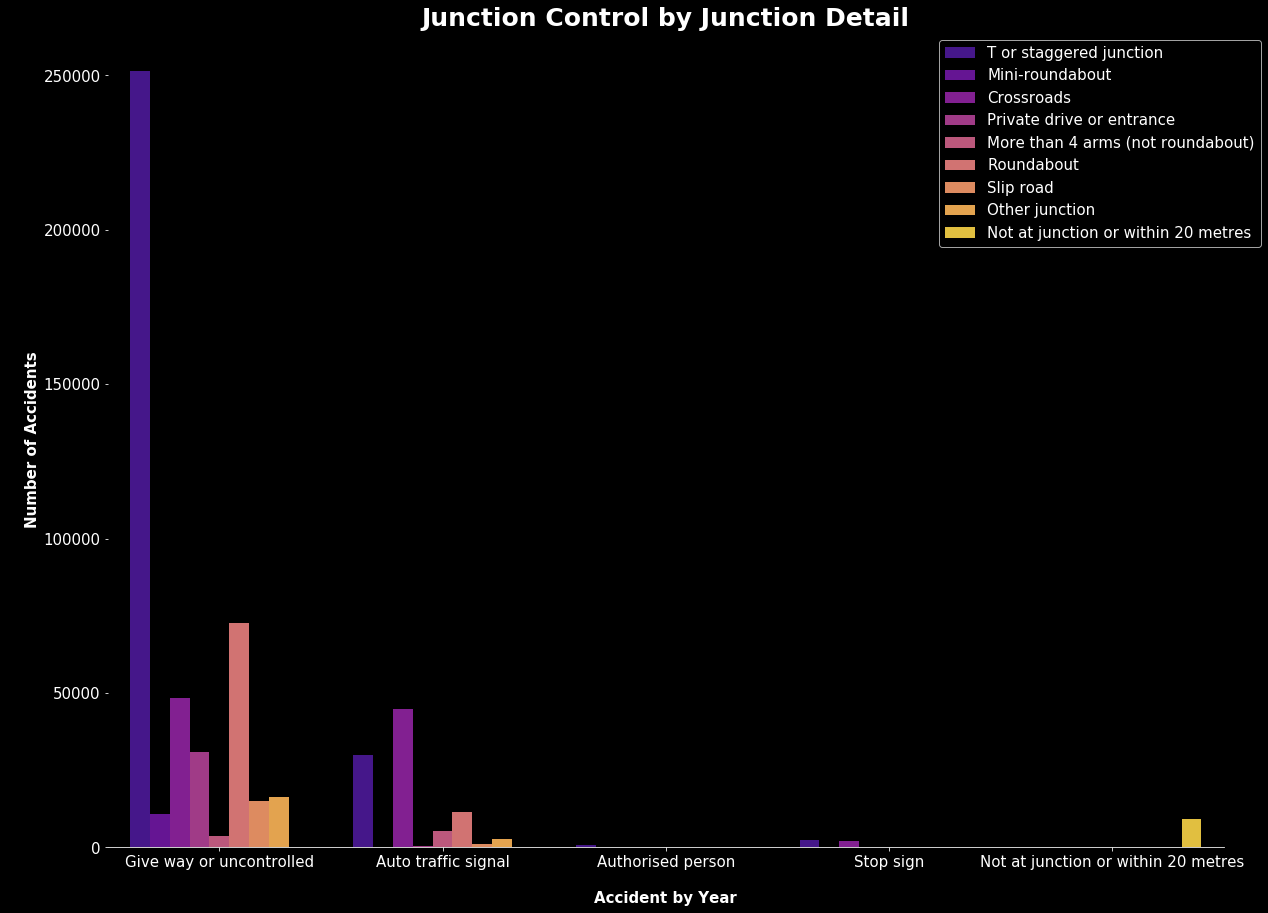

In [246]:
#Not Serious Accident
plt.figure(figsize=(20,15))
ax=sns.countplot("junction_control", hue="junction_detail",
              palette="plasma", data=df)

plt.style.use('dark_background')
plt.title("Junction Control by Junction Detail",fontsize=25,fontweight="bold")
plt.xlabel("\nAccident by Year", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.savefig('junction_control_by_junction_detail.png')
plt.show()


#### Junction Control by Junction Location

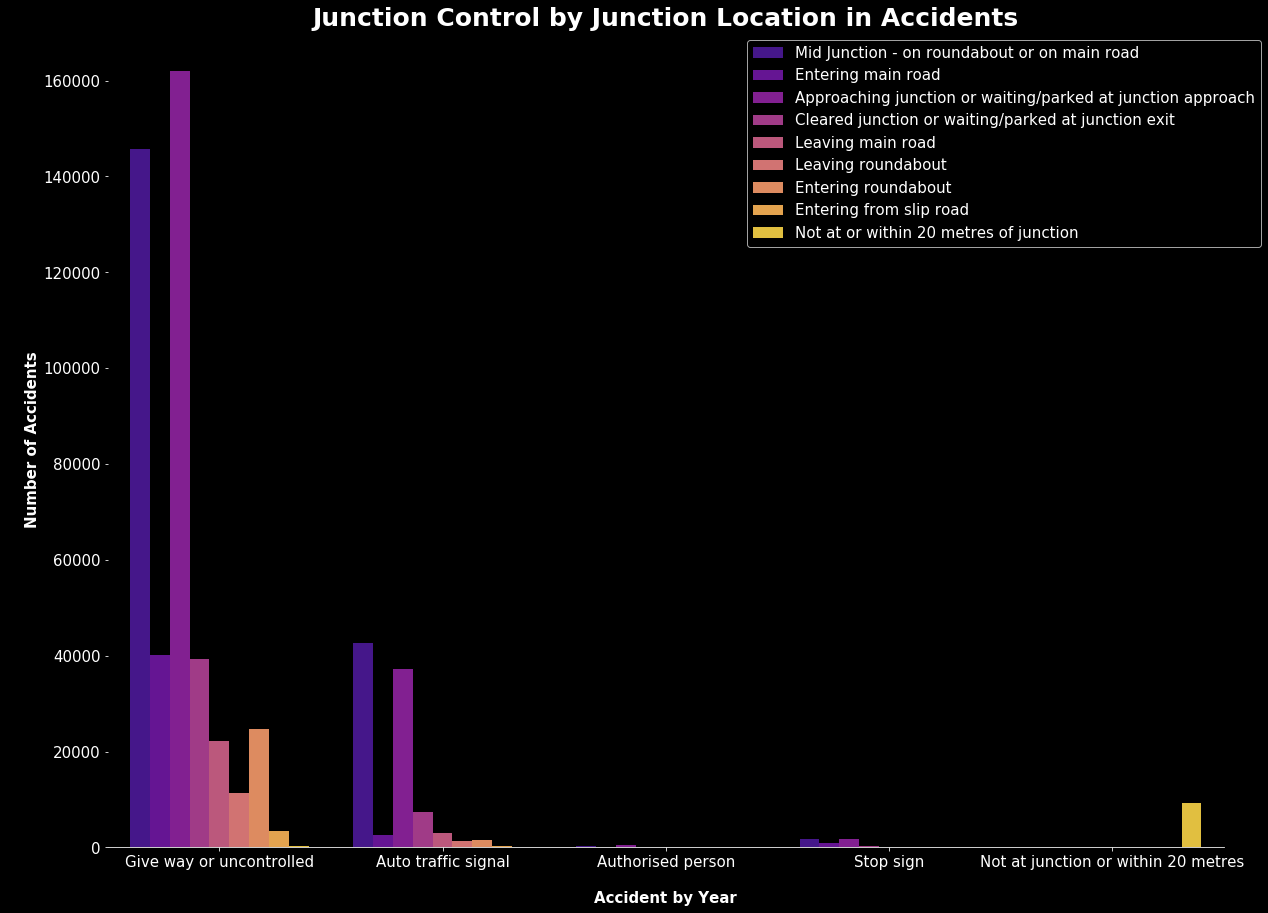

In [245]:

plt.figure(figsize=(20,15))
ax=sns.countplot("junction_control", hue="junction_location",
              palette="plasma", data=df)

plt.style.use('dark_background')
plt.title("Junction Control by Junction Location in Accidents",fontsize=25,fontweight="bold")
plt.xlabel("\nAccident by Year", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.savefig('junction_control_by_junction_location.png')
plt.show()

#### First point of Impact by Junction Detail

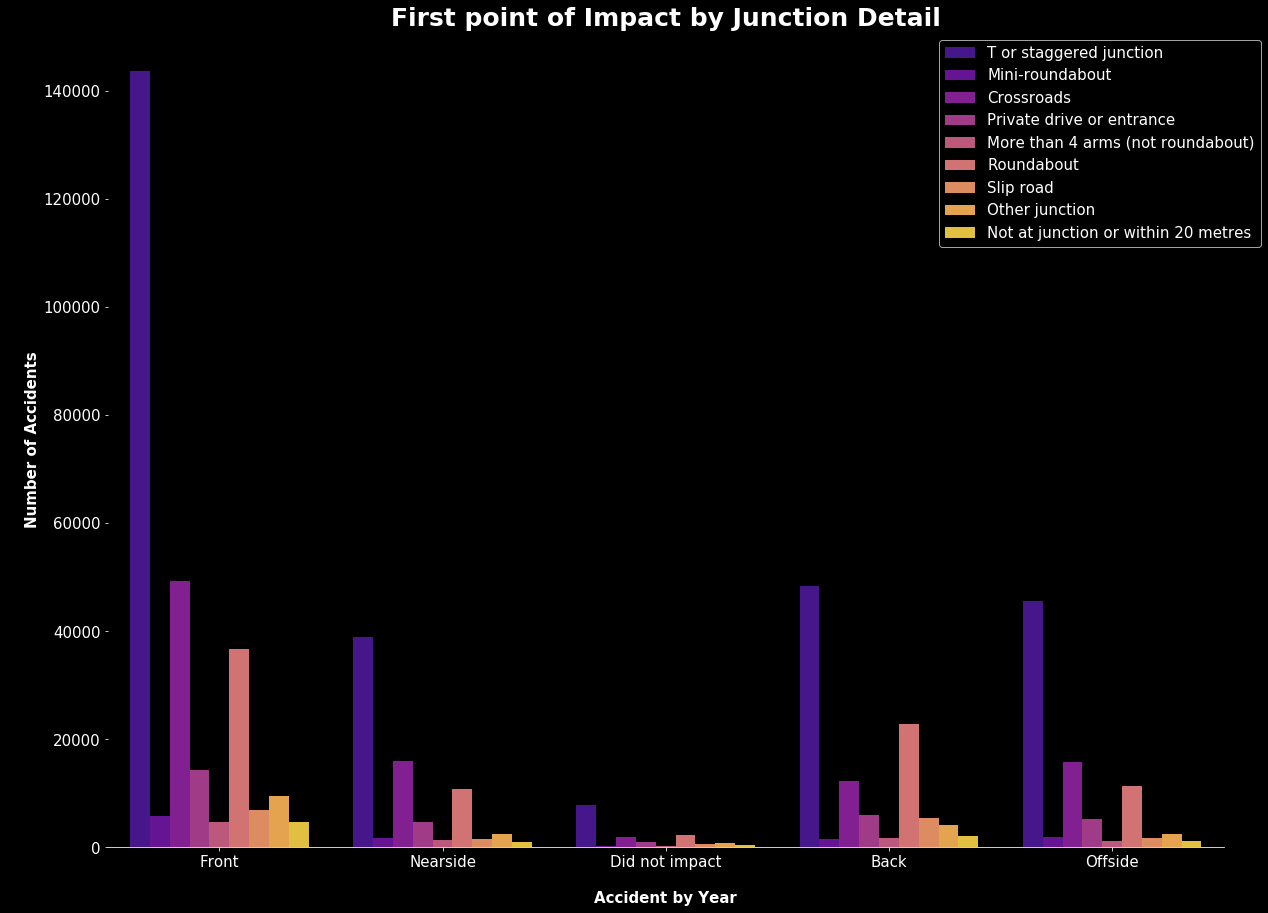

In [248]:
plt.figure(figsize=(20,15))
ax=sns.countplot("x1st_point_of_impact", hue="junction_detail",
              palette="plasma", data=df)

plt.style.use('dark_background')
plt.title("First point of Impact by Junction Detail",fontsize=25,fontweight="bold")
plt.xlabel("\nAccident by Year", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.savefig('x1st_point_of_impact_by_junction_detail.png')
plt.show()

#### First point of Impact by Junction Location

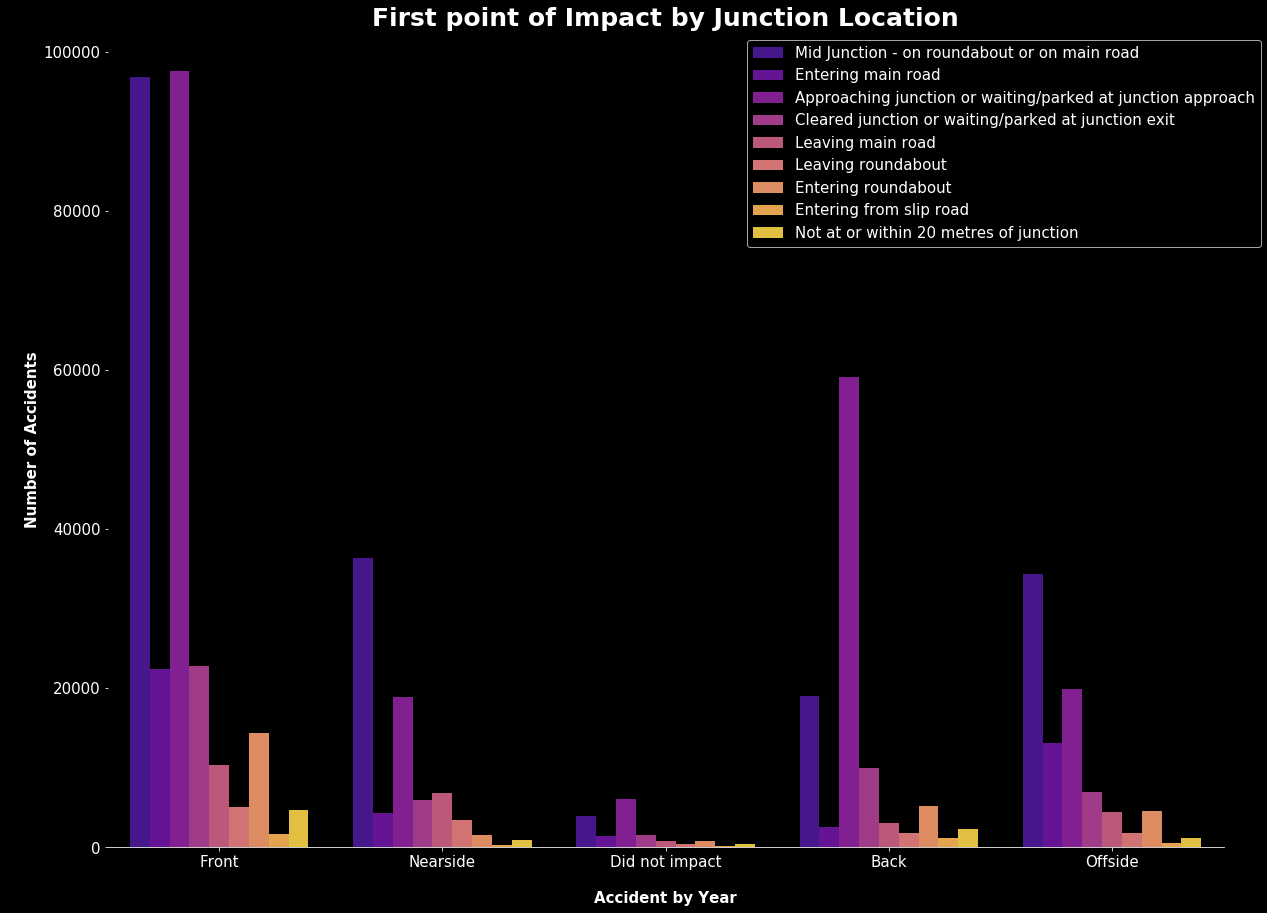

In [247]:
plt.figure(figsize=(20,15))
ax=sns.countplot("x1st_point_of_impact", hue="junction_location",
              palette="plasma", data=df)

plt.style.use('dark_background')
plt.title("First point of Impact by Junction Location",fontsize=25,fontweight="bold")
plt.xlabel("\nAccident by Year", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.savefig('x1st_point_of_impact_by_junction_location.png')
plt.show()

### Junction Control and First Point of Impact

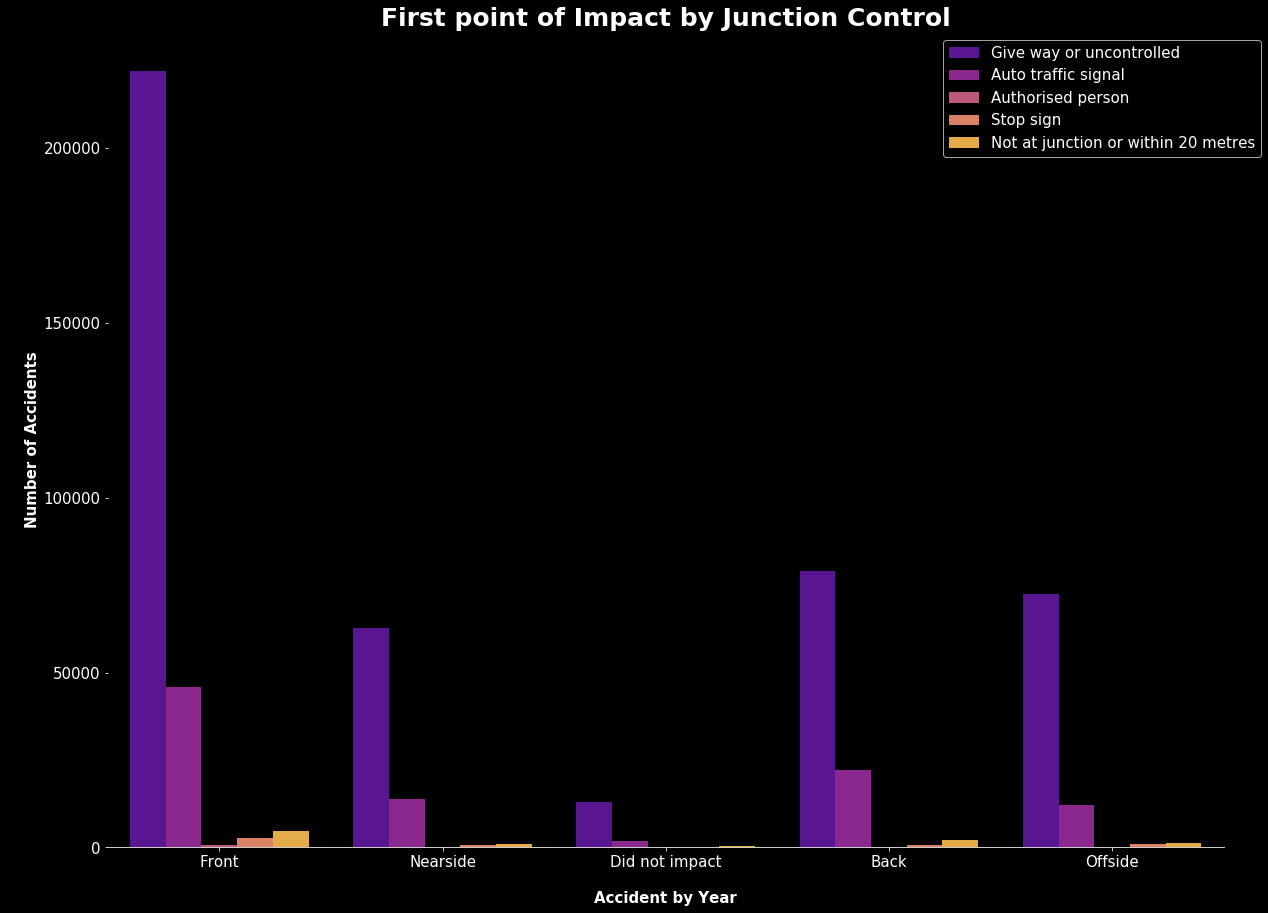

In [249]:
plt.figure(figsize=(20,15))
ax=sns.countplot("x1st_point_of_impact", hue="junction_control",
              palette="plasma", data=df)

plt.style.use('dark_background')
plt.title("First point of Impact by Junction Control",fontsize=25,fontweight="bold")
plt.xlabel("\nAccident by Year", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.savefig('x1st_point_of_impact_by_junction_control.png')
plt.show()

### Other Visualizations Summary
No matter the situation above, the most accidents were involving areas that were uncontrolled. One of the main ones were the junction Detail T or staggered junction.

Other areas of concern include Mid Junctions on roundabouts or main roads and areas approaching a junction were cars were either parking or waiting in the junction. 


### Solution

From the data above more controlled areas would be benefical. Maybe signs alerting drivers of the upcoming junctions, traffic lights, or stop signs would help in some of these areas where they are feasible. 

## Machine Learning

In [3]:
#made separate dataframe w. set index that wouldnt effect data vis above
df1=df
#set index to accident_index
df1.set_index('accident_index', inplace=True)
df1.head()

,1st_road_class,1st_road_number,2nd_road_number,accident_severity,carriageway_hazards,date,day_of_week,did_police_officer_attend_scene_of_accident,junction_control,junction_detail,...,vehicle_type,was_vehicle_left_hand_drive,x1st_point_of_impact,month,weekend,hour,time_of_day,season,engine_capacity_cc_size,accident_seriousness
accident_index,,,,,,,,,,,,,,,,,,,,,
201001BS70003,B,302,0,Slight,None,2010-01-11,Monday,1,Give way or uncontrolled,T or staggered junction,...,Goods Vehicle,No,Front,1,0,7,1,winter,small engine cc,Not Serious
201001BS70004,A,402,4204,Slight,None,2010-01-11,Monday,1,Auto traffic signal,T or staggered junction,...,Car,No,Front,1,0,18,6,winter,medium engine cc,Not Serious
201001BS70007,Unclassified,0,0,Slight,None,2010-01-02,Saturday,1,Give way or uncontrolled,Mini-roundabout,...,Car,No,Nearside,1,1,21,6,winter,medium engine cc,Not Serious
201001BS70007,Unclassified,0,0,Slight,None,2010-01-02,Saturday,1,Give way or uncontrolled,Mini-roundabout,...,Car,No,Front,1,1,21,6,winter,small engine cc,Not Serious
201001BS70008,A,3217,3220,Slight,None,2010-01-04,Monday,1,Auto traffic signal,Crossroads,...,Car,No,Nearside,1,0,20,6,winter,medium engine cc,Not Serious


In [4]:
df1 = df1.apply(LabelEncoder().fit_transform)

#### Undersampling
Undersampling is done because of the extreme unevenness and bias of the data. 

In [5]:
#First set up of X and Y
X= df1.drop(['accident_severity','accident_seriousness'],axis=1)
y= df1['accident_seriousness']

In [6]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [7]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

In [8]:
# separate minority and majority classes
not_severe = X[X.accident_seriousness==0]
severe = X[X.accident_seriousness==1]

In [9]:
# decrease majority
not_severe_decreased = resample(not_severe,
                          replace=True, # sample with replacement
                          n_samples=len(severe), # match number in majority class
                          random_state=27) # reproducible results

In [10]:
# combine majority and severe_increased minority
newdf = pd.concat([severe, not_severe_decreased])

In [11]:
newdf.accident_seriousness.value_counts()

1    51357
0    51357
Name: accident_seriousness, dtype: int64

In [12]:
X_train = newdf.drop('accident_seriousness', axis=1)
y_train = newdf.accident_seriousness

In [13]:
#scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [14]:
#Decision Tree Classifier

dtc = DecisionTreeClassifier(random_state=42)

dtc.fit(X_train, y_train)
pred_dtc = dtc.predict(X_test)

#Check accuracy

print("Decision Tree Classifier Accuracy Score: {:0.2f}%".format(accuracy_score(y_test,
                                                                               pred_dtc )*100))
print("Decision Tree Classifier F1 Score: {:0.2f}%".format(f1_score(y_test,
                                                                   pred_dtc,average="macro")*100))
print("Decision Tree Classifier Precision Score: {:0.2f}%".format(precision_score(y_test,
                                                                                 pred_dtc, 
                                                                                 average="macro")*100))
print("Decision Tree Classifier Recall Score: {:0.2f}%".format(recall_score(y_test, 
                                                                           pred_dtc,
                                                                           average="macro")*100))
print("Decision Tree  Classifier Cross Validation Score: {:0.2f}%".format(np.mean(cross_val_score(dtc, 
                                                                           X_train,
                                                                           y_train,
                                                                           cv=5)*100)))
print('\n')
print("Decision Tree Classifier Confusion Matrix:\n", confusion_matrix(y_test,pred_dtc))

Decision Tree Classifier Accuracy Score: 57.68%
Decision Tree Classifier F1 Score: 48.05%
Decision Tree Classifier Precision Score: 53.81%
Decision Tree Classifier Recall Score: 58.87%
Decision Tree  Classifier Cross Validation Score: 60.69%


Decision Tree Classifier Confusion Matrix:
 [[70663 52647]
 [ 6716 10258]]


In [166]:
#Bagging Classifier
bagc = BaggingClassifier(random_state=42)

bagc.fit(X_train, y_train)
pred_bagc = bagc.predict(X_test)


#Check accuracy

print("Bagging Classifier Accuracy Score: {:0.2f}%".format(accuracy_score(y_test,
                                                                               pred_bagc )*100))
print("Bagging Classifier F1 Score: {:0.2f}%".format(f1_score(y_test,
                                                                   pred_bagc,average="macro")*100))
print("Bagging Classifier Precision Score: {:0.2f}%".format(precision_score(y_test,
                                                                                 pred_bagc, 
                                                                                 average="macro")*100))
print("Bagging Classifier Recall Score: {:0.2f}%".format(recall_score(y_test, 
                                                                           pred_bagc,
                                                                           average="macro")*100))
print("Bagging Classifier Cross Validation Score: {:0.2f}%"
      .format(np.mean(cross_val_score(bagc, X_train, y_train, cv=5)*100)))
print('\n')
print("Bagging Classifier Confusion Matrix:\n", confusion_matrix(y_test,pred_bagc))

Bagging Classifier Accuracy Score: 68.61%
Bagging Classifier F1 Score: 55.35%
Bagging Classifier Precision Score: 56.78%
Bagging Classifier Recall Score: 64.18%
Bagging Classifier Cross Validation Score: 65.24%


Bagging Classifier Confusion Matrix:
 [[86343 36967]
 [ 7072  9902]]


In [170]:
#ExtraTreesClassifier

extc = ExtraTreesClassifier(random_state=42)
extc.fit(X_train, y_train)
pred_extc = extc.predict(X_test)

#Check accuracy

print("Extra Trees Classifier Accuracy Score: {:0.2f}%"
      .format(accuracy_score(y_test,pred_extc )*100))
print("Extra Trees Classifier F1 Score: {:0.2f}%"
      .format(f1_score(y_test, pred_extc,average="macro")*100))
print("Extra Trees Classifier Precision Score: {:0.2f}%"
      .format(precision_score(y_test, pred_extc, average="macro")*100))
print("Extra Trees Classifier Recall Score: {:0.2f}%"
      .format(recall_score(y_test, pred_extc, average="macro")*100))
print("Extra Trees Classifier Cross Validation Score: {:0.2f}%"
      .format(np.mean(cross_val_score(extc, X_train, y_train, cv=5)*100)))
print('\n')
print("Extra Trees Classifier Confusion Matrix:\n", confusion_matrix(y_test,pred_extc))


Extra Trees Classifier Accuracy Score: 67.05%
Extra Trees Classifier F1 Score: 53.95%
Extra Trees Classifier Precision Score: 55.92%
Extra Trees Classifier Recall Score: 62.58%
Extra Trees Classifier Cross Validation Score: 64.16%


Extra Trees Classifier Confusion Matrix:
 [[84446 38864]
 [ 7354  9620]]


In [172]:
#AdaBoost Classifier 

adbc = AdaBoostClassifier(random_state=42)
adbc.fit(X_train, y_train)
pred_adbc = adbc.predict(X_test)

#Check accuracy

#Check accuracy

print("AdaBoost Classifier Accuracy Score: {:0.2f}%"
      .format(accuracy_score(y_test,pred_adbc )*100))
print("AdaBoost Classifier F1 Score: {:0.2f}%"
      .format(f1_score(y_test, pred_adbc,average="macro")*100))
print("AdaBoost Classifier Precision Score: {:0.2f}%"
      .format(precision_score(y_test, pred_adbc, average="macro")*100))
print("AdaBoost Classifier Recall Score: {:0.2f}%"
      .format(recall_score(y_test, pred_adbc, average="macro")*100))
print("AdaBoost Classifier Cross Validation Score: {:0.2f}%"
      .format(np.mean(cross_val_score(adbc, X_train, y_train, cv=5)*100)))
print('\n')
print("AdaBoost Classifier Confusion Matrix:\n", confusion_matrix(y_test,pred_adbc))


AdaBoost Classifier Accuracy Score: 66.56%
AdaBoost Classifier F1 Score: 54.87%
AdaBoost Classifier Precision Score: 57.20%
AdaBoost Classifier Recall Score: 65.78%
AdaBoost Classifier Cross Validation Score: 65.87%


AdaBoost Classifier Confusion Matrix:
 [[82388 40922]
 [ 5985 10989]]


In [173]:
#Random Forest Classifier

rfc = RandomForestClassifier(random_state = 42)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

#Check accuracy
print("Random Forest Classifier Accuracy Score: {:0.2f}%"
      .format(accuracy_score(y_test,pred_rfc )*100))
print("Random Forest Classifier F1 Score: {:0.2f}%"
      .format(f1_score(y_test, pred_rfc,average="macro")*100))
print("Random Forest Classifier Precision Score: {:0.2f}%"
      .format(precision_score(y_test, pred_rfc, average="macro")*100))
print("Random Forest Classifier Recall Score: {:0.2f}%"
      .format(recall_score(y_test, pred_rfc, average="macro")*100))
print("Random Forest Classifier Cross Validation Score: {:0.2f}%"
      .format(np.mean(cross_val_score(rfc, X_train, y_train, cv=5)*100)))
print('\n')
print("Random Forest Classifier Confusion Matrix:\n", confusion_matrix(y_test,pred_rfc))


Random Forest Classifier Accuracy Score: 68.44%
Random Forest Classifier F1 Score: 54.92%
Random Forest Classifier Precision Score: 56.38%
Random Forest Classifier Recall Score: 63.29%
Random Forest Classifier Cross Validation Score: 64.76%


Random Forest Classifier Confusion Matrix:
 [[86420 36890]
 [ 7384  9590]]


In [174]:
#Gradient Boosting Classifier
gbc = ensemble.GradientBoostingClassifier(random_state = 42)
gbc.fit(X_train, y_train)
pred_gbc = gbc.predict(X_test)

#Check accuracy
print("Gradient Boosting Classifier Accuracy Score: {:0.2f}%"
      .format(accuracy_score(y_test,pred_gbc )*100))
print("Gradient Boosting Classifier F1 Score: {:0.2f}%"
      .format(f1_score(y_test, pred_gbc,average="macro")*100))
print("Gradient Boosting Classifier Precision Score: {:0.2f}%"
      .format(precision_score(y_test, pred_gbc, average="macro")*100))
print("Gradient Boosting Classifier Recall Score: {:0.2f}%"
      .format(recall_score(y_test, pred_gbc, average="macro")*100))
print("Gradient Boosting Classifier Cross Validation Score: {:0.2f}%"
      .format(np.mean(cross_val_score(gbc, X_train, y_train, cv=5)*100)))
print('\n')
print("Gradient Boosting Classifier Confusion Matrix:\n", confusion_matrix(y_test,pred_gbc))

Gradient Boosting Classifier Accuracy Score: 68.21%
Gradient Boosting Classifier F1 Score: 56.07%
Gradient Boosting Classifier Precision Score: 57.75%
Gradient Boosting Classifier Recall Score: 66.65%
Gradient Boosting Classifier Cross Validation Score: 66.77%


Gradient Boosting Classifier Confusion Matrix:
 [[84729 38581]
 [ 6010 10964]]


In [17]:
#Light GBM
lgbm = lgb.LGBMClassifier(random_state = 42)
lgbm.fit(X_train, y_train)
pred_lgbm = lgbm.predict(X_test)

#check accuracy
print("LightGBM Classifier Accuracy Score: {:0.2f}%"
      .format(accuracy_score(y_test,pred_lgbm )*100))
print("LightGBM Classifier F1 Score: {:0.2f}%"
      .format(f1_score(y_test, pred_lgbm,average="macro")*100))
print("LightGBM Classifier Precision Score: {:0.2f}%"
      .format(precision_score(y_test, pred_lgbm, average="macro")*100))
print("LightGBM Classifier Recall Score: {:0.2f}%"
      .format(recall_score(y_test, pred_lgbm, average="macro")*100))
print("LightGBM Classifier Cross Validation Score: {:0.2f}%"
      .format(np.mean(cross_val_score(lgbm, X_train, y_train, cv=5)*100)))
print('\n')
print("LightGBM Classifier Confusion Matrix:\n", confusion_matrix(y_test,pred_lgbm))


LightGBM Classifier Accuracy Score: 67.56%
LightGBM Classifier F1 Score: 56.08%
LightGBM Classifier Precision Score: 58.10%
LightGBM Classifier Recall Score: 67.71%
LightGBM Classifier Cross Validation Score: 67.65%


LightGBM Classifier Confusion Matrix:
 [[83256 40054]
 [ 5448 11526]]


In [187]:
#XGBoost
xgb = XGBClassifier(n_estimators=100, random_state = 42, max_depth=10)
xgb.fit(X_train, y_train)

pred_xgb = xgb.predict(X_test)

#check accuracy
print("XGBoost Classifier Accuracy Score: {:0.2f}%"
      .format(accuracy_score(y_test,pred_xgb)*100))
print("XGBoost Classifier F1 Score: {:0.2f}%"
      .format(f1_score(y_test, pred_xgb,average="macro")*100))
print("XGBoost Classifier Precision Score: {:0.2f}%"
      .format(precision_score(y_test, pred_xgb, average="macro")*100))
print("XGBoost Classifier Recall Score: {:0.2f}%"
      .format(recall_score(y_test, pred_xgb, average="macro")*100))
print("XGBoost Classifier Cross Validation Score: {:0.2f}%"
      .format(np.mean(cross_val_score(xgb, X_train, y_train, cv=5)*100)))
print('\n')
print("XGBoost Classifier Confusion Matrix:\n", confusion_matrix(y_test,pred_xgb))


XGBoost Classifier Accuracy Score: 68.11%
XGBoost Classifier F1 Score: 56.45%
XGBoost Classifier Precision Score: 58.25%
XGBoost Classifier Recall Score: 67.91%
XGBoost Classifier Cross Validation Score: 68.74%


XGBoost Classifier Confusion Matrix:
 [[84061 39249]
 [ 5490 11484]]


### Tuning

In [196]:
# #RANDOM FOREST PARAM
# rfc_param = {
#     'n_estimators': [100, 200, 300, 500],
#     'criterion': ['entropy', 'gini'],
#     'max_features':['auto','sqrt'],
#     'max_depth': [10, 50, 100],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4, 10],
#     'random_state':[42]}

# grid_rfc = GridSearchCV(rfc, param_grid = rfc_param, cv = 3, verbose = 1, n_jobs=-1)
# grid_rfc.fit(X_train,y_train)

# print(rfcbest_estimator = grid_rfc.best_estimator_)
# print("Random Forest:\n",grid_rfc.best_params_)

In [ ]:
# #Gradient Boosting Classifier Tuning
# gbcparam= {'learning_rate':[0.5,0.1,1],
#            'n_estimators': [100, 200, 300, 500],
#            'max_features':['auto','sqrt'],
#            'max_depth': [10, 50, 100],
#            'min_samples_leaf': [1, 2, 4, 10],
#            'min_samples_split': [2, 5, 10],
#            'random_state':[42]}



# gbctuning =GridSearchCV(gbc, param_grid = gbcparam, cv = 3, verbose = 1, n_jobs=-1)


# gbctuning.fit(X_train,y_train)
                      
# print("Gradient Boost:\n",gbctuning.best_params_)

In [21]:
# #LightGBM Tuning

# lgbmparam={'learning_rate':[0.5,0.1,1],
#            'n_estimators': [100, 200, 300, 500],
#            'max_depth': [6, 25, 50,100],
#            "num_leaves": [6,12,50],
#            'min_data_in_leaf' : [100,500,1000],
#            'random_state':[42]}

# lgbmtuning =GridSearchCV(lgbm, param_grid = lgbmparam, cv = 3, n_jobs=1, verbose = 1)


# lgbmtuning.fit(X_train,y_train)
                     
# print("LightGBM:\n",lgbmtuning.best_params_)

Wall time: 0 ns
Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed: 88.8min finished


LightGBM:
 {'learning_rate': 0.1, 'max_depth': 25, 'min_data_in_leaf': 100, 'n_estimators': 500, 'num_leaves': 50, 'random_state': 42}


In [ ]:
# #XGBoost Tuning
# xgbparam ={'max_depth': [10, 50, 100],}

In [48]:
start = time.time()
rfc2 = RandomForestClassifier(criterion='entropy', max_depth=40, 
                              max_features='sqrt', min_samples_split=8, 
                              n_estimators=500, random_state=42)
rfc2.fit(X_train, y_train)
pred_rfc2 = rfc2.predict(X_test)
#Check accuracy


#Check accuracy
print("Random Forest Classifier Accuracy Score: {:0.2f}%"
      .format(accuracy_score(y_test,pred_rfc2 )*100))
print("Random Forest Classifier F1 Score: {:0.2f}%"
      .format(f1_score(y_test, pred_rfc2,average="macro")*100))
print("Random Forest Classifier Precision Score: {:0.2f}%"
      .format(precision_score(y_test, pred_rfc2, average="macro")*100))
print("Random Forest Classifier Recall Score: {:0.2f}%"
      .format(recall_score(y_test, pred_rfc2, average="macro")*100))
print("Random Forest Classifier Cross Validation Score: {:0.2f}%"
      .format(np.mean(cross_val_score(rfc2, X_train, y_train, cv=5)*100)))
print('\n')
print("Random Forest Classifier Confusion Matrix:\n", confusion_matrix(y_test,pred_rfc2))
end = time.time()
print("Random Forest Time: ",end - start)

Random Forest Classifier Accuracy Score: 67.08%
Random Forest Classifier F1 Score: 55.98%
Random Forest Classifier Precision Score: 58.25%
Random Forest Classifier Recall Score: 68.21%
Random Forest Classifier Cross Validation Score: 69.58%


Random Forest Classifier Confusion Matrix:
 [[82271 41039]
 [ 5143 11831]]
Random Forest Time:  1006.990118265152


In [ ]:
#Gradient Boosting Classifier
start2 = time.time()
gbc2 = ensemble.GradientBoostingClassifier(learning_rate=0.05, max_depth=40, 
                                           min_samples_leaf=1, n_estimators=500,
                                           random_state = 42)
gbc2.fit(X_train, y_train)
pred_gbc2 = gbc2.predict(X_test)

#Check accuracy
print("Gradient Boosting Classifier Accuracy Score: {:0.2f}%"
      .format(accuracy_score(y_test,pred_gbc2 )*100))
print("Gradient Boosting Classifier F1 Score: {:0.2f}%"
      .format(f1_score(y_test, pred_gbc2,average="macro")*100))
print("Gradient Boosting Classifier Precision Score: {:0.2f}%"
      .format(precision_score(y_test, pred_gbc2, average="macro")*100))
print("Gradient Boosting Classifier Recall Score: {:0.2f}%"
      .format(recall_score(y_test, pred_gbc2, average="macro")*100))
print("Gradient Boosting Classifier Cross Validation Score: {:0.2f}%"
      .format(np.mean(cross_val_score(gbc2, X_train, y_train, cv=5)*100)))
print('\n')
print("Gradient Boosting Classifier Confusion Matrix:\n", confusion_matrix(y_test,pred_gbc2))
end2 = time.time()
print("Gradient Boosting Time:", end2 - start2)

Gradient Boosting Classifier Accuracy Score: 58.26%
Gradient Boosting Classifier F1 Score: 48.58%
Gradient Boosting Classifier Precision Score: 54.15%
Gradient Boosting Classifier Recall Score: 59.64%


In [15]:
#Light GBM
#LightGBM:{'learning_rate': 0.1, 'max_depth': 25, 'min_data_in_leaf': 100, 
#'n_estimators': 500, 'num_leaves': 50, 'random_state': 42}
start3 = time.time()
lgbm2 = lgb.LGBMClassifier(learning_rate =0.03, max_depth=40, min_data_in_leaf=10, 
                           max_cat_threshold=99999999,
                           n_estimators=500, num_leaves=50, random_state = 42)
lgbm2.fit(X_train, y_train)
pred_lgbm2 = lgbm2.predict(X_test)

#check accuracy
print("LightGBM Classifier Accuracy Score: {:0.2f}%"
      .format(accuracy_score(y_test,pred_lgbm2 )*100))
print("LightGBM Classifier F1 Score: {:0.2f}%"
      .format(f1_score(y_test, pred_lgbm2,average="macro")*100))
print("LightGBM Classifier Precision Score: {:0.2f}%"
      .format(precision_score(y_test, pred_lgbm2, average="macro")*100))
print("LightGBM Classifier Recall Score: {:0.2f}%"
      .format(recall_score(y_test, pred_lgbm2, average="macro")*100))
print("LightGBM Classifier Cross Validation Score: {:0.2f}%"
      .format(np.mean(cross_val_score(lgbm2, X_train, y_train, cv=5)*100)))
print('\n')
print("LightGBM Classifier Confusion Matrix:\n", confusion_matrix(y_test,pred_lgbm2))
end3 = time.time()
print("LightGBM Time:", end3 - start3)

LightGBM Classifier Accuracy Score: 67.93%
LightGBM Classifier F1 Score: 56.41%
LightGBM Classifier Precision Score: 58.29%
LightGBM Classifier Recall Score: 68.06%
LightGBM Classifier Cross Validation Score: 68.22%


LightGBM Classifier Confusion Matrix:
 [[83719 39591]
 [ 5392 11582]]
LightGBM Time: 73.5155577659607


In [16]:
#XGBoost
start4 = time.time()
xgb2 = XGBClassifier(learning_rate=0.05, n_estimators=500, subsample= 1,random_state = 42,
                     gamma = 1, max_depth=40)
xgb2.fit(X_train, y_train)

pred_xgb2 = xgb2.predict(X_test)

#check accuracy
print("XGBoost Classifier Accuracy Score: {:0.2f}%"
      .format(accuracy_score(y_test,pred_xgb2)*100))
print("XGBoost Classifier F1 Score: {:0.2f}%"
      .format(f1_score(y_test, pred_xgb2,average="macro")*100))
print("XGBoost Classifier Precision Score: {:0.2f}%"
      .format(precision_score(y_test, pred_xgb2, average="macro")*100))
print("XGBoost Classifier Recall Score: {:0.2f}%"
      .format(recall_score(y_test, pred_xgb2, average="macro")*100))
print("XGBoost Classifier Cross Validation Score: {:0.2f}%"
      .format(np.mean(cross_val_score(xgb2, X_train, y_train, cv=5)*100)))
print('\n')
print("XGBoost Classifier Confusion Matrix:\n", confusion_matrix(y_test,pred_xgb2))
end4 = time.time()
print("XGBoost Time:", end4 - start4)


XGBoost Classifier Accuracy Score: 66.69%
XGBoost Classifier F1 Score: 55.71%
XGBoost Classifier Precision Score: 58.13%
XGBoost Classifier Recall Score: 68.04%
XGBoost Classifier Cross Validation Score: 69.27%


XGBoost Classifier Confusion Matrix:
 [[81700 41610]
 [ 5123 11851]]
XGBoost Time: 7625.058862447739


#### Selected Machine Learning Algorithm and Explanation

#### Time series

In [157]:
# dftime=df
# dftime['accident_index']=dftime.index

In [158]:
# dftime.index=dftime['date']

In [161]:
# monthly_count = dftime.accident_index.resample('M').count()

In [206]:
# mov_mean = monthly_count.rolling(window=12).mean()
# mov_std = monthly_count.rolling(window=12).std()

In [281]:
# plt.figure(figsize=(20, 10))
# main = plt.plot(monthly_count, color='purple', label='Regular')
# rmean = plt.plot(mov_mean, color='red', label='Rolling Mean')
# rstd = plt.plot(mov_std, color='yellow', label='Rolling Std')

# plt.legend(fontsize='15',loc='best')
# plt.title('Rolling Mean & Standard Deviation')
# plt.show()

In [280]:
# #stationary check
# rcParams['figure.figsize'] = 20, 10
# decomposition = sm.tsa.seasonal_decompose(monthly_count, model='additive')
# fig = decomposition.plot()
# plt.show()

In [222]:
# #AR Model
# #making order=(2,1,0) gives RSS=1.5023
# model = ARIMA(monthly_count, order=(2,1,0))
# results_AR = model.fit(disp=-1)
# plt.plot(datasetLogDiffShifting)
# plt.plot(results_AR.fittedvalues, color='red')
# plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
# print('Plotting AR model')

()